********************

In [1]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['SimHei']  # 使用黑体
plt.rcParams['axes.unicode_minus'] = False   # 解决负号显示问题


# 1. Agent学生主体

In [2]:


import random
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from mesa.time import RandomActivation
from numpy.random import normal
from mesa.datacollection import DataCollector  # 导入数据收集器，用于记录模型和主体的数据。
import networkx as nx


# 学生主体类
class StudentAgent(Agent):
    def __init__(self, unique_id, model, summer_start, summer_end, winter_start, winter_end, holiday_effects, profile="normal", grade=None, faculty=None, green_education=False,c_d_ratio=(0.5, 0.5)):
        """
        初始化学生主体。
        Args:
            unique_id (int): 学生唯一编号。
            model (Model): 模型对象。
            summer_start (str): 暑假开始日期（YYYY-MM-DD）。
            summer_end (str): 暑假结束日期（YYYY-MM-DD）。
            winter_start (str): 寒假开始日期（YYYY-MM-DD）。
            winter_end (str): 寒假结束日期（YYYY-MM-DD）。
            holiday_effects (dict): 假期效应字典，键为日期字符串（YYYY-MM-DD），值为假期类型。
            profile (str): 学生行为类型。
            grade (str): 学生年级。
            faculty (str): 学生专业。
            green_education (bool): 是否参与绿色教育课程。
        """
        super().__init__(unique_id, model)
        # print(self.current_date)
        self.is_on_campus = True  # 是否在校状态

        # 设置寒暑假信息
        self.summer_start = datetime.strptime(summer_start, "%Y-%m-%d")
        self.summer_end = datetime.strptime(summer_end, "%Y-%m-%d")
        self.winter_start = datetime.strptime(winter_start, "%Y-%m-%d")
        self.winter_end = datetime.strptime(winter_end, "%Y-%m-%d")

        # 假期效应和参数
        self.holiday_effects = holiday_effects

        # 社会学信息
        self.profile = profile
        self.grade = grade
        self.faculty = faculty
        self.green_education = green_education
        self.c, self.d = c_d_ratio

        # 基础用水量
        self.base_consumption = self.calculate_base_consumption()

        # 每天淋浴和洗衣服的概率
        self.shower_probs = [0.63, 0.66, 0.66, 0.65, 0.62, 0.62, 0.64]
        self.laundry_probs = [0.40, 0.40, 0.40, 0.40, 0.45, 0.45, 0.45]

        # 内嵌的暑假和寒假多项式系数
        self._summer_coefficients = [8.60987857e-01, 1.36859624e-02, -1.99858329e-03, 5.92193526e-05, -7.76982757e-07, 3.99970679e-09]


        self._winter_coefficients = [0.7645638874513381, -0.0013731766863659181, -0.0057098630785314556, 0.00027673512470457806, -4.405621735518008e-06, 2.3663790433562584e-08]
        self.summer_probability_poly = Polynomial(self._summer_coefficients)
        self.winter_probability_poly = Polynomial(self._winter_coefficients)

        # 用于记录每日用水量历史（元组格式： (日期, 用水量)）
        self.water_usage_history = []


    def calculate_behavior_utilities(self, neighbors_behavior):
        """
        根据邻居行为计算行为效用。
        """
        V_env = neighbors_behavior["environmentalist"]
        V_normal = neighbors_behavior["normal"]

        # 根据是否接受绿色教育，获取行为效用的系数【这个系数设置的太小，会使得转变和不转变收到邻居的影响较小，同样a/b/c/d不要求加起来和为1之类的】
        if self.green_education:
            a, b, c, d = 0.7, 0.3, self.c, self.d
        else:
            a, b, c, d = 0.7, 0.3, 0.3, 0.7

        e = 0
        if self.faculty == "B":
            student_avg_usage = self.get_water_usage_last30_days()
            global_avg_usage = self.model.get_global_water_usage_last30_days()
            if global_avg_usage > 0:
                e = 1.5 * max(0, student_avg_usage / global_avg_usage - 1)

        if self.profile == "environmentalist":
            U_env_to_env =  a * V_env + e
            U_env_to_normal = b * V_normal
            return U_env_to_env, U_env_to_normal
        else:  # self.profile == "normal"
            U_normal_to_env =  c * V_env + e
            U_normal_to_normal =  d * V_normal
            return U_normal_to_env, U_normal_to_normal

    def calculate_base_consumption(self):
        """定义基础设备的每日用水量（单位：升）。"""
        # 根据 profile 设置基础用水量
        if self.profile == "environmentalist":
            base_usage = {"toilet": 10, "sink": 15}
        else:  # profile == "normal"
            base_usage = {"toilet": 17, "sink": 30}
        
        return sum(base_usage.values())

    def calculate_daily_water_usage(self):
        """计算每日用水量。"""
        if not self.is_on_campus:
            return 0  # 如果不在校，直接返回0

        day_of_week = self.model.current_date.weekday()  # 直接从模型获取当前日期
        daily_consumption = self.base_consumption

        # 根据 profile 设置额外用水量参数
        if self.profile == "environmentalist":
            shower_usage = 50
            laundry_usage = 70
        else:  # profile == "normal"
            shower_usage = 70
            laundry_usage = 90

        # 计算额外用水量
        if random.random() < self.shower_probs[day_of_week]:
            daily_consumption += shower_usage
        if random.random() < self.laundry_probs[day_of_week]:
            daily_consumption += laundry_usage

        # 加入正态分布随机扰动（均值为 daily_consumption，标准差为 5% 的 daily_consumption）
        daily_consumption_with_noise = max(0, normal(daily_consumption, daily_consumption * 0.05))
        return daily_consumption_with_noise

    def update_on_campus_status(self):
        current_date = self.model.current_date  # 使用模型的当前日期
        if self.summer_start <= current_date <= self.summer_end:
            day_count = (current_date - self.summer_start).days
            on_campus_probability = self.summer_probability_poly(day_count) 
        elif self.winter_start <= current_date <= self.winter_end:
            day_count = (current_date - self.winter_start).days
            on_campus_probability = self.winter_probability_poly(day_count)
        else:
            if current_date in self.holiday_effects:
                daily_effect = sum(self.holiday_effects[current_date].values())
                on_campus_probability = 0.85 + daily_effect
            else:
                on_campus_probability = np.random.normal(0.85, 0.01)

        on_campus_probability = max(0, min(on_campus_probability, 1))
        self.is_on_campus = np.random.rand() < on_campus_probability

    def get_water_usage_last30_days(self):
        """
        计算过去30天的平均用水量。
        如果记录不足30天，则以实际记录天数计算。
        """
        cutoff_date = self.model.current_date - timedelta(days=30)
        usage_values = [usage for (date, usage) in self.water_usage_history if date > cutoff_date and usage > 0]
        if usage_values:
            return sum(usage_values) / len(usage_values)
        else:
            return 0


    def get_water(self):
        """执行每日更新并返回每日用水量。"""
        self.update_on_campus_status()
        # print(self.model.current_date, self.is_on_campus)
        daily_usage = self.calculate_daily_water_usage()
        self.water_usage_history.append((self.model.current_date, daily_usage))

        return daily_usage
    


# 2. 交互调度器

In [3]:

class StudentModel(Model):
    def __init__(self, num_agents, start_date, holiday_effects, beta=1.0, normal_env_ratio=(7, 3), num_neighbors=4, c_d_ratio=(0.5, 0.5), interaction_interval=30,course_attendance_ratio=None):
        # 显式调用父类的初始化方法
        super().__init__()
        self.num_agents = num_agents
        self.holiday_effects = holiday_effects
        self.schedule = RandomActivation(self)
        
        # 初始化模拟开始日期
        self.current_date = datetime.strptime(start_date, "%Y-%m-%d")

        # 社会学比例
        self.faculty_total_ratio = {"A": [100, 100], "B": [100, 100]}
        self.course_attendance_ratio = course_attendance_ratio if course_attendance_ratio else {
            "A": [30, 15],
            "B": [30, 15]
        }
        
        # 创建数据收集器
        self.datacollector = DataCollector(
            agent_reporters={
                "WaterUsage": lambda a: a.get_water(),  # 每步记录用水量
                "Profile": lambda a: a.profile,         # 记录行为类型
                "Faculty": lambda a: a.faculty,         # 记录专业
                "Grade": lambda a: a.grade,             # 记录年级
                "GreenEducation": lambda a: a.green_education  # 记录是否参加绿色教育
            }
        )

        self.interaction_groups = []  # 存储分组信息
        # 设置 beta 参数，默认为 1.0
        self.beta = beta
        self.num_neighbors = num_neighbors  # Number of neighbors for each agent
        self.c_d_ratio = c_d_ratio  # Store the c_d_ratio
        self.interaction_interval = interaction_interval
        self.normal_env_ratio = normal_env_ratio  # Store the ratio
        self.create_agents()

                
    def create_agents(self):
        """创建学生主体并加入调度器。"""
        # 打印调试信息，确保 c_d_ratio 被正确传递
        
        for i in range(self.num_agents):
            faculty, grade = self.assign_faculty_and_grade()
            green_education = self.assign_green_education(faculty, grade)
            profile = self.assign_profile()
            summer_start, summer_end = "2023-06-11", "2023-08-29"
            winter_start, winter_end = "2024-01-15", "2024-03-01"
            agent = StudentAgent(
                unique_id=i,
                model=self,
                summer_start=summer_start,
                summer_end=summer_end,
                winter_start=winter_start,
                winter_end=winter_end,
                holiday_effects=self.holiday_effects,
                profile=profile,
                grade=grade,
                faculty=faculty,
                green_education=green_education,
                c_d_ratio=self.c_d_ratio
            )
            self.schedule.add(agent)

    def assign_faculty_and_grade(self):
        """根据比例随机分配专业和年级。"""
        faculty = random.choices(population=list(self.faculty_total_ratio.keys()), weights=[sum(self.faculty_total_ratio[f]) for f in self.faculty_total_ratio])[0]
        grade = random.choices(population=["低年级", "高年级"], weights=self.faculty_total_ratio[faculty])[0]
        return faculty, grade

    def assign_green_education(self, faculty, grade):
        """根据课程比例决定是否参加绿色教育。"""
        grades = ["低年级", "高年级"]
        grade_index = grades.index(grade)
        course_ratio = self.course_attendance_ratio[faculty][grade_index]
        total_students_in_grade = self.faculty_total_ratio[faculty][grade_index]
        return random.random() < (course_ratio / total_students_in_grade)

    def assign_profile(self):
        """根据外部输入的比例分配 Normal 和 Environmentalist。"""
        normal_weight, env_weight = self.normal_env_ratio  # Use the external ratio
        return random.choices(population=["normal", "environmentalist"], weights=[normal_weight, env_weight])[0]
        
    def create_interaction_groups(self):
        """根据小世界网络生成代理的交互组"""
        # 创建小世界网络
        G = nx.watts_strogatz_graph(self.num_agents, self.num_neighbors, 0.2)  # 4个邻居，重连概率为0.2

        # 基于年级、学科、是否参加清洁生产导论课程建立连接
        for node in G.nodes():
            agent = self.agents[node]
            neighbors = list(G.neighbors(node))
            
            # 确保每个邻居的连接是双向的
            for neighbor in neighbors:
                # 确保在邻居的列表中也有反向链接
                if agent.grade == self.agents[neighbor].grade:
                    G[node][neighbor]['weight'] = 2
                elif agent.faculty == self.agents[neighbor].faculty:
                    G[node][neighbor]['weight'] = 1.5
                elif agent.green_education == self.agents[neighbor].green_education:
                    G[node][neighbor]['weight'] = 1.5
                else:
                    G[node][neighbor]['weight'] = 1

        # 确保每个代理的邻居是双向的
        self.interaction_groups = []
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            group = [(self.agents[node], [self.agents[neighbor] for neighbor in neighbors])]
            self.interaction_groups.append(group)
        
        # 输出调试信息，查看是否是双向连接
        # print(f"Created {len(self.interaction_groups)} interaction groups.")

        # 检查每个代理的邻居是否双向连接
        for node in G.nodes():
            # print(f"Checking neighbors for Node {node}")
            # print(list(G.neighbors(node)))
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if node not in list(G.neighbors(neighbor)):
                    print(f"Warning: Node {node} and Node {neighbor} are not bidirectional.")
        
    def interact_agents(self):
        """
        处理每组内的交互逻辑。
        """
        # 用来保存所有代理的行为更新决策
        updates = []

        # 对每个组进行交互
        for group in self.interaction_groups:
            for agent, neighbors in group:
                # 统计邻居行为
                neighbors_behavior = {
                    "environmentalist": sum(1 for a in neighbors if a.profile == "environmentalist") / len(neighbors),
                    "normal": sum(1 for a in neighbors if a.profile == "normal") / len(neighbors),
                }

                # 计算行为效用并决定是否更新行为
                if agent.profile == "environmentalist":
                    U_env_to_env, U_env_to_normal = agent.calculate_behavior_utilities(neighbors_behavior)
                    # 在计算效用时乘以 beta
                    U_env_to_env *= self.beta
                    U_env_to_normal *= self.beta
                    P_env_to_env = np.exp(U_env_to_env) / (np.exp(U_env_to_env) + np.exp(U_env_to_normal))
                    updates.append((agent, "environmentalist" if random.random() < P_env_to_env else "normal"))
                else:  # agent.profile == "normal"
                    U_normal_to_env, U_normal_to_normal = agent.calculate_behavior_utilities(neighbors_behavior)
                    # 在计算效用时乘以 beta
                    U_normal_to_env *= self.beta
                    U_normal_to_normal *= self.beta
                    P_normal_to_env = np.exp(U_normal_to_env) / (np.exp(U_normal_to_env) + np.exp(U_normal_to_normal))
                    updates.append((agent, "environmentalist" if random.random() < P_normal_to_env else "normal"))

        # 一轮交互结束后，再统一更新所有代理的状态
        for agent, new_profile in updates:
            agent.profile = new_profile
            # print(f"Agent {agent.unique_id} updated to: {agent.profile}")
    
    def get_global_water_usage_last30_days(self):
        """
        计算所有代理过去30天的平均用水量，不包括用水量为 0 的代理。
        """
        valid_averages = []
        for agent in self.schedule.agents:
            usage = agent.get_water_usage_last30_days()
            if usage > 0:
                valid_averages.append(usage)
        if valid_averages:
            return sum(valid_averages) / len(valid_averages)
        else:
            return 0


    def step(self):
        """运行模型单步。"""
        # 1. 更新日期
        # print(f"Running step for {self.current_date}")
        self.current_date += timedelta(days=1)

        # 2. 每30天进行一次学生交互
        if (self.current_date - datetime.strptime("2023-05-19", "%Y-%m-%d")).days % self.interaction_interval == 0:
            self.create_interaction_groups()  # 创建新的交互组
            # print(f"Running interaction for {self.current_date}")
            self.interact_agents()

        # 2. 更新每个代理的状态
        self.schedule.step()
        

        # 3. 收集每日数据（如每个学生的用水量）
        self.datacollector.collect(self)

    def get_collected_data(self):
        """获取已收集的数据，返回DataFrame格式以便后续分析或绘图。"""
        return self.datacollector.get_agent_vars_dataframe()    




# 3. Calivbaration and Results

## 3.1 模型运行与分解模型效果

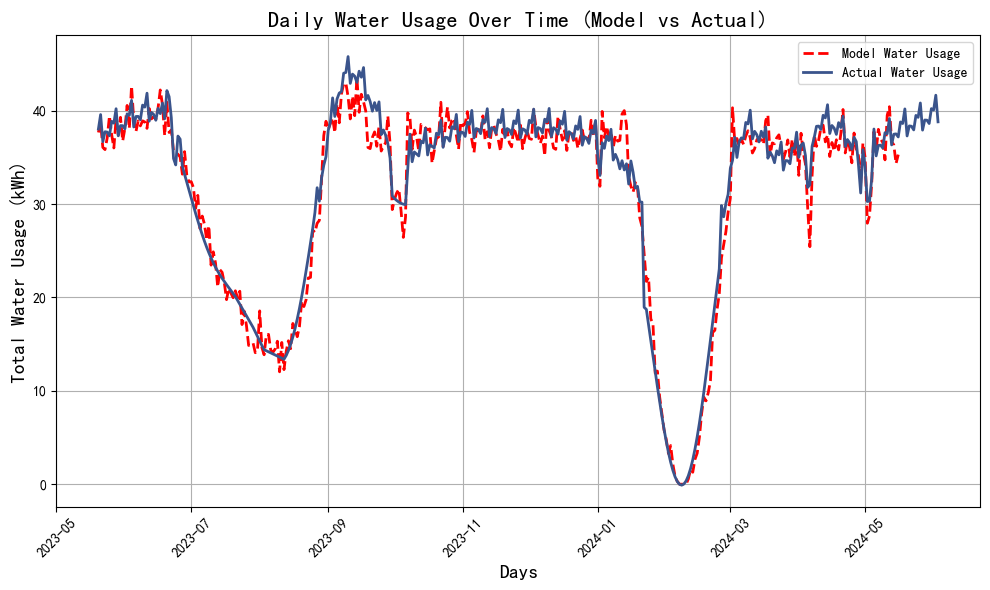

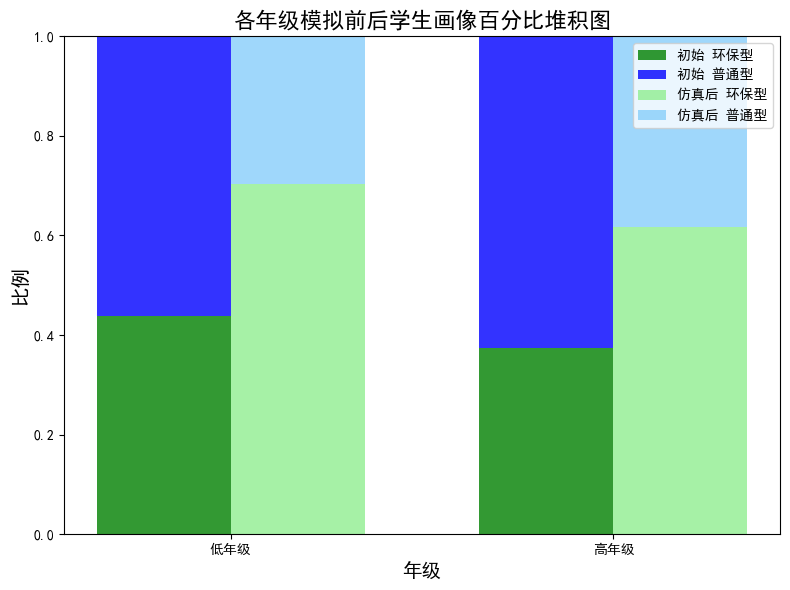

初始状态：
Profile  environmentalist    normal
Grade                              
低年级              0.439153  0.560847
高年级              0.374408  0.625592

仿真后状态：
Profile  environmentalist    normal
Grade                              
低年级              0.703704  0.296296
高年级              0.616114  0.383886


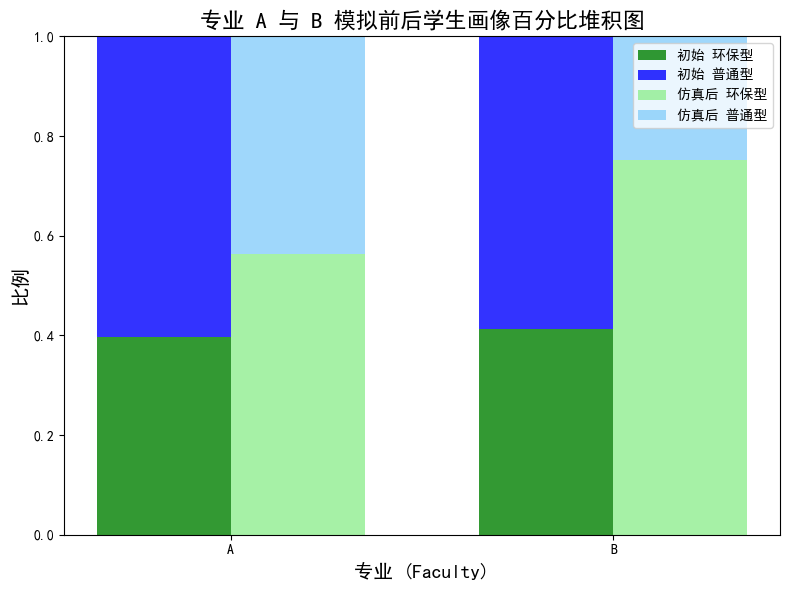

初始状态：
Profile  environmentalist    normal
Faculty                            
A                0.396985  0.603015
B                0.412935  0.587065

仿真后状态：
Profile  environmentalist    normal
Faculty                            
A                0.562814  0.437186
B                0.751244  0.248756


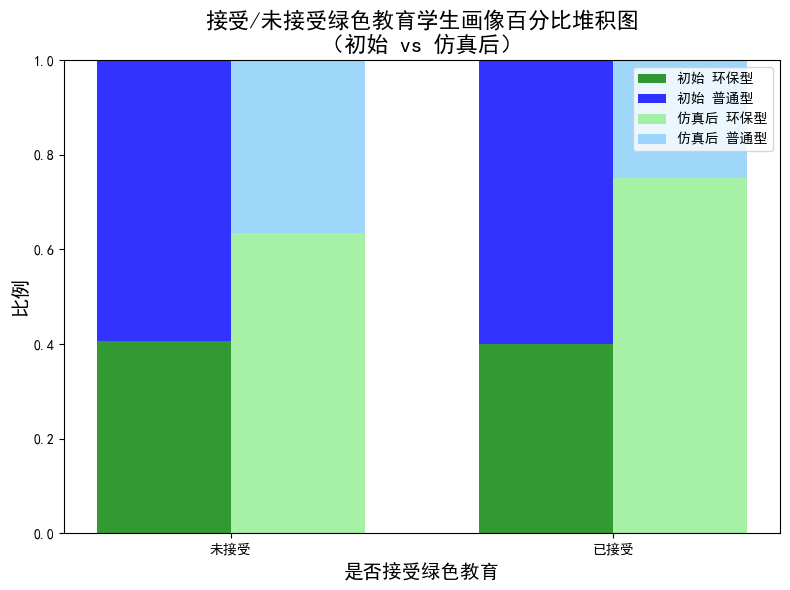

初始状态：
Profile         environmentalist   normal
GreenEducation                           
False                    0.40625  0.59375
True                     0.40000  0.60000

仿真后状态：
Profile         environmentalist    normal
GreenEducation                            
False                   0.634375  0.365625
True                    0.750000  0.250000


In [4]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 随机数
random.seed(42)
np.random.seed(42)


# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载实景数据
actual_usage_file_path = 'filled_actual_usage.csv'  # 替换为你的实景数据文件路径
actual_usage_data = pd.read_csv(actual_usage_file_path, index_col=None)
actual_usage_data['ds'] = pd.to_datetime(actual_usage_data['ds'])
actual_usage_data = actual_usage_data.set_index('ds')

# 只取实景数据前365天
actual_usage_data = actual_usage_data.iloc[:363]

# 运行模型
model = StudentModel(num_agents=400, 
                     start_date="2023-05-19", 
                     holiday_effects=holiday_effects, 
                     beta=5, 
                     normal_env_ratio=(6, 4), 
                     num_neighbors=20, 
                     c_d_ratio=(0.5, 0.5),
                     interaction_interval=90)

### c:d为1:1时，模型的行为基本上会倾向Normal，因为周围有更多的Normal类型


# 运行363天的模拟
for _ in range(363):
    model.step()  # 调用模型的step方法，检查是否需要进行交互
    model.datacollector.collect(model)  # 收集数据

# 获取代理变量数据并进行汇总
water_data = model.datacollector.get_agent_vars_dataframe()

# 按照步骤 (Step) 汇总每个代理的 daily_usage
daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量

# 将 step 转换为实际日期
daily_usage.index = [model.current_date - timedelta(days=(363 - step)) for step in daily_usage.index]  # 映射到实际日期
daily_usage.index.name = 'ds'  # 设置索引名称为 'ds'

model_data = daily_usage.to_frame()

# 可能需要调整日期范围，使两者对齐
model_data = model_data.join(actual_usage_data['actual_usage'], how='left')

# 可选：绘制每日用水量趋势图，包含模型数据和实景数据
plt.figure(figsize=(10, 6))

# 绘制模型数据
plt.plot(model_data.index, model_data['WaterUsage'], color='r', lw=2, linestyle='--', label='Model Water Usage')

# 绘制实景数据（如果有）
plt.plot(actual_usage_data.index, actual_usage_data['actual_usage'], color='#3A548C', lw=2, label='Actual Water Usage')

# 添加图例和标题
plt.title("Daily Water Usage Over Time (Model vs Actual)", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Total Water Usage (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图表
plt.legend()
plt.show()


import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 从 DataCollector 获取代理数据（假设索引为 (Step, AgentID)）
df = model.get_collected_data()

# 获取所有记录的 Step 值，初始状态对应最小 Step，最终状态对应最大 Step
steps = df.index.get_level_values(0)
initial_step = steps.min()
final_step = steps.max()

# 分别提取初始状态和最终状态的数据（按 Step 过滤）
initial_data = df.loc[df.index.get_level_values(0) == initial_step]
final_data = df.loc[df.index.get_level_values(0) == final_step]

# 按 Grade 和 Profile 聚合，计算比例（只关注年级）
init_group_grade = initial_data.groupby("Grade")["Profile"].value_counts(normalize=True).unstack().fillna(0)
final_group_grade = final_data.groupby("Grade")["Profile"].value_counts(normalize=True).unstack().fillna(0)

# 假设年级只有两类，例如："低年级" 和 "高年级"，并确保顺序一致
grades = ["低年级", "高年级"]
x = np.arange(len(grades))
bar_width = 0.35

# 提取各年级的比例数据
init_env = [init_group_grade.loc[g].get("environmentalist", 0) for g in grades]
init_normal = [init_group_grade.loc[g].get("normal", 0) for g in grades]

final_env = [final_group_grade.loc[g].get("environmentalist", 0) for g in grades]
final_normal = [final_group_grade.loc[g].get("normal", 0) for g in grades]

# 绘制百分比堆积图：每个年级有两个并排的堆积条：一个是初始状态，一个是仿真后状态
fig, ax = plt.subplots(figsize=(8, 6))

# 初始状态堆积条
ax.bar(x - bar_width/2, init_env, width=bar_width, label="初始 环保型", color="green", alpha=0.8)
ax.bar(x - bar_width/2, init_normal, width=bar_width, bottom=init_env, label="初始 普通型", color="blue", alpha=0.8)

# 仿真后状态堆积条
ax.bar(x + bar_width/2, final_env, width=bar_width, label="仿真后 环保型", color="lightgreen", alpha=0.8)
ax.bar(x + bar_width/2, final_normal, width=bar_width, bottom=final_env, label="仿真后 普通型", color="lightskyblue", alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(grades)
ax.set_ylim(0, 1)
ax.set_xlabel("年级", fontsize=14)
ax.set_ylabel("比例", fontsize=14)
ax.set_title("各年级模拟前后学生画像百分比堆积图", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

# 打印初始和最终状态的比例数据
print("初始状态：")
print(init_group_grade)
print("\n仿真后状态：")
print(final_group_grade)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 从 datacollector 获取代理数据，假设 DataFrame 的索引为 (Step, AgentID)
df = model.get_collected_data()

# 获取所有记录的 Step 值，初始状态对应最小 Step，最终状态对应最大 Step
steps = df.index.get_level_values(0)
initial_step = steps.min()
final_step = steps.max()

# 分别提取初始状态和最终状态的数据（按 Step 过滤）
initial_data = df.loc[df.index.get_level_values(0) == initial_step]
final_data = df.loc[df.index.get_level_values(0) == final_step]

# 按 Faculty 和 Profile 聚合，计算比例（这里只关注专业）
init_group = initial_data.groupby("Faculty")["Profile"].value_counts(normalize=True).unstack().fillna(0)
final_group = final_data.groupby("Faculty")["Profile"].value_counts(normalize=True).unstack().fillna(0)

# 保证专业排序一致（例如：["A", "B"]）
faculties = sorted(init_group.index)
x = np.arange(len(faculties))
bar_width = 0.35

# 提取各专业的比例数据
init_env = init_group.loc[faculties, "environmentalist"].values
init_normal = init_group.loc[faculties, "normal"].values

final_env = final_group.loc[faculties, "environmentalist"].values
final_normal = final_group.loc[faculties, "normal"].values

# 绘制百分比堆积图，每个专业有两个并排的堆积条：一个是初始状态，一个是仿真后状态
fig, ax = plt.subplots(figsize=(8, 6))

# 初始状态的堆积条
bar1 = ax.bar(x - bar_width/2, init_env, width=bar_width, label="初始 环保型", color="green", alpha=0.8)
bar2 = ax.bar(x - bar_width/2, init_normal, width=bar_width, bottom=init_env, label="初始 普通型", color="blue", alpha=0.8)

# 仿真后状态的堆积条
bar3 = ax.bar(x + bar_width/2, final_env, width=bar_width, label="仿真后 环保型", color="lightgreen", alpha=0.8)
bar4 = ax.bar(x + bar_width/2, final_normal, width=bar_width, bottom=final_env, label="仿真后 普通型", color="lightskyblue", alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels(faculties)
ax.set_ylim(0, 1)
ax.set_xlabel("专业 (Faculty)", fontsize=14)
ax.set_ylabel("比例", fontsize=14)
ax.set_title("专业 A 与 B 模拟前后学生画像百分比堆积图", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

# 打印初始和最终状态的比例数据
print("初始状态：")
print(init_group)
print("\n仿真后状态：")
print(final_group)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 从 DataCollector 获取代理数据（假设索引为 (Step, AgentID)）
df = model.get_collected_data()

# 获取所有记录的 Step 值，初始状态对应最小 Step，最终状态对应最大 Step
steps = df.index.get_level_values(0)
initial_step = steps.min()
final_step = steps.max()

# 分别提取初始状态和最终状态的数据（按 Step 过滤）
initial_data = df.loc[df.index.get_level_values(0) == initial_step]
final_data = df.loc[df.index.get_level_values(0) == final_step]

# 按 GreenEducation 和 Profile 聚合，计算比例
init_group = initial_data.groupby("GreenEducation")["Profile"].value_counts(normalize=True).unstack().fillna(0)
final_group = final_data.groupby("GreenEducation")["Profile"].value_counts(normalize=True).unstack().fillna(0)

# 定义接受绿色教育的分组，假设 False 表示未接受，True 表示已接受
groups = [False, True]
group_labels = {False: "未接受", True: "已接受"}
x = np.arange(len(groups))
bar_width = 0.35

# 提取各分组的比例数据，如果某一类型不存在则设为0
init_env = [init_group.loc[g].get("environmentalist", 0) for g in groups]
init_normal = [init_group.loc[g].get("normal", 0) for g in groups]

final_env = [final_group.loc[g].get("environmentalist", 0) for g in groups]
final_normal = [final_group.loc[g].get("normal", 0) for g in groups]

# 绘制百分比堆积图：每个分组有两个并排的堆积条（初始状态和仿真后状态）
fig, ax = plt.subplots(figsize=(8, 6))

# 初始状态堆积条：左侧
ax.bar(x - bar_width/2, init_env, width=bar_width, label="初始 环保型", color="green", alpha=0.8)
ax.bar(x - bar_width/2, init_normal, width=bar_width, bottom=init_env, label="初始 普通型", color="blue", alpha=0.8)

# 仿真后状态堆积条：右侧
ax.bar(x + bar_width/2, final_env, width=bar_width, label="仿真后 环保型", color="lightgreen", alpha=0.8)
ax.bar(x + bar_width/2, final_normal, width=bar_width, bottom=final_env, label="仿真后 普通型", color="lightskyblue", alpha=0.8)

ax.set_xticks(x)
ax.set_xticklabels([group_labels[g] for g in groups])
ax.set_ylim(0, 1)
ax.set_xlabel("是否接受绿色教育", fontsize=14)
ax.set_ylabel("比例", fontsize=14)
ax.set_title("接受/未接受绿色教育学生画像百分比堆积图\n（初始 vs 仿真后）", fontsize=16)
ax.legend()
plt.tight_layout()
plt.show()

# 打印初始和最终状态的比例数据
print("初始状态：")
print(init_group)
print("\n仿真后状态：")
print(final_group)






In [16]:
# 最后一天的waterdata的profile比例
water_data = model.get_collected_data()
water_data = water_data.reset_index()
water_data = water_data[water_data.Step == 363]
water_data = water_data.groupby("Profile").size()
print(water_data)
# normal比例
normal_ratio = water_data["normal"] / water_data.sum()
print(normal_ratio)

Profile
environmentalist    249
normal              151
dtype: int64
0.3775


## 3.2 调整num_agents以最小化误差

In [12]:
from sklearn.metrics import mean_squared_error

def calculate_mse(model_data, actual_data):
    return mean_squared_error(actual_data.dropna(), model_data.dropna())


In [13]:
# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 搜索范围
num_agents_range = range(270, 301, 5)  # 从100到2000，每次递增100

# 用于存储误差
errors = []

for num_agents in num_agents_range:
    # 运行模型
    model = StudentModel(num_agents=num_agents, 
                         start_date="2023-05-19", 
                         holiday_effects=holiday_effects, 
                         beta=0, 
                         normal_env_ratio=(5, 5), 
                         num_neighbors=10, 
                         c_d_ratio=(0.3, 0.7),
                         interaction_interval=360)

    # 模拟运行365天
    for _ in range(363):
        model.step()
        model.datacollector.collect(model)

    # 获取模型数据并对齐日期
    water_data = model.datacollector.get_agent_vars_dataframe()
    daily_usage = water_data.groupby("Step")["WaterUsage"].sum() / 1000
    daily_usage.index = [model.current_date - timedelta(days=(363 - step)) for step in daily_usage.index]
    daily_usage.index.name = 'ds'
    model_data = daily_usage.to_frame()
        
    # 计算误差（与实际数据对齐）
    model_data = model_data.join(actual_usage_data['actual_usage'], how='left')
    model_data['actual_usage']=model_data['actual_usage'].fillna(model_data['actual_usage'].rolling(10, min_periods=1).mean())

    mse = calculate_mse(model_data['WaterUsage'], model_data['actual_usage'])
    errors.append((num_agents, mse))

    print(f"num_agents={num_agents}, MSE={mse}")


num_agents=270, MSE=10.750290841449216
num_agents=275, MSE=7.341973370698547
num_agents=280, MSE=5.9628861421689034
num_agents=285, MSE=4.790131204813584
num_agents=290, MSE=6.359937349197142
num_agents=295, MSE=5.737849722382659
num_agents=300, MSE=5.579972567919978


In [14]:
# 找到最优 num_agents
optimal_num_agents, min_error = min(errors, key=lambda x: x[1])
print(f"最优 num_agents={optimal_num_agents}, 最小误差={min_error}")


最优 num_agents=285, 最小误差=4.790131204813584


In [5]:
# 计算R2分数
from sklearn.metrics import r2_score
model_data['actual_usage']=model_data['actual_usage'].fillna(model_data['actual_usage'].rolling(10, min_periods=1).mean())

# 计算R2分数
r2 = r2_score(model_data['actual_usage'], model_data['WaterUsage'])
print(f"R2 Score: {r2:.4f}")

R2 Score: 0.9588


In [ ]:
# 提取 num_agents 和误差
num_agents_list, mse_list = zip(*errors)

# 绘制曲线
plt.figure(figsize=(10, 6))
plt.plot(num_agents_list, mse_list, marker='o', linestyle='-', color='b')
plt.title("Error vs. Number of Agents", fontsize=16)
plt.xlabel("Number of Agents", fontsize=14)
plt.ylabel("Mean Squared Error (MSE)", fontsize=14)
plt.grid(True)
plt.xticks(num_agents_list, rotation=45)
plt.tight_layout()

# 显示图表
plt.show()


# 4.Plot AND Discussion

## 4.1 不同画像用户的用水量

In [18]:
# 获取数据收集器记录的数据
df = model.datacollector.get_agent_vars_dataframe()

# 对于环境型学生，先筛选出 Profile 为 "environmentalist" 且 WaterUsage > 0 的记录
env_data = df[(df["Profile"] == "environmentalist") & (df["WaterUsage"] > 0)]
# 按 Step 分组计算每天的平均用水量
env_daily_mean = env_data.groupby("Step")["WaterUsage"].mean()
# 计算363天内环境型学生的总体平均用水量
overall_env_mean = env_daily_mean.mean()
print("363天内环境型学生的总体平均用水量：", overall_env_mean)

# 对普通学生进行同样的处理：过滤掉用水量为0的记录
normal_data = df[(df["Profile"] == "normal") & (df["WaterUsage"] > 0)]
normal_daily_mean = normal_data.groupby("Step")["WaterUsage"].mean()
overall_normal_mean = normal_daily_mean.mean()
print("363天内普通学生的总体平均用水量：", overall_normal_mean)


363天内环境型学生的总体平均用水量： 95.17712256294458
363天内普通学生的总体平均用水量： 123.78947715457237


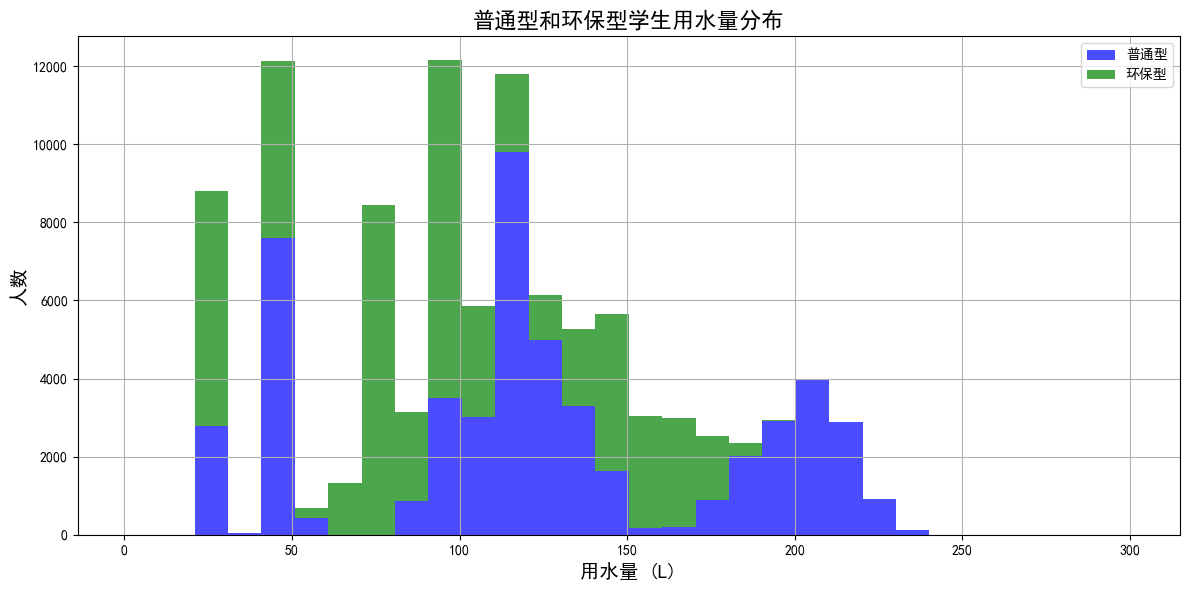

In [19]:
# 绘制water_data的用水量分布图和箱线图

# 按照代理人的Profile筛选数据
normal_data = water_data[water_data["Profile"] == "normal"]
env_data = water_data[water_data["Profile"] == "environmentalist"]

# 绘制用水量分布图（以堆积图的形式），排除0值
plt.figure(figsize=(12, 6))
plt.hist([normal_data["WaterUsage"], env_data["WaterUsage"]], bins=30, stacked=True, label=["普通型", "环保型"], range=(1, 300), color=["blue", "green"], alpha=0.7)
plt.title("普通型和环保型学生用水量分布", fontsize=16)
plt.xlabel("用水量 (L)", fontsize=14)
plt.ylabel("人数", fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 绘制箱线图


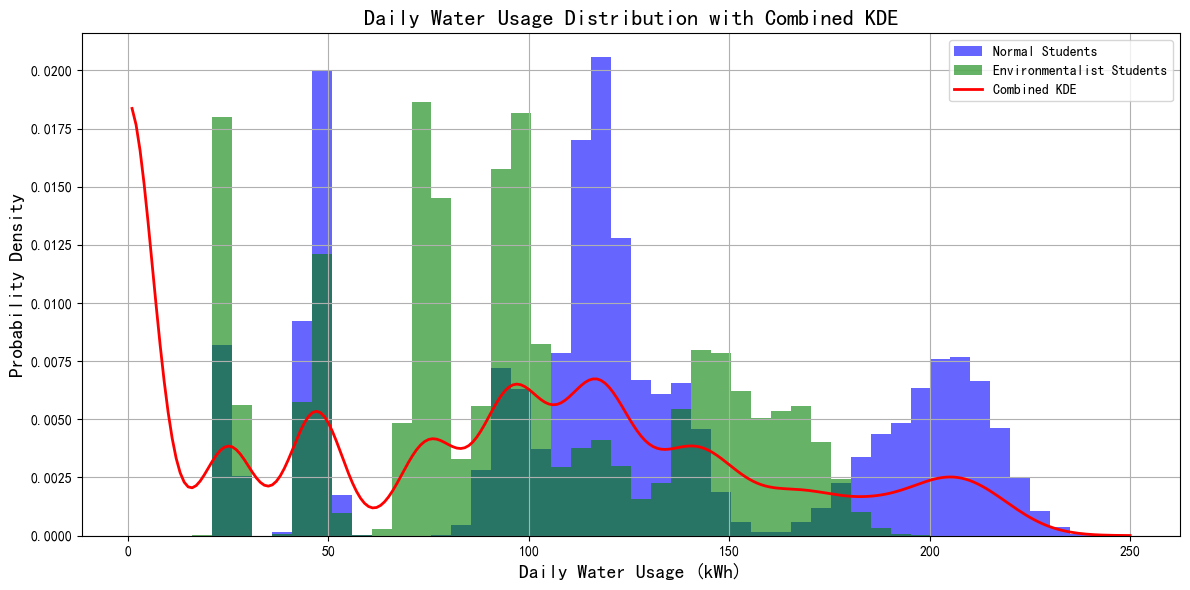

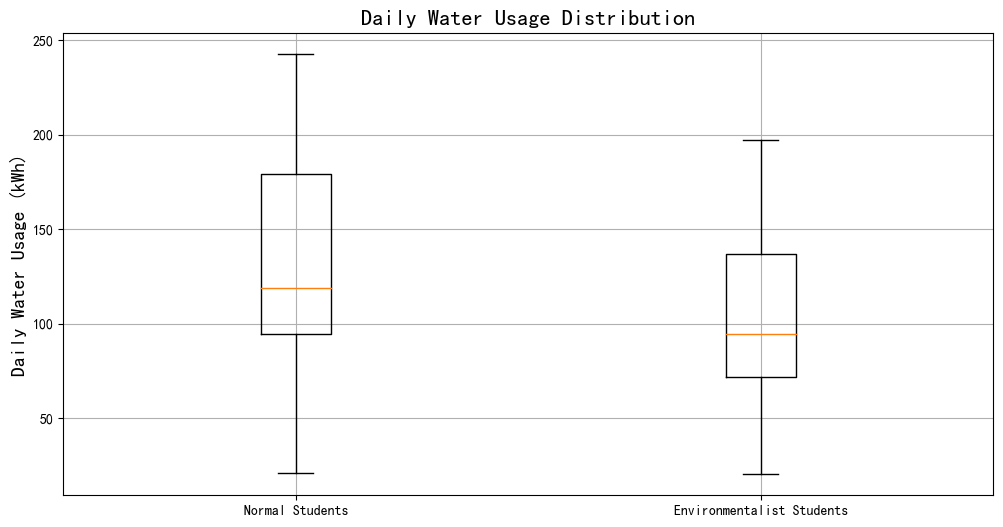

In [20]:
# 绘制water_data的用水量分布图和箱线图

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 根据代理人的 Profile 筛选数据
normal_data = water_data[water_data["Profile"] == "normal"]
env_data = water_data[water_data["Profile"] == "environmentalist"]

# 绘制直方图，归一化为概率密度（density=True），排除0值
plt.figure(figsize=(12, 6))
plt.hist(normal_data["WaterUsage"], bins=50, alpha=0.6, label='Normal Students', color='blue', range=(1, 250), density=True)
plt.hist(env_data["WaterUsage"], bins=50, alpha=0.6, label='Environmentalist Students', color='green', range=(1, 250), density=True)

# 合并两类数据
combined_usage = np.concatenate([normal_data["WaterUsage"].values, env_data["WaterUsage"].values])

# 计算整体 KDE
x = np.linspace(1, 250, 250)
kde_combined = gaussian_kde(combined_usage)
plt.plot(x, kde_combined(x), color='red', lw=2, label="Combined KDE")

plt.xlabel("Daily Water Usage (kWh)", fontsize=14)
plt.ylabel("Probability Density", fontsize=14)
plt.title("Daily Water Usage Distribution with Combined KDE", fontsize=16)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()





normal_data_1 = normal_data[normal_data["WaterUsage"] > 0]
env_data_1 = env_data[env_data["WaterUsage"] > 0]
# 绘制用水量箱线图，排除0值
plt.figure(figsize=(12, 6))
plt.boxplot([normal_data_1["WaterUsage"], env_data_1["WaterUsage"]], labels=['Normal Students', 'Environmentalist Students'])
plt.ylabel("Daily Water Usage (kWh)", fontsize=14)
plt.title("Daily Water Usage Distribution", fontsize=16)
plt.grid(True)
plt.show()





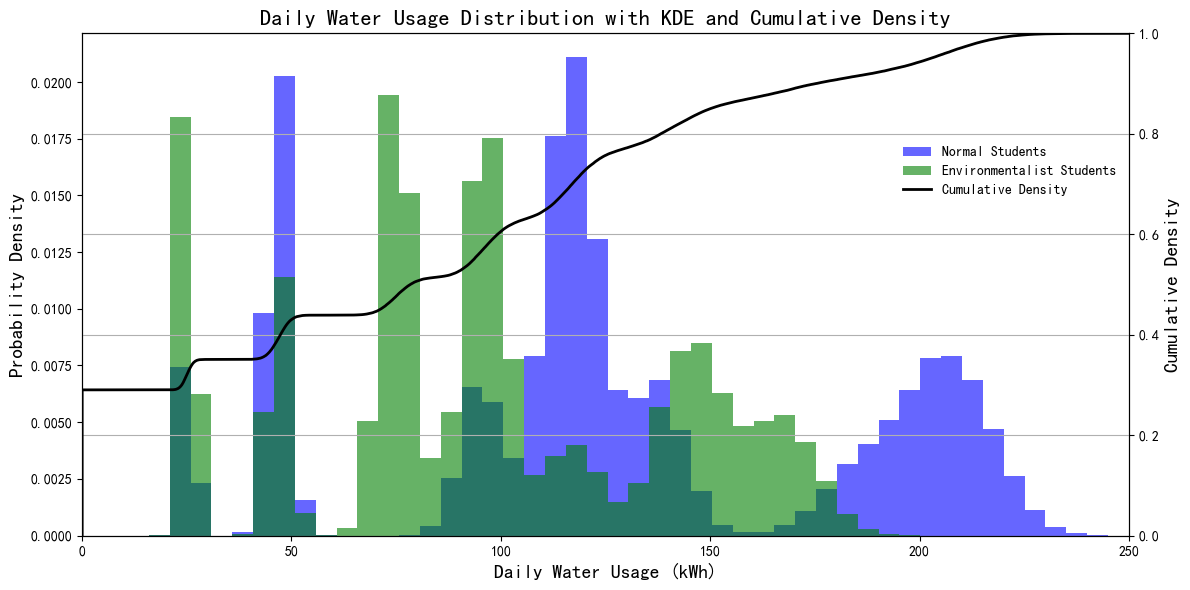

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# 根据代理人的 Profile 筛选数据
normal_data = water_data[water_data["Profile"] == "normal"]
env_data = water_data[water_data["Profile"] == "environmentalist"]

# 绘制直方图，归一化为概率密度（density=True），排除0值
plt.figure(figsize=(12, 6))
plt.hist(normal_data["WaterUsage"], bins=50, alpha=0.6, label='Normal Students', 
         color='blue', range=(1, 250), density=True)
plt.hist(env_data["WaterUsage"], bins=50, alpha=0.6, label='Environmentalist Students', 
         color='green', range=(1, 250), density=True)

# 获取当前坐标轴，并设置X轴从0开始
ax1 = plt.gca()
ax1.set_xlim(0, 250)

# 合并两类数据
combined_usage = np.concatenate([normal_data["WaterUsage"].values, env_data["WaterUsage"].values])

# 计算经验累积分布函数（ECDF）
sorted_usage = np.sort(combined_usage)
cdf = np.arange(1, len(sorted_usage) + 1) / len(sorted_usage)

# 创建第二个 y 轴，用于显示累计密度（累积分布）曲线
ax2 = ax1.twinx()
ax2.plot(sorted_usage, cdf, color='black', lw=2, label="Cumulative Density")
ax2.set_ylabel("Cumulative Density", fontsize=14)
ax2.set_ylim(0, 1)

# 设置标签和标题
ax1.set_xlabel("Daily Water Usage (kWh)", fontsize=14)
ax1.set_ylabel("Probability Density", fontsize=14)
plt.title("Daily Water Usage Distribution with KDE and Cumulative Density", fontsize=16)

# 合并两个坐标轴的图例，并将图例放在图下方且不显示框线
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc='upper right', 
           bbox_to_anchor=(1, 0.8), ncol=1, frameon=False)

plt.grid(True)
plt.tight_layout()
plt.show()


## 4.2平均用水量的时间变化

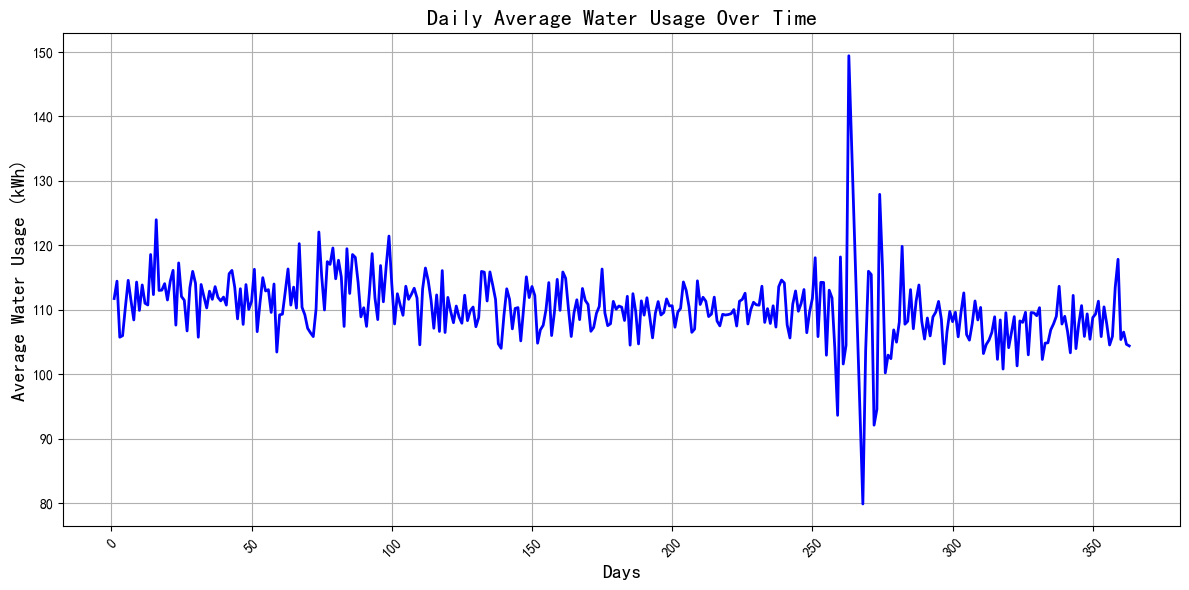

Average Trend: -0.0205 m3/day


In [21]:
# 随着时间平均用水量的变化（非0），并绘制每日平均用水量的趋势图

# 计算每日平均用水量
daily_mean = df[df["WaterUsage"] > 0].groupby("Step")["WaterUsage"].mean()

# 绘制每日平均用水量的趋势图,并绘制趋势斜率
# 计算趋势的斜率，并将上述趋势绘图在上面同一张图上
trend = daily_mean.diff().mean()
plt.figure(figsize=(12, 6))
plt.plot(daily_mean.index, daily_mean, color='b', lw=2)
plt.title("Daily Average Water Usage Over Time", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Average Water Usage (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 打印平均趋势
print(f"Average Trend: {trend:.4f} m3/day")








## 4.3 在校和不在校的学生比例

Total Days: 145200
Zero Water Usage Days: 42010 (28.93%)
Non-Zero Water Usage Days: 103190 (71.07%)


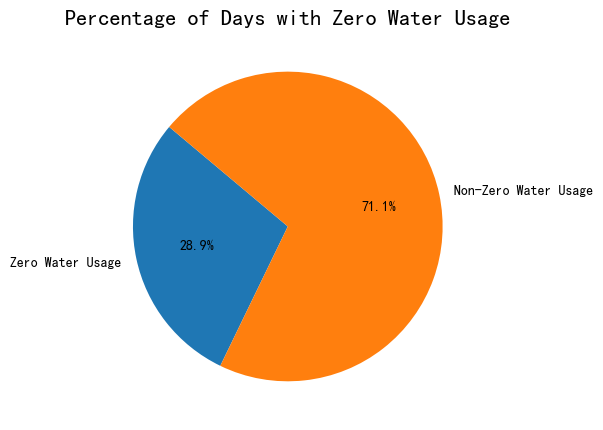

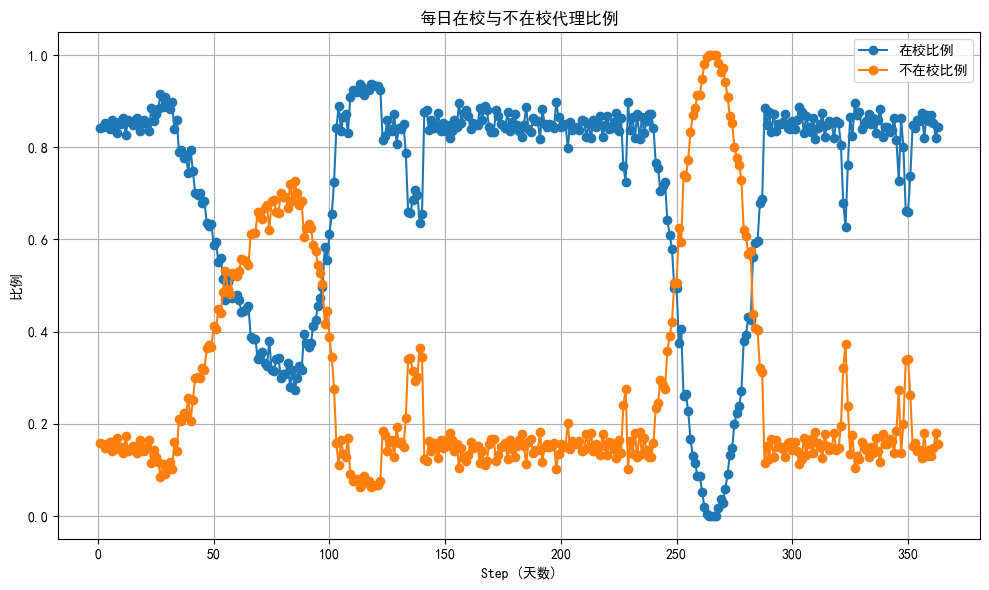

In [22]:
# 打印363天中用水为0和非0的数量比例
water_data = model.datacollector.get_agent_vars_dataframe()
zero_days = water_data[water_data["WaterUsage"] == 0].shape[0]
non_zero_days = water_data[water_data["WaterUsage"] > 0].shape[0]
total_days = zero_days + non_zero_days
print(f"Total Days: {total_days}")
print(f"Zero Water Usage Days: {zero_days} ({zero_days/total_days:.2%})")
print(f"Non-Zero Water Usage Days: {non_zero_days} ({non_zero_days/total_days:.2%})")
# 绘制有没有用水天数的百分比图
plt.figure(figsize=(6, 6))
plt.pie([zero_days, non_zero_days], labels=["Zero Water Usage", "Non-Zero Water Usage"], autopct='%1.1f%%', startangle=140)
plt.title("Percentage of Days with Zero Water Usage", fontsize=16)
plt.tight_layout()
plt.show()

# 添加 InSchool 列到 water_data
water_data["InSchool"] = water_data["WaterUsage"] > 0

# 可以通过每日用水量是否为0绘制每日的在校比例和不在校比例
# 假设 water_data 已经包含了从 DataCollector 获取的数据，并添加了 InSchool 列
# water_data 的索引为 (Step, AgentID)

# 1. 按 Step 分组，统计每一天 InSchool 的 True/False 数量
daily_counts = water_data.groupby("Step")["InSchool"].value_counts().unstack().fillna(0)

# 2. 计算每一天的总代理数
daily_counts["Total"] = daily_counts.sum(axis=1)

# 3. 计算在校（True）和不在校（False）的比例
daily_counts["InSchool_ratio"] = daily_counts[True] / daily_counts["Total"]
daily_counts["OutOfSchool_ratio"] = daily_counts[False] / daily_counts["Total"]

# 4. 绘制每日在校和不在校的比例折线图
plt.figure(figsize=(10, 6))
plt.plot(daily_counts.index, daily_counts["InSchool_ratio"], marker='o', label="在校比例")
plt.plot(daily_counts.index, daily_counts["OutOfSchool_ratio"], marker='o', label="不在校比例")
plt.xlabel("Step (天数)")
plt.ylabel("比例")
plt.title("每日在校与不在校代理比例")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()








## 4.4 各个学生类型的Profile图

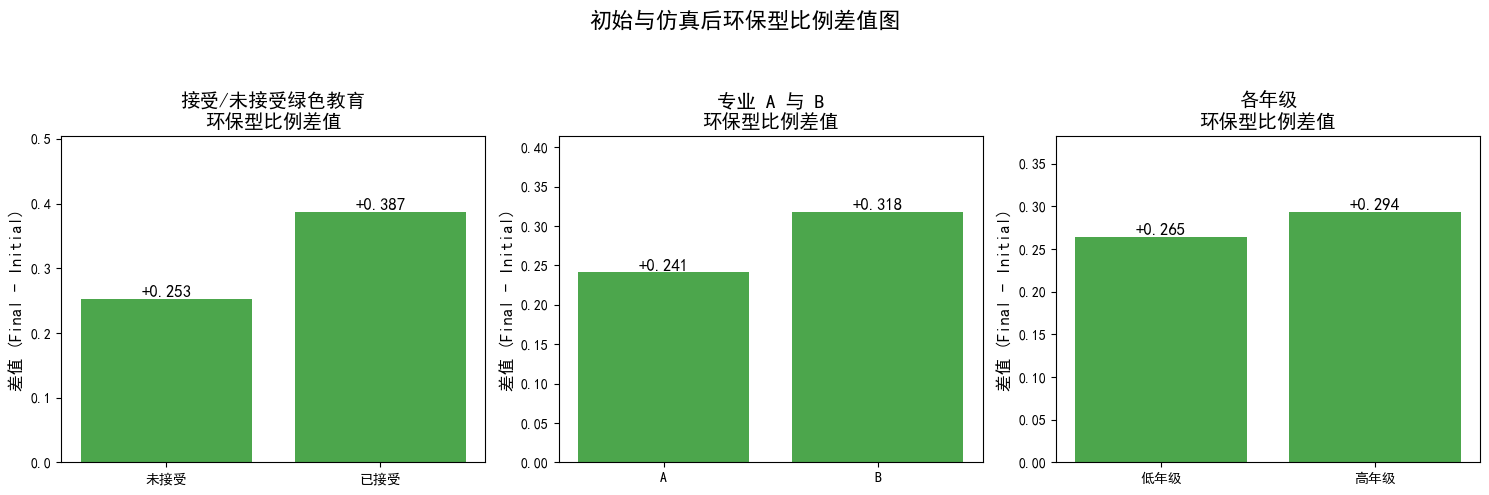

In [36]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 数据整理：只关注环保型比例
# 1) 是否接受绿色教育
data_greened = {
    "GreenEducation": ["未接受", "已接受"],
    "Initial": [0.40625, 0.40000],
    "Final": [0.659375, 0.787500]
}
df_greened = pd.DataFrame(data_greened)
df_greened["Diff"] = df_greened["Final"] - df_greened["Initial"]

# 2) 专业
data_faculty = {
    "Faculty": ["A", "B"],
    "Initial": [0.396985, 0.412935],
    "Final": [0.638191, 0.731343]
}
df_faculty = pd.DataFrame(data_faculty)
df_faculty["Diff"] = df_faculty["Final"] - df_faculty["Initial"]

# 3) 年级
data_grade = {
    "Grade": ["低年级", "高年级"],
    "Initial": [0.439153, 0.374408],
    "Final": [0.703704, 0.668246]
}
df_grade = pd.DataFrame(data_grade)
df_grade["Diff"] = df_grade["Final"] - df_grade["Initial"]

# 绘制三个子图：差值柱状图
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# (1) 是否接受绿色教育
axes[0].bar(df_greened["GreenEducation"], df_greened["Diff"], color="green", alpha=0.7)
for i, row in df_greened.iterrows():
    axes[0].text(i, row["Diff"], f"{row['Diff']:+.3f}", ha='center', va='bottom', fontsize=12)
axes[0].set_title("接受/未接受绿色教育\n环保型比例差值", fontsize=14)
axes[0].set_ylabel("差值 (Final - Initial)", fontsize=12)
axes[0].set_ylim(0, max(df_greened["Diff"])*1.3)

# (2) 专业
axes[1].bar(df_faculty["Faculty"], df_faculty["Diff"], color="green", alpha=0.7)
for i, row in df_faculty.iterrows():
    axes[1].text(i, row["Diff"], f"{row['Diff']:+.3f}", ha='center', va='bottom', fontsize=12)
axes[1].set_title("专业 A 与 B\n环保型比例差值", fontsize=14)
axes[1].set_ylabel("差值 (Final - Initial)", fontsize=12)
axes[1].set_ylim(0, max(df_faculty["Diff"])*1.3)

# (3) 年级
axes[2].bar(df_grade["Grade"], df_grade["Diff"], color="green", alpha=0.7)
for i, row in df_grade.iterrows():
    axes[2].text(i, row["Diff"], f"{row['Diff']:+.3f}", ha='center', va='bottom', fontsize=12)
axes[2].set_title("各年级\n环保型比例差值", fontsize=14)
axes[2].set_ylabel("差值 (Final - Initial)", fontsize=12)
axes[2].set_ylim(0, max(df_grade["Diff"])*1.3)

plt.suptitle("初始与仿真后环保型比例差值图", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


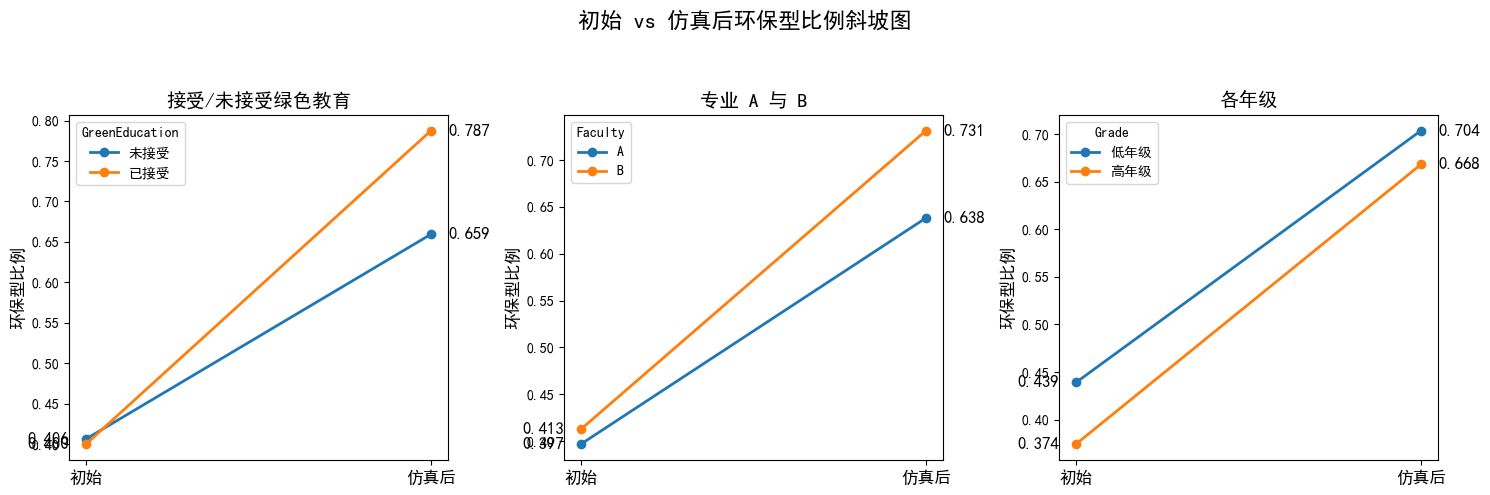

In [37]:
import matplotlib.pyplot as plt

# 绘制斜坡图的子图，共3个
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# x 轴位置：0 表示初始，1 表示仿真后
x_vals = [0, 1]

# (1) 是否接受绿色教育
for i, row in df_greened.iterrows():
    axes[0].plot(x_vals, [row["Initial"], row["Final"]], marker="o", label=row["GreenEducation"], lw=2)
    axes[0].text(0 - 0.05, row["Initial"], f"{row['Initial']:.3f}", ha="right", va="center", fontsize=12)
    axes[0].text(1 + 0.05, row["Final"], f"{row['Final']:.3f}", ha="left", va="center", fontsize=12)
axes[0].set_xticks(x_vals)
axes[0].set_xticklabels(["初始", "仿真后"], fontsize=12)
axes[0].set_title("接受/未接受绿色教育", fontsize=14)
axes[0].set_ylabel("环保型比例", fontsize=12)
axes[0].legend(title="GreenEducation", loc="upper left", fontsize=10)

# (2) 专业
for i, row in df_faculty.iterrows():
    axes[1].plot(x_vals, [row["Initial"], row["Final"]], marker="o", label=row["Faculty"], lw=2)
    axes[1].text(0 - 0.05, row["Initial"], f"{row['Initial']:.3f}", ha="right", va="center", fontsize=12)
    axes[1].text(1 + 0.05, row["Final"], f"{row['Final']:.3f}", ha="left", va="center", fontsize=12)
axes[1].set_xticks(x_vals)
axes[1].set_xticklabels(["初始", "仿真后"], fontsize=12)
axes[1].set_title("专业 A 与 B", fontsize=14)
axes[1].set_ylabel("环保型比例", fontsize=12)
axes[1].legend(title="Faculty", loc="upper left", fontsize=10)

# (3) 年级
for i, row in df_grade.iterrows():
    axes[2].plot(x_vals, [row["Initial"], row["Final"]], marker="o", label=row["Grade"], lw=2)
    axes[2].text(0 - 0.05, row["Initial"], f"{row['Initial']:.3f}", ha="right", va="center", fontsize=12)
    axes[2].text(1 + 0.05, row["Final"], f"{row['Final']:.3f}", ha="left", va="center", fontsize=12)
axes[2].set_xticks(x_vals)
axes[2].set_xticklabels(["初始", "仿真后"], fontsize=12)
axes[2].set_title("各年级", fontsize=14)
axes[2].set_ylabel("环保型比例", fontsize=12)
axes[2].legend(title="Grade", loc="upper left", fontsize=10)

plt.suptitle("初始 vs 仿真后环保型比例斜坡图", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


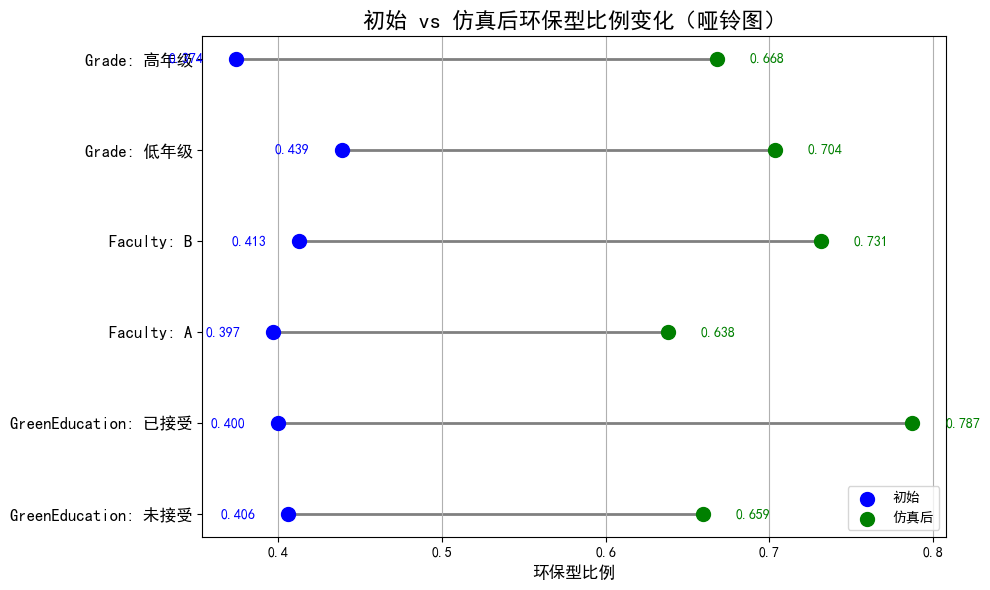

In [40]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# 合并三种分类的数据，共6个类别：
data = {
    "Category": [
        "GreenEducation: 未接受", 
        "GreenEducation: 已接受", 
        "Faculty: A", 
        "Faculty: B", 
        "Grade: 低年级", 
        "Grade: 高年级"
    ],
    "Initial": [0.40625, 0.40000, 0.396985, 0.412935, 0.439153, 0.374408],
    "Final":   [0.659375, 0.787500, 0.638191, 0.731343, 0.703704, 0.668246]
}

df_all = pd.DataFrame(data)

# 创建图形
fig, ax = plt.subplots(figsize=(10, 6))

# 对每个类别画出初始与仿真后之间的连线
for i, row in df_all.iterrows():
    ax.plot([row["Initial"], row["Final"]], [i, i], color="gray", lw=2, zorder=1)

# 绘制初始和仿真后两个状态的散点
ax.scatter(df_all["Initial"], np.arange(len(df_all)), color="blue", s=100, label="初始", zorder=2)
ax.scatter(df_all["Final"], np.arange(len(df_all)), color="green", s=100, label="仿真后", zorder=2)

# 在两侧标注具体数值
for i, row in df_all.iterrows():
    ax.text(row["Initial"] - 0.02, i, f"{row['Initial']:.3f}", va="center", ha="right", fontsize=10, color="blue")
    ax.text(row["Final"] + 0.02, i, f"{row['Final']:.3f}", va="center", ha="left", fontsize=10, color="green")

# 设置y轴标签及标题
ax.set_yticks(np.arange(len(df_all)))
ax.set_yticklabels(df_all["Category"], fontsize=12)
ax.set_xlabel("环保型比例", fontsize=12)
ax.set_title("初始 vs 仿真后环保型比例变化（哑铃图）", fontsize=16)
ax.legend(loc="lower right")
ax.grid(axis="x")

plt.tight_layout()
plt.show()


# 5. Scenario Analysis

## 5.1 保存最模型的最大最小范围

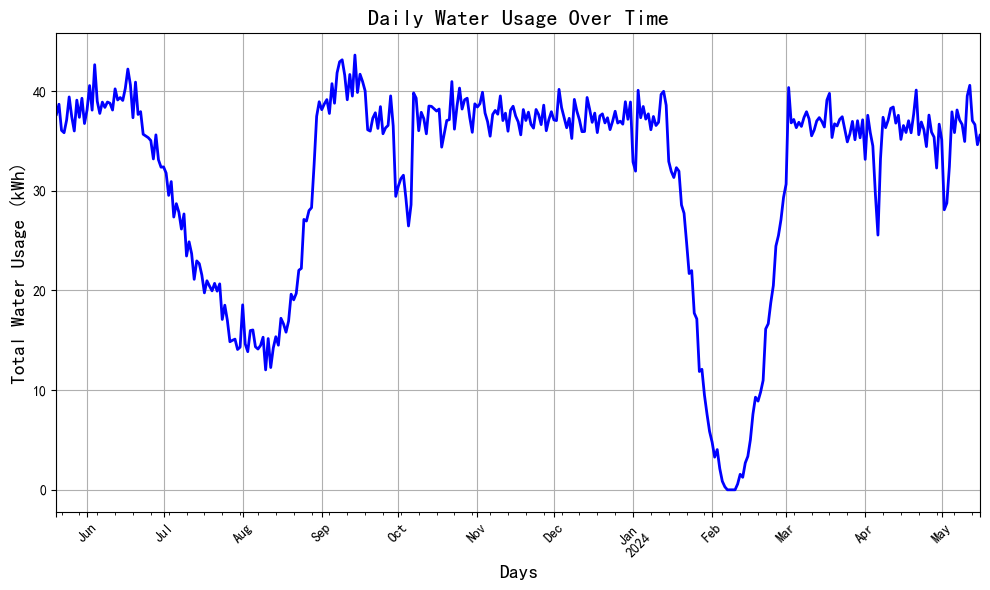

In [48]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 运行模型
model = StudentModel(num_agents=400, 
                     start_date="2023-05-19", 
                     holiday_effects=holiday_effects, 
                     beta=7, 
                     normal_env_ratio=(6, 4), 
                     num_neighbors=20, 
                     c_d_ratio=(0.5, 0.5),
                     interaction_interval=90)

# 运行365天的模拟
for _ in range(363):
    model.step()  # 调用模型的step方法，检查是否需要进行交互
    model.datacollector.collect(model)  # 收集数据

# 获取代理变量数据并进行汇总
water_data = model.datacollector.get_agent_vars_dataframe()

# 按照步骤 (Step) 汇总每个代理的 daily_usage
daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量
# 将 step 转换为实际日期
daily_usage.index = [model.current_date - timedelta(days=(363 - step)) for step in daily_usage.index]  # 映射到实际日期
daily_usage.index.name = 'ds'  # 设置索引名称为 'ds'
# 将结果保存到 CSV 文件
daily_usage.to_csv("baseline_daily_usage_df_baseline.csv")

# 可选：绘制每日用水量趋势图
plt.figure(figsize=(10, 6))
daily_usage.plot(kind="line", color='b', lw=2)  # 蓝色线条，宽度为2
plt.title("Daily Water Usage Over Time", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Total Water Usage (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图表
plt.show()


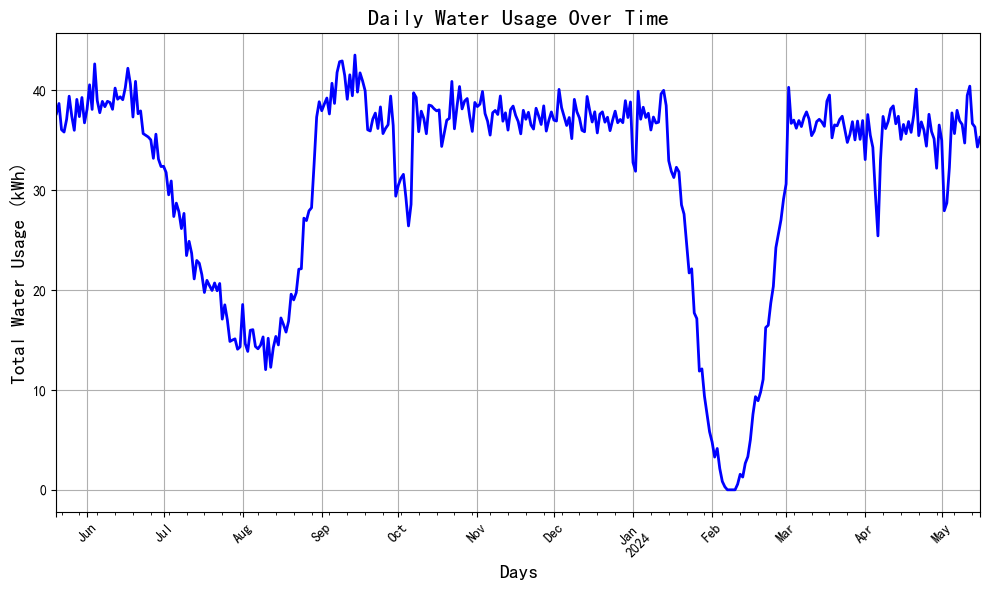

In [31]:
# 获取代理变量数据并进行汇总
water_data = model.datacollector.get_agent_vars_dataframe()

# 按照步骤 (Step) 汇总每个代理的 daily_usage
daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量
# 将 step 转换为实际日期
daily_usage.index = [model.current_date - timedelta(days=(363 - step)) for step in daily_usage.index]  # 映射到实际日期
daily_usage.index.name = 'ds'  # 设置索引名称为 'ds'
# 将结果保存到 CSV 文件
daily_usage.to_csv("baseline_daily_usage_df_baseline.csv")

# 可选：绘制每日用水量趋势图
plt.figure(figsize=(10, 6))
daily_usage.plot(kind="line", color='b', lw=2)  # 蓝色线条，宽度为2
plt.title("Daily Water Usage Over Time", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Total Water Usage (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图表
plt.show()

## 5.2 确定baseline并尝试画图

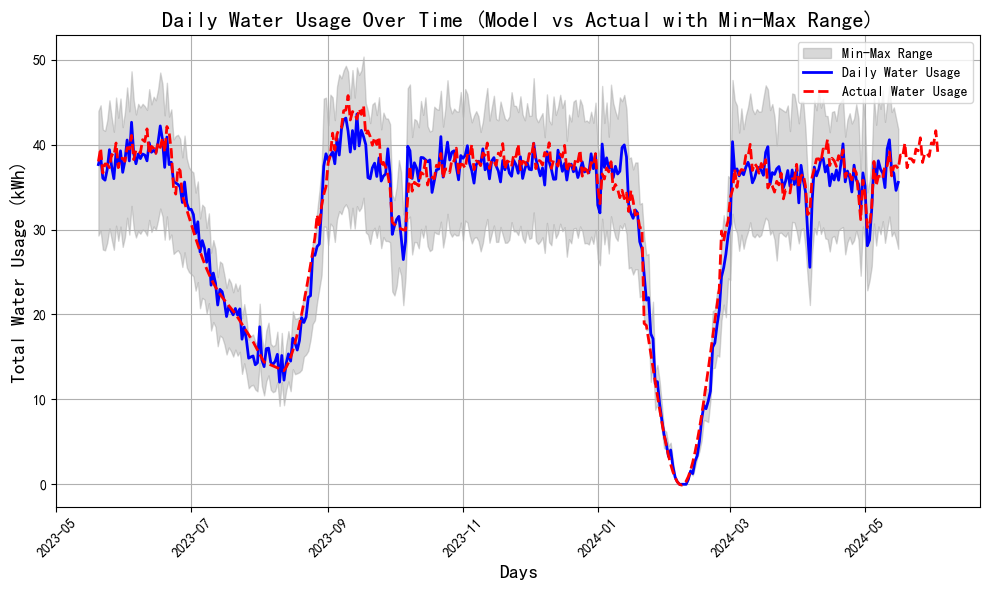

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# 固定随机种子以保证结果可重复
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载最大值和最小值文件
max_file_path = 'baseline_daily_usage_df_max.csv'  # 替换为你的最大值文件路径
min_file_path = 'baseline_daily_usage_df_min.csv'  # 替换为你的最小值文件路径

# 读取最大值和最小值数据
max_values = pd.read_csv(max_file_path, index_col=0)
min_values = pd.read_csv(min_file_path, index_col=0)

# 加载真实用水数据
actual_usage_file_path = 'filled_actual_usage.csv'  # 替换为你的真实数据文件路径
actual_usage_data = pd.read_csv(actual_usage_file_path, index_col=None)
actual_usage_data['ds'] = pd.to_datetime(actual_usage_data['ds'])
actual_usage_data = actual_usage_data.set_index('ds')
# 只取实景数据前363天
actual_usage_data = actual_usage_data.iloc[:363]


# 运行模型
model = StudentModel(num_agents=400, 
                     start_date="2023-05-19", 
                     holiday_effects=holiday_effects, 
                     beta=7.0, 
                     normal_env_ratio=(6, 4), 
                     num_neighbors=20, 
                     c_d_ratio=(0.5, 0.5),
                     interaction_interval=90)

# 运行363天的模拟
for _ in range(363):
    model.step()  # 调用模型的step方法，检查是否需要进行交互
    model.datacollector.collect(model)  # 收集数据

# 获取代理变量数据并进行汇总
water_data = model.datacollector.get_agent_vars_dataframe()

# 按照步骤 (Step) 汇总每个代理的 daily_usage
daily_usage = water_data.groupby("Step")["WaterUsage"].sum()/1000  # 获取该天的总用水量
# 将 step 转换为实际日期
daily_usage.index = [model.current_date - timedelta(days=(363 - step)) for step in daily_usage.index]  # 映射到实际日期
daily_usage.index.name = 'ds'  # 设置索引名称为 'ds'
# 获取最大值和最小值
max_daily_usage = max_values['WaterUsage']
min_daily_usage = min_values['WaterUsage']

# 可选：绘制每日用水量趋势图
plt.figure(figsize=(10, 6))

# 绘制阴影区域（最大值和最小值之间的区域）
plt.fill_between(daily_usage.index, min_daily_usage, max_daily_usage, color='gray', alpha=0.3, label='Min-Max Range')

# 绘制正常的每日用水量数据
plt.plot(daily_usage.index, daily_usage, color='b', lw=2, label='Daily Water Usage')
# 绘制真实用水量数据
plt.plot(actual_usage_data.index, actual_usage_data['actual_usage'], color='r', lw=2, linestyle='--', label='Actual Water Usage')

# 添加图例和标题
plt.title("Daily Water Usage Over Time (Model vs Actual with Min-Max Range)", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Total Water Usage (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# 显示图表
plt.legend()
plt.show()

In [16]:
# 取最大值的平均值与baseline平均值对比百分比
max_daily_usage_mean = max_daily_usage.mean()
baseline_daily_usage_mean = daily_usage.mean()
diff_percentage = (max_daily_usage_mean - baseline_daily_usage_mean) / baseline_daily_usage_mean
print(f"Max Daily Usage Mean: {max_daily_usage_mean:.4f} kWh")
print(f"Baseline Daily Usage Mean: {baseline_daily_usage_mean:.4f} kWh")
print(f"Diff Percentage: {diff_percentage:.2%}")

# 取最小值的平均值与baseline平均值对比百分比
min_daily_usage_mean = min_daily_usage.mean()
diff_percentage = (min_daily_usage_mean - baseline_daily_usage_mean) / baseline_daily_usage_mean
print(f"Min Daily Usage Mean: {min_daily_usage_mean:.4f} kWh")
print(f"Baseline Daily Usage Mean: {baseline_daily_usage_mean:.4f} kWh")
print(f"Diff Percentage: {diff_percentage:.2%}")


Max Daily Usage Mean: 36.8590 kWh
Baseline Daily Usage Mean: 31.3572 kWh
Diff Percentage: 17.55%
Min Daily Usage Mean: 24.5740 kWh
Baseline Daily Usage Mean: 31.3572 kWh
Diff Percentage: -21.63%


## 5.3 情景分析器c_d, normal, 上课人数遍历 

结论：
（1）β=5 是一个比较温和的策略；

（2）Normal：Environmentalist = 6:4 是一个比较平衡的策略；

（3）c_d_ratio=0.5 和 参加清洁生产导论的学生=[]比例关系，需要讨论



In [ ]:
# 设定一个全局随机偏移量（可以在每次运行时更改）
global_seed_offset = 12345  # 你可以改成不同的值，生成不同的固定随机性

# 计算参数的哈希值，并引入偏移量
seed_str = str(params)
seed_val = (int(hashlib.md5(seed_str.encode('utf-8')).hexdigest(), 16) + global_seed_offset) % (2**32)

# 设置当前进程的随机种子
random.seed(seed_val)
np.random.seed(seed_val)

In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import itertools
from tqdm import tqdm  # 导入 tqdm 用于显示进度条
import hashlib  # 用于生成稳定的哈希值

# 固定全局随机种子以保证整体可重复性（针对全局操作）
random.seed(14)
np.random.seed(14)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 如果需要加载最大值和最小值数据进行后续对比，可在这里加载
max_file_path = 'baseline_daily_usage_df_max.csv'
min_file_path = 'baseline_daily_usage_df_min.csv'
max_values = pd.read_csv(max_file_path, index_col=0)
min_values = pd.read_csv(min_file_path, index_col=0)

# 参数遍历设置
c_d_ratios = [(0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)]
normal_env_ratios = [(8, 2), (7, 3), (6, 4), (5, 5)]
course_attendance_ratios = [
    {"A": [15, 5], "B": [15, 5]},  # 原始比例
    {"A": [30, 15], "B": [30, 15]},  # 一倍比例
    {"A": [40, 20], "B": [40, 20]},  # 两倍比例
    {"A": [50, 30], "B": [50, 30]}   # 三倍比例
]

def run_simulation(params):
    """
    根据参数组合运行模拟，并返回每日总用水量数据（单位：千升）以及对应的参数信息，
    同时记录最终的代理数量及比例。
    """
    c_d_ratio, normal_env_ratio, course_attendance_ratio = params

    # 根据参数生成唯一子种子（使用 MD5 哈希保证不同组合得到不同且稳定的种子）
    seed_str = str(params)
    seed_val = int(hashlib.md5(seed_str.encode('utf-8')).hexdigest(), 16) % (2**32)
    # 设置当前进程的随机种子
    random.seed(seed_val)
    np.random.seed(seed_val)

    # 初始化模型（请保证 StudentModel 已经在当前作用域中定义）
    model = StudentModel(
        num_agents=400,
        start_date="2023-05-19",
        holiday_effects=holiday_effects,
        beta=7,
        normal_env_ratio=normal_env_ratio,
        num_neighbors=20,
        c_d_ratio=c_d_ratio,
        interaction_interval=90,
        course_attendance_ratio=course_attendance_ratio
    )

    # 运行模拟 363 天（每一步内部会更新日期并收集数据）
    for _ in range(363):
        model.step()
        # 如果 step() 内部没有自动收集数据，可在此处调用:
        # model.datacollector.collect(model)

    # 获取模型收集的代理数据，并计算每日总用水量（单位转换为千升）
    water_data = model.datacollector.get_agent_vars_dataframe()
    daily_usage = water_data.groupby("Step")["WaterUsage"].sum() / 1000

    # 将 Step 映射为实际日期（这里假设模拟结束时 model.current_date 为最后一天的日期）
    daily_usage.index = [model.current_date - timedelta(days=(363 - step))
                           for step in daily_usage.index]
    daily_usage.index.name = 'ds'
    model_data = daily_usage.to_frame().reset_index()

    # 记录当前参数信息
    model_data['c_d_ratio'] = str(c_d_ratio)
    model_data['normal_env_ratio'] = str(normal_env_ratio)
    model_data['course_attendance_ratio'] = str(course_attendance_ratio)

    # 计算最终状态下代理人数量与比例
    total_agents = len(model.schedule.agents)
    env_total = sum(1 for agent in model.schedule.agents if agent.profile == 'environmentalist')
    normal_total = total_agents - env_total
    env_ratio = env_total / total_agents
    normal_ratio = normal_total / total_agents

    # 将代理信息加入 DataFrame（所有行均为该模拟的最终状态）
    model_data['env_ratio'] = env_ratio
    model_data['normal_ratio'] = normal_ratio

    return model_data

if __name__ == '__main__':
    # 记录开始时间
    start_time = datetime.now()

    # 构建所有参数组合
    params_list = list(itertools.product(c_d_ratios, normal_env_ratios, course_attendance_ratios))
    print("总参数组合数：", len(params_list))

    # 单进程依次运行所有模拟，并使用 tqdm 显示进度条
    results = []
    for params in tqdm(params_list, total=len(params_list)):
        results.append(run_simulation(params))

    # 合并所有结果为一个 DataFrame
    combined_df = pd.concat(results, ignore_index=True)

    # 保存结果到 CSV 文件
    combined_df.to_csv("simulation_results_with_agent_counts.csv", index=False)
    print("所有参数组合的模拟结果已保存至 simulation_results_with_agent_counts_cour.csv")

    # 记录结束时间，并计算总耗时
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print(f"总耗时：{elapsed_time}")


总参数组合数： 64


100%|██████████| 64/64 [36:19<00:00, 34.05s/it]


所有参数组合的模拟结果已保存至 simulation_results_with_agent_counts_cour.csv
总耗时：0:36:19.389427


### 5.3.1 保证每个比例下的Initial agent是一样的

## 5.4 将运行结果可视化

In [ ]:
import pandas as pd

# 读取模拟结果数据
simulation_file_path = "simulation_results_with_agent_counts.csv"  # 替换为你的文件路径
df = pd.read_csv(simulation_file_path)

# 读取 baseline 数据
baseline_file_path = "baseline_daily_usage_df_baseline.csv"  # 替换为你的文件路径
baseline_df = pd.read_csv(baseline_file_path)

# 计算 baseline_data 的平均值
baseline_mean = baseline_df.mean(numeric_only=True).mean()
print(f"Baseline 平均用水量: {baseline_mean:.2f}")

# 计算分组后的平均用水量
grouped_df = df.groupby(['c_d_ratio', 'normal_env_ratio', 'course_attendance_ratio']).agg(
    avg_water_usage=('WaterUsage', 'mean'),  # 计算用水量平均值
    normal_ratio=('normal_ratio', 'first')   # 取该组的 normal_ratio
).reset_index()

# 计算与 baseline_data 的百分比
grouped_df['water_usage_percentage'] = ((grouped_df['avg_water_usage'] / baseline_mean)-1) * 100
grouped_df['normal_ratio'] = grouped_df['normal_ratio']*100

# 保存结果到 CSV
output_file = "grouped_water_usage_analysis.csv"
grouped_df.to_csv(output_file, index=False)
print(f"分组分析结果已保存到: {output_file}")

# 显示前几行数据
print(grouped_df.head())


Baseline 平均用水量: 31.36
分组分析结果已保存到: grouped_water_usage_analysis_cour.csv
    c_d_ratio normal_env_ratio         course_attendance_ratio  \
0  (0.4, 0.6)           (5, 5)  {'A': [20, 10], 'B': [20, 10]}   
1  (0.4, 0.6)           (5, 5)  {'A': [30, 15], 'B': [30, 15]}   
2  (0.4, 0.6)           (5, 5)  {'A': [40, 20], 'B': [40, 20]}   
3  (0.4, 0.6)           (5, 5)  {'A': [50, 25], 'B': [50, 25]}   
4  (0.4, 0.6)           (6, 4)  {'A': [20, 10], 'B': [20, 10]}   

   avg_water_usage  normal_ratio  water_usage_percentage  
0        29.523089          6.75               -5.848978  
1        29.763885          7.00               -5.081066  
2        29.023858          3.75               -7.441059  
3        29.668673          4.50               -5.384701  
4        31.730518         50.25                1.190656  


## 5.5 标注每行每段的坐标

C:\Users\Huyc\AppData\Local\Temp\ipykernel_41388\1318992452.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(subset['c_d_ratio'], rotation=45, ha='right', fontsize=8)


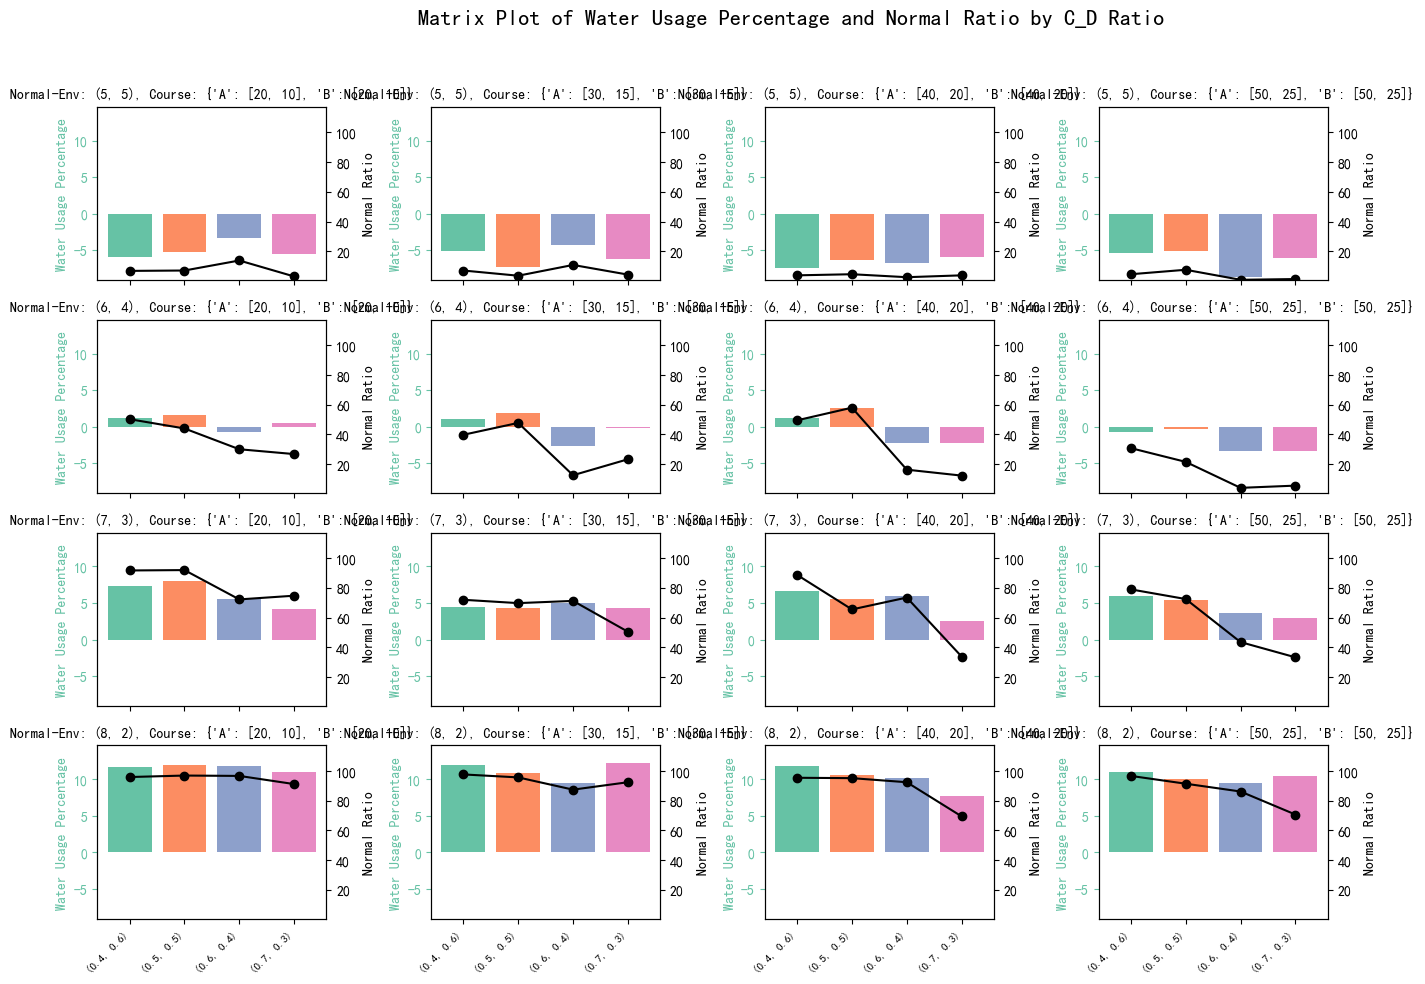

'matrix_bar_line_dual_axis_plot.png'

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 读取分组后的数据
grouped_file_path = "grouped_water_usage_analysis.csv"
grouped_df = pd.read_csv(grouped_file_path)

# 确保数据格式正确
grouped_df['c_d_ratio'] = grouped_df['c_d_ratio'].astype(str)
grouped_df['normal_env_ratio'] = grouped_df['normal_env_ratio'].astype(str)
grouped_df['course_attendance_ratio'] = grouped_df['course_attendance_ratio'].astype(str)

# 获取唯一值顺序
unique_c_d_ratios = sorted(grouped_df['c_d_ratio'].unique())
unique_normal_env_ratios = sorted(grouped_df['normal_env_ratio'].unique())
unique_course_attendance_ratios = sorted(grouped_df['course_attendance_ratio'].unique())

# 创建网格子图
fig, axes = plt.subplots(len(unique_normal_env_ratios), len(unique_course_attendance_ratios), 
                         figsize=(15, 10), sharex=True)

# 确保 axes 是二维数组，即使只有一行或一列时
if len(unique_normal_env_ratios) == 1:
    axes = [axes]  # 转换为二维列表
if len(unique_course_attendance_ratios) == 1:
    axes = [[ax] for ax in axes]

# 设置颜色
bar_color = sns.color_palette("Set2", len(unique_c_d_ratios))
line_color = "black"  # 折线图颜色

# 遍历 normal_env_ratio 和 course_attendance_ratio 组合
for i, normal_env in enumerate(unique_normal_env_ratios):
    for j, course_attendance in enumerate(unique_course_attendance_ratios):
        # 筛选特定 normal_env_ratio 和 course_attendance_ratio 下的数据
        subset = grouped_df[(grouped_df['normal_env_ratio'] == normal_env) & 
                            (grouped_df['course_attendance_ratio'] == course_attendance)]
        ax1 = axes[i][j]  # 主坐标轴

        # 创建双坐标轴
        ax2 = ax1.twinx()  

        # 绘制柱状图（用水量百分比 - 左侧 y 轴）
        bars = ax1.bar(subset['c_d_ratio'], subset['water_usage_percentage'], 
                       color=bar_color, label='Water Usage %')

        # 绘制折线图（Normal Ratio - 右侧 y 轴）
        ax2.plot(subset['c_d_ratio'], subset['normal_ratio'], 
                 marker='o', color=line_color, linestyle='-', label='Normal Ratio')

        # 设置标题
        ax1.set_title(f"Normal-Env: {normal_env}, Course: {course_attendance}", fontsize=10)
        ax1.set_xticklabels(subset['c_d_ratio'], rotation=45, ha='right', fontsize=8)

        # 设置左 y 轴范围（柱状图）
        ax1.set_ylabel("Water Usage Percentage", color=bar_color[0])
        ax1.set_ylim(grouped_df['water_usage_percentage'].min() * 1.05, 
                     grouped_df['water_usage_percentage'].max() * 1.2)
        ax1.tick_params(axis='y', colors=bar_color[0])

        # 设置右 y 轴范围（折线图）
        ax2.set_ylabel("Normal Ratio", color=line_color)
        ax2.set_ylim(grouped_df['normal_ratio'].min() * 0.8, 
                     grouped_df['normal_ratio'].max() * 1.2)
        ax2.tick_params(axis='y', colors=line_color)

# 添加总体标题
fig.suptitle("Matrix Plot of Water Usage Percentage and Normal Ratio by C_D Ratio", fontsize=16)

# 调整布局
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

# 保存并显示图像
output_matrix_file = "matrix_bar_line_dual_axis_plot.png"
plt.savefig(output_matrix_file, dpi=300)
plt.show()

# 返回生成的文件路径
output_matrix_file


## 5.6 最终结果_调好图片格式

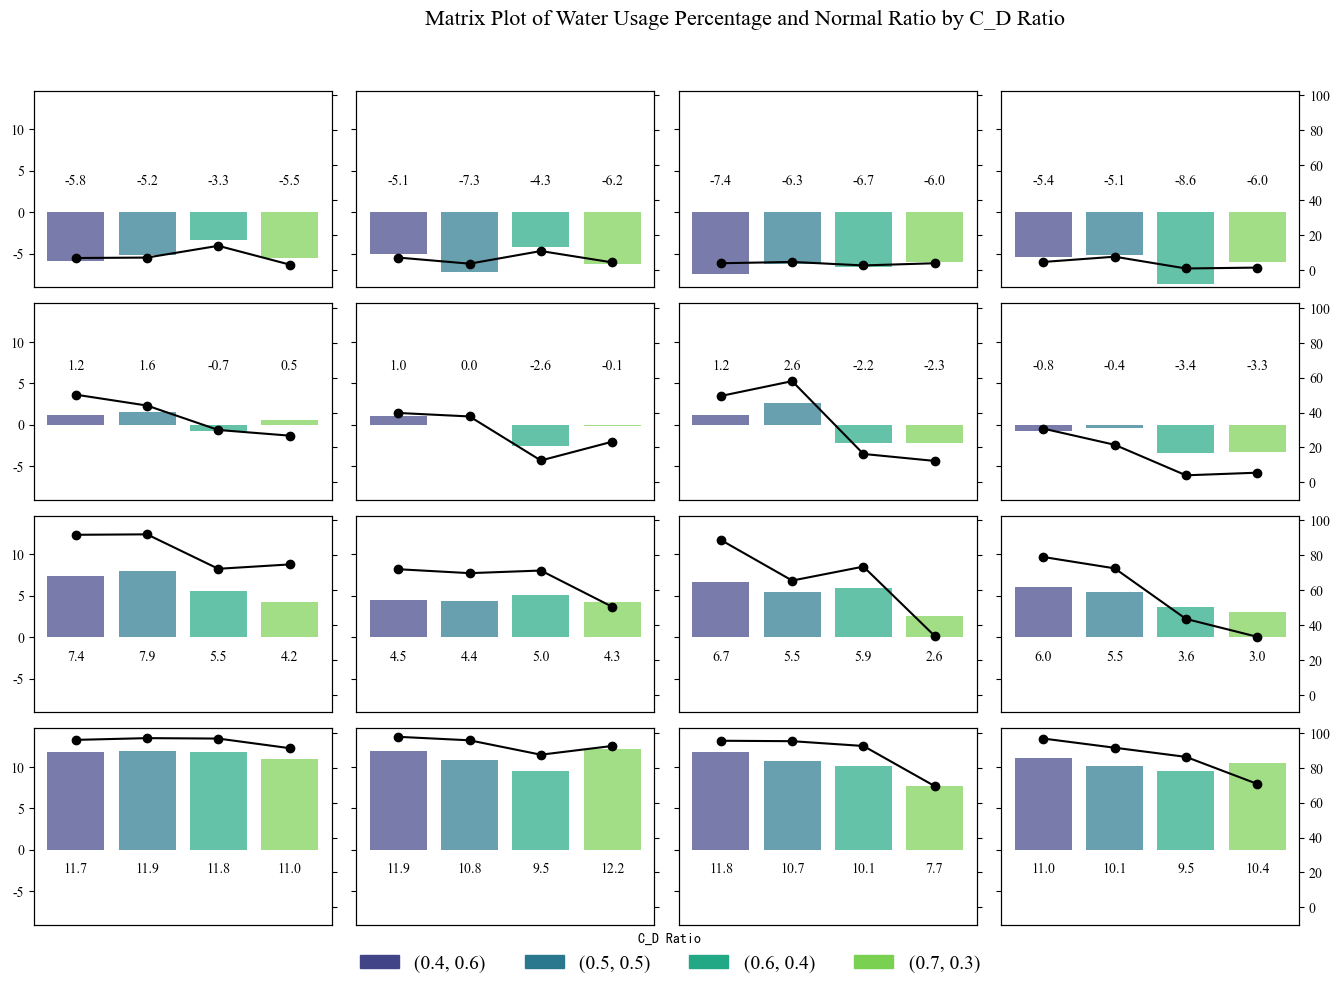

'matrix_bar_line_dual_axis_plot.png'

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.patches as mpatches

# 读取分组后的数据
grouped_file_path = "grouped_water_usage_analysis.csv"
grouped_df = pd.read_csv(grouped_file_path)

# 确保数据格式正确
grouped_df['c_d_ratio'] = grouped_df['c_d_ratio'].astype(str)
grouped_df['normal_env_ratio'] = grouped_df['normal_env_ratio'].astype(str)
grouped_df['course_attendance_ratio'] = grouped_df['course_attendance_ratio'].astype(str)

# 获取唯一值顺序
unique_c_d_ratios = sorted(grouped_df['c_d_ratio'].unique())
unique_normal_env_ratios = sorted(grouped_df['normal_env_ratio'].unique())
unique_course_attendance_ratios = sorted(grouped_df['course_attendance_ratio'].unique())

# 创建网格子图（共享 X 轴 和 左侧 Y 轴）
fig, axes = plt.subplots(len(unique_normal_env_ratios), len(unique_course_attendance_ratios), 
                         figsize=(15, 10), sharex=True, sharey=True)

# 确保 axes 是二维数组
if len(unique_normal_env_ratios) == 1:
    axes = [axes]
if len(unique_course_attendance_ratios) == 1:
    axes = [[ax] for ax in axes]

# 计算右侧 Y 轴（折线图）的全局范围，以保证共享
right_y_min = grouped_df['normal_ratio'].min() * 0.95
right_y_max = grouped_df['normal_ratio'].max() * 1.05

# 设置颜色，bar_color 采用 viridis 调色板
bar_color = sns.color_palette("viridis", len(unique_c_d_ratios))
line_color = "black"  # 折线图颜色

# 遍历 normal_env_ratio 和 course_attendance_ratio 组合
for i, normal_env in enumerate(unique_normal_env_ratios):
    for j, course_attendance in enumerate(unique_course_attendance_ratios):
        # 筛选特定 normal_env_ratio 和 course_attendance_ratio 下的数据
        subset = grouped_df[(grouped_df['normal_env_ratio'] == normal_env) & 
                            (grouped_df['course_attendance_ratio'] == course_attendance)]
        ax1 = axes[i][j]  # 主坐标轴（柱状图）
        ax2 = ax1.twinx()  # 创建右侧 Y 轴

        # 绘制柱状图（用水量百分比 - 左侧 Y 轴），返回所有的 bar 对象
        bars = ax1.bar(subset['c_d_ratio'], subset['water_usage_percentage'], color=bar_color, alpha=0.7)
        ax1.set_ylim(grouped_df['water_usage_percentage'].min() * 1.05, 
                     grouped_df['water_usage_percentage'].max() * 1.2)
        
        # 根据 i 的值判断
        if i == 3 or i == 2:
            # 在每个柱子上添加文本标注（数值），高度偏移 -5
            for bar in bars:
                height = bar.get_height() 
                ax1.text(
                    bar.get_x() + bar.get_width() / 2, -1.5, f"{height:.1f}",
                    ha='center', va='top', fontfamily='Times New Roman', fontsize=10
                )
        elif i == 1:
            for bar in bars:
                height = bar.get_height() 
                ax1.text(
                    bar.get_x() + bar.get_width() / 2, 8, f"{height:.1f}",
                    ha='center', va='top', fontfamily='Times New Roman', fontsize=10
                )
        else:
            for bar in bars:
                height = bar.get_height() 
                ax1.text(
                    bar.get_x() + bar.get_width() / 2, 3, f"{height:.1f}",
                    ha='center', va='bottom', fontfamily='Times New Roman', fontsize=10
                )
        # 绘制折线图（Normal Ratio - 右侧 Y 轴）
        ax2.plot(subset['c_d_ratio'], subset['normal_ratio'], color=line_color, marker='o')
        ax2.set_ylim(-10, right_y_max)  # 右侧 Y 轴共享范围

        # 隐藏所有子图的 X 轴刻度
        ax1.set_xticks([])

        # 隐藏非最右侧的右侧 Y 轴刻度
        if j != len(unique_course_attendance_ratios) - 1:
            ax2.set_yticklabels([])
            ax2.set_ylabel("")

# 添加全局图例（以图例的形式表达不同的 c_d_ratio），放在图下方且无边框
handles = [mpatches.Patch(color=bar_color[k], label=unique_c_d_ratios[k]) for k in range(len(unique_c_d_ratios))]
fig.legend(handles=handles, title="C_D Ratio", loc='lower center', ncol=len(unique_c_d_ratios),
           frameon=False, prop={'family': 'Times New Roman', 'size': 14})

# 添加总体标题
fig.suptitle("Matrix Plot of Water Usage Percentage and Normal Ratio by C_D Ratio", fontsize=16, fontname='Times New Roman')

# 调整布局，使图例位置下移
plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])

# 设置所有子图的刻度标签字体为 Times New Roman，字号 10
for ax in fig.get_axes():
    for label in ax.get_xticklabels() + ax.get_yticklabels():
        label.set_fontfamily('Times New Roman')
        label.set_fontsize(10)

# 保存并显示图像
output_matrix_file = "matrix_bar_line_dual_axis_plot.png"
plt.savefig(output_matrix_file, dpi=300)
plt.show()

# 返回生成的文件路径
output_matrix_file


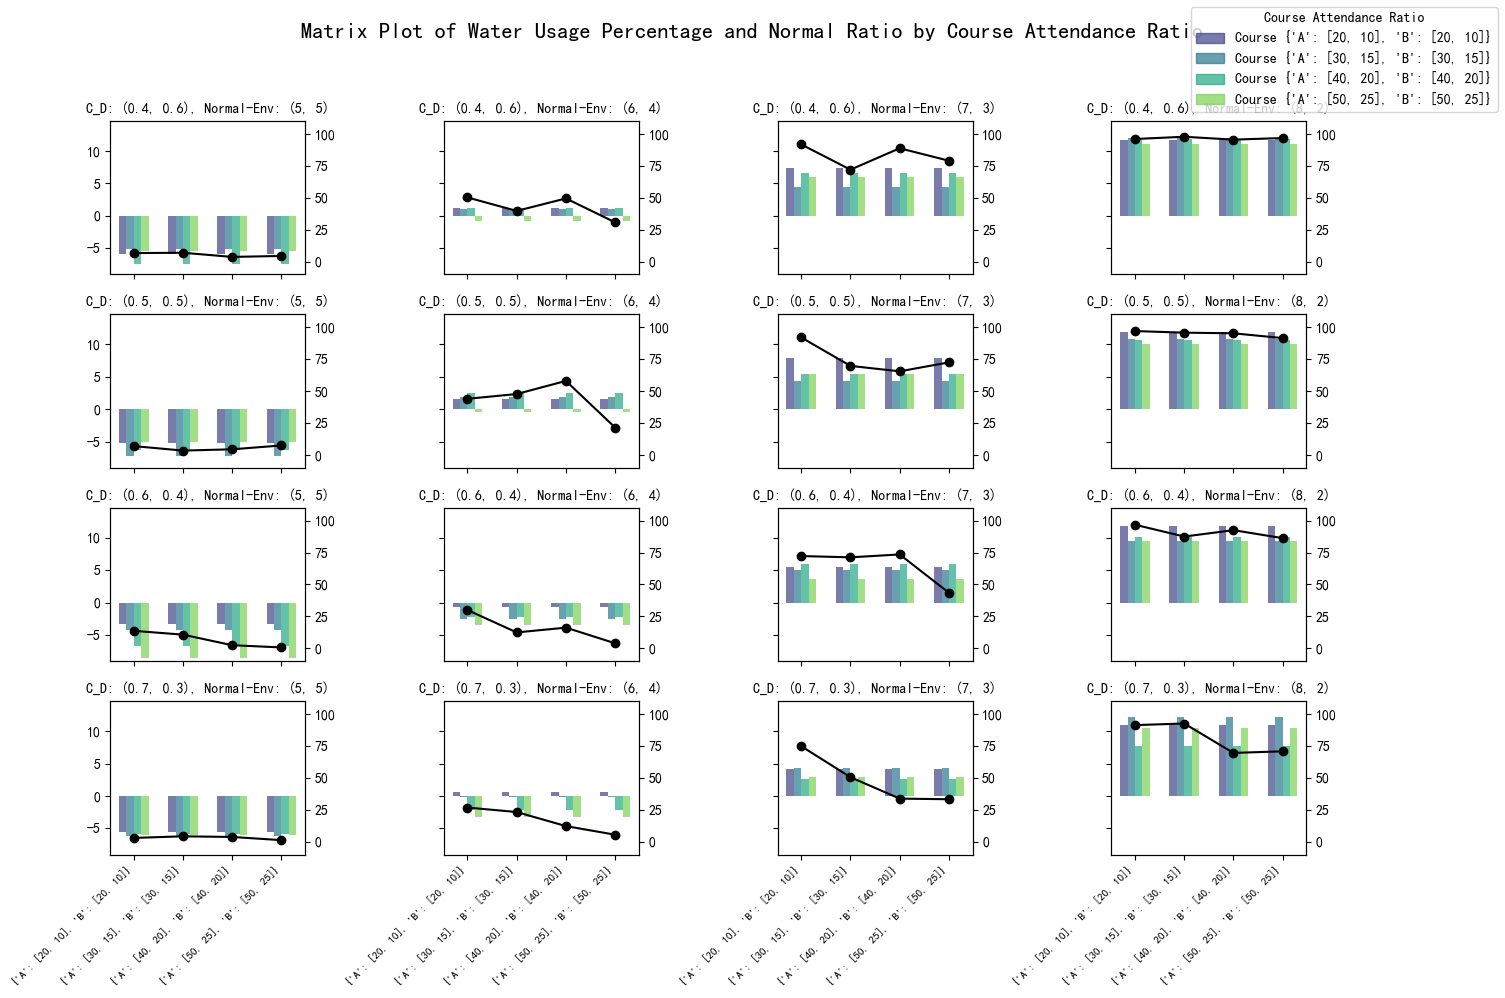

'matrix_bar_line_dual_axis_plot.png'

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# 读取数据
grouped_file_path = "grouped_water_usage_analysis.csv"
grouped_df = pd.read_csv(grouped_file_path)

# 确保数据格式正确
grouped_df['c_d_ratio'] = grouped_df['c_d_ratio'].astype(str)
grouped_df['normal_env_ratio'] = grouped_df['normal_env_ratio'].astype(str)
grouped_df['course_attendance_ratio'] = grouped_df['course_attendance_ratio'].astype(str)

# 获取唯一值顺序
unique_c_d_ratios = sorted(grouped_df['c_d_ratio'].unique())  # 学习率
unique_normal_env_ratios = sorted(grouped_df['normal_env_ratio'].unique())  # 初始比例
unique_course_attendance_ratios = sorted(grouped_df['course_attendance_ratio'].unique())  # 上课比例

# 创建子图（行=学习率，列=初始比例）
fig, axes = plt.subplots(len(unique_c_d_ratios), len(unique_normal_env_ratios),
                         figsize=(15, 10), sharex=True, sharey=True)

# 确保 axes 是二维数组
if len(unique_c_d_ratios) == 1:
    axes = [axes]  # 转换为二维列表
if len(unique_normal_env_ratios) == 1:
    axes = [[ax] for ax in axes]

# 颜色映射不同的 `course_attendance_ratio`
bar_color = sns.color_palette("viridis", len(unique_course_attendance_ratios))
line_color = "black"  # 折线图颜色

# 遍历 `c_d_ratio`（学习率） 和 `normal_env_ratio`（初始比例）的组合
for i, c_d in enumerate(unique_c_d_ratios):
    for j, normal_env in enumerate(unique_normal_env_ratios):
        ax1 = axes[i][j]  # 当前子图
        ax2 = ax1.twinx()  # 创建双坐标轴

        # 筛选特定 `c_d_ratio` 和 `normal_env_ratio` 下的数据
        subset = grouped_df[(grouped_df['c_d_ratio'] == c_d) & 
                            (grouped_df['normal_env_ratio'] == normal_env)]

        # x 轴使用 `course_attendance_ratio`
        x_labels = subset['course_attendance_ratio'].unique()
        x_positions = np.arange(len(x_labels))

        # 遍历 `course_attendance_ratio`，绘制柱状图
        for idx, course_attendance in enumerate(unique_course_attendance_ratios):
            sub_subset = subset[subset['course_attendance_ratio'] == course_attendance]
            ax1.bar(x_positions + idx * 0.15, sub_subset['water_usage_percentage'], 
                    width=0.15, label=f'Course {course_attendance}', color=bar_color[idx], alpha=0.7)

        # 绘制折线图（Normal Ratio - 右侧 y 轴）
        ax2.plot(x_positions + 0.225, subset.groupby('course_attendance_ratio')['normal_ratio'].mean(), 
                 color=line_color, marker='o')

        # 设置 x 轴刻度
        ax1.set_xticks(x_positions + 0.225)
        ax1.set_xticklabels(x_labels, rotation=45, ha='right', fontsize=8)

        # 设置 y 轴范围
        ax1.set_ylim(grouped_df['water_usage_percentage'].min() * 1.05, 
                     grouped_df['water_usage_percentage'].max() * 1.2)
        ax2.set_ylim(-10, 110)

        # 设置标题
        ax1.set_title(f"C_D: {c_d}, Normal-Env: {normal_env}", fontsize=10)

# 添加图例（放在全局）
handles = [plt.Rectangle((0, 0), 1, 1, color=bar_color[i], alpha=0.7) 
           for i in range(len(unique_course_attendance_ratios))]
labels = [f'Course {ca}' for ca in unique_course_attendance_ratios]
fig.legend(handles, labels, loc='upper right', fontsize=10, title="Course Attendance Ratio")

# 添加总体标题
fig.suptitle("Matrix Plot of Water Usage Percentage and Normal Ratio by Course Attendance Ratio", fontsize=16)

# 调整布局
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

# 保存并显示图像
output_matrix_file = "matrix_bar_line_dual_axis_plot.png"
plt.savefig(output_matrix_file, dpi=300)
plt.show()

# 返回生成的文件路径
output_matrix_file


# 6. 对于敏感情景进一步讨论

## 6.1 是哪些人的行为改变导致了节水效应

In [ ]:
import pandas as pd
import random, hashlib
import numpy as np
from datetime import datetime, timedelta

def run_simulation(params, holiday_effects):
    """
    针对某个参数组合运行模型，并返回模型中 DataCollector 收集的原始代理数据。
    """
    # 基于参数生成另一组唯一随机种子，保证结果可重复
    seed_str = str(params)
    seed_val = int(hashlib.md5(seed_str.encode('utf-8')).hexdigest(), 16) % (2**32)
    random.seed(seed_val)
    np.random.seed(seed_val)

    # 解包参数（示例）
    c_d_ratio, normal_env_ratio, course_attendance_ratio = params

    # 初始化模型
    model = StudentModel(
        num_agents=400,
        start_date="2023-05-19",
        holiday_effects=holiday_effects,
        beta=7,
        normal_env_ratio=normal_env_ratio,
        num_neighbors=20,
        c_d_ratio=c_d_ratio,
        interaction_interval=90,
        course_attendance_ratio=course_attendance_ratio
    )

    # 运行模型 363 天
    for _ in range(363):
        model.step()

    # 从 DataCollector 获取所有代理在各时间步的数据
    df_agents = model.get_collected_data()  
    # 这时 df_agents 是一个多重索引的 DataFrame：
    #   索引: (Step, AgentID)
    #   列: [WaterUsage, Profile, Faculty, Grade, GreenEducation]

    # 可以在这里直接返回，后面再聚合或可视化
    return df_agents.reset_index()  # 转成普通 DataFrame，包含 Step、AgentID 等


In [59]:
import itertools
from tqdm import tqdm

# 你要的 5 个情景
selected_params = [
    # 情景1
    ((0.6, 0.4), (7, 3), {"A": [50, 25], "B": [50, 25]}),
    # 情景2
    ((0.3, 0.7), (7, 3), {"A": [50, 25], "B": [50, 25]}),
    # 情景3
    ((0.6, 0.4), (7, 3), {"A": [10, 5], "B": [10, 5]}),
    # 情景4
    ((0.6, 0.4), (8, 2), {"A": [50, 25], "B": [50, 25]}),
    # 情景5
    ((0.6, 0.4), (6, 4), {"A": [50, 25], "B": [50, 25]}),
    # 情景6:低教育普及率、高效果
    ((0.7, 0.3), (6, 4), {"A": [10, 5], "B": [10, 5]}),
    # 情景7:高教育普及率、低效果
    ((0.4, 0.6), (6, 4), {"A": [50, 25], "B": [50, 25]})
]

all_data = []
for params in tqdm(selected_params):
    df_agents = run_simulation(params, holiday_effects)
    # 给结果加上本次情景的标识（便于后续区分）
    df_agents["c_d_ratio"] = str(params[0])
    df_agents["normal_env_ratio"] = str(params[1])
    df_agents["course_attendance_ratio"] = str(params[2])
    all_data.append(df_agents)

df_all = pd.concat(all_data, ignore_index=True)
# df_all 里就包含了所有代理、所有时间步、所有情景的详细数据
# 你可以保存一下
df_all.to_csv("0312_five_scenarios_raw_agent_data.csv", index=False)


100%|██████████| 7/7 [03:26<00:00, 29.56s/it]


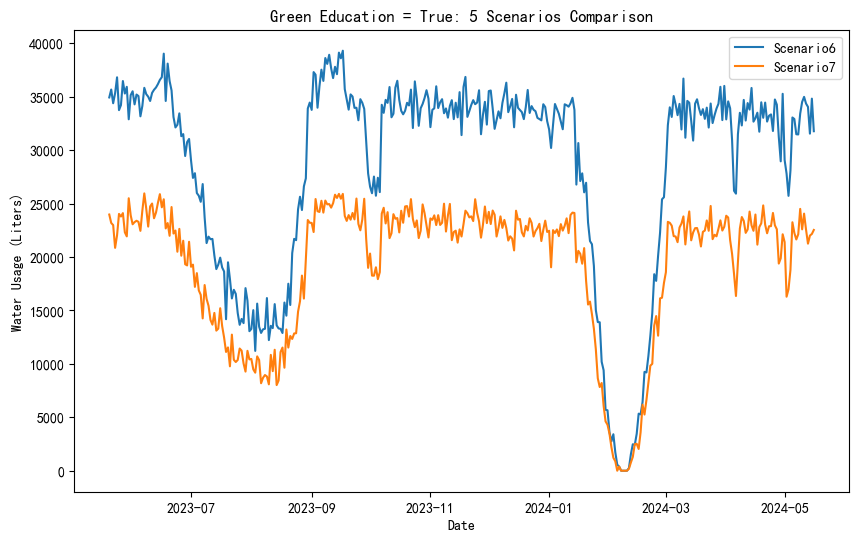

In [ ]:
scenarios = [
    ("Scenario1", "(0.6, 0.4)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario2", "(0.5, 0.5)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario3", "(0.6, 0.4)", "(7, 3)", "{'A': [40, 20], 'B': [40, 20]}"),
    ("Scenario4", "(0.6, 0.4)", "(8, 2)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario5", "(0.6, 0.4)", "(6, 4)", "{'A': [50, 25], 'B': [50, 25]}"),
    

]




plt.figure(figsize=(10, 6))
for scenario_name, c_d, ne_ratio, ca_ratio in scenarios:
    df_scenario = df_all[
        (df_all["c_d_ratio"] == c_d) &
        (df_all["normal_env_ratio"] == ne_ratio) &
        (df_all["course_attendance_ratio"] == ca_ratio) &
        (df_all["GreenEducation"] == False)  # 注意这里是布尔值
    ]
    grouped = df_scenario.groupby("Step")["WaterUsage"].sum()
    grouped.index = [start_date + timedelta(days=int(s)) for s in grouped.index]

    plt.plot(grouped.index, grouped.values, label=scenario_name)

plt.title("Green Education = True: 5 Scenarios Comparison")
plt.xlabel("Date")
plt.ylabel("Water Usage (Liters)")
plt.legend()
plt.show()



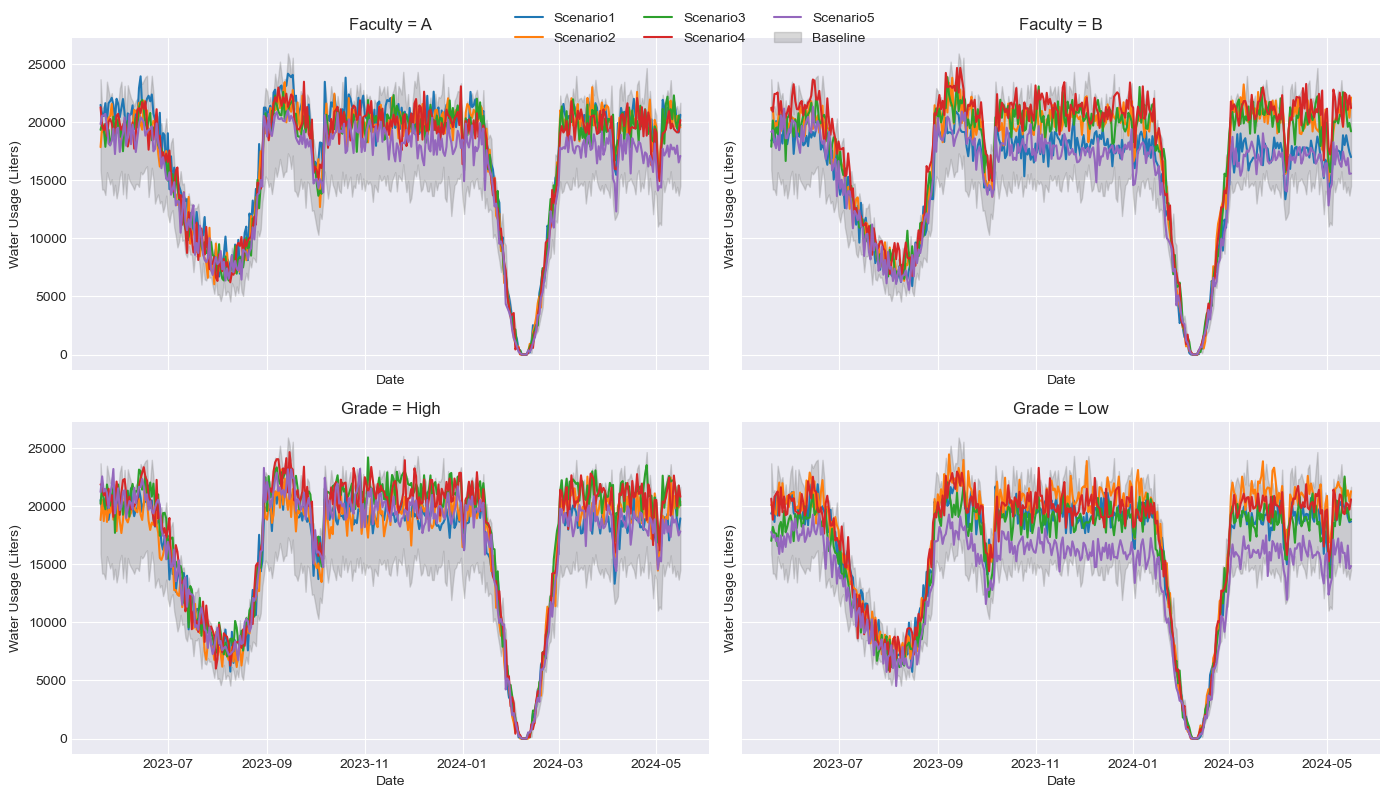

In [80]:
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

# 假设 start_date 与模拟时一致
start_date = datetime.strptime("2023-05-19", "%Y-%m-%d")
scenarios = [
    ("Scenario1", "(0.6, 0.4)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario2", "(0.3, 0.7)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario3", "(0.6, 0.4)", "(7, 3)", "{'A': [10, 5], 'B': [10, 5]}"),
    ("Scenario4", "(0.6, 0.4)", "(8, 2)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario5", "(0.6, 0.4)", "(6, 4)", "{'A': [50, 25], 'B': [50, 25]}")

]
# 读取基线数据
max_values = pd.read_csv('baseline_daily_usage_df_max.csv', index_col=0)
min_values = pd.read_csv('baseline_daily_usage_df_min.csv', index_col=0)
max_values.index = pd.to_datetime(max_values.index)
min_values.index = pd.to_datetime(min_values.index)

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)

# 第一个子图：Faculty = A
ax = axes[0, 0]
for scenario_name, c_d, ne_ratio, ca_ratio in scenarios:
    df_scenario = df_all[
        (df_all["c_d_ratio"] == c_d) &
        (df_all["normal_env_ratio"] == ne_ratio) &
        (df_all["course_attendance_ratio"] == ca_ratio) &
        (df_all["Faculty"] == "A")
    ]
    grouped = df_scenario.groupby("Step")["WaterUsage"].sum()
    grouped.index = [start_date + timedelta(days=int(s)) for s in grouped.index]
    ax.plot(grouped.index, grouped.values, label=scenario_name)

# 绘制基线阴影区域（min～max）
ax.fill_between(min_values.index, 
                min_values.iloc[:,0], 
                max_values.iloc[:,0], 
                color='gray', alpha=0.3, label='Baseline')
ax.set_title("Faculty = A")
ax.set_xlabel("Date")
ax.set_ylabel("Water Usage (Liters)")

# 第二个子图：Faculty = B
ax = axes[0, 1]
for scenario_name, c_d, ne_ratio, ca_ratio in scenarios:
    df_scenario = df_all[
        (df_all["c_d_ratio"] == c_d) &
        (df_all["normal_env_ratio"] == ne_ratio) &
        (df_all["course_attendance_ratio"] == ca_ratio) &
        (df_all["Faculty"] == "B")
    ]
    grouped = df_scenario.groupby("Step")["WaterUsage"].sum()
    grouped.index = [start_date + timedelta(days=int(s)) for s in grouped.index]
    ax.plot(grouped.index, grouped.values, label=scenario_name)

ax.fill_between(min_values.index, 
                min_values.iloc[:,0], 
                max_values.iloc[:,0], 
                color='gray', alpha=0.3, label='Baseline')
ax.set_title("Faculty = B")
ax.set_xlabel("Date")
ax.set_ylabel("Water Usage (Liters)")

# 第三个子图：Grade = 高年级
ax = axes[1, 0]
for scenario_name, c_d, ne_ratio, ca_ratio in scenarios:
    df_scenario = df_all[
        (df_all["c_d_ratio"] == c_d) &
        (df_all["normal_env_ratio"] == ne_ratio) &
        (df_all["course_attendance_ratio"] == ca_ratio) &
        (df_all["Grade"] == "高年级")
    ]
    grouped = df_scenario.groupby("Step")["WaterUsage"].sum()
    grouped.index = [start_date + timedelta(days=int(s)) for s in grouped.index]
    ax.plot(grouped.index, grouped.values, label=scenario_name)

ax.fill_between(min_values.index, 
                min_values.iloc[:,0], 
                max_values.iloc[:,0], 
                color='gray', alpha=0.3, label='Baseline')
ax.set_title("Grade = High")
ax.set_xlabel("Date")
ax.set_ylabel("Water Usage (Liters)")

# 第四个子图：Grade = 低年级
ax = axes[1, 1]
for scenario_name, c_d, ne_ratio, ca_ratio in scenarios:
    df_scenario = df_all[
        (df_all["c_d_ratio"] == c_d) &
        (df_all["normal_env_ratio"] == ne_ratio) &
        (df_all["course_attendance_ratio"] == ca_ratio) &
        (df_all["Grade"] == "低年级")
    ]
    grouped = df_scenario.groupby("Step")["WaterUsage"].sum()
    grouped.index = [start_date + timedelta(days=int(s)) for s in grouped.index]
    ax.plot(grouped.index, grouped.values, label=scenario_name)

ax.fill_between(min_values.index, 
                min_values.iloc[:,0], 
                max_values.iloc[:,0], 
                color='gray', alpha=0.3, label='Baseline')
ax.set_title("Grade = Low")
ax.set_xlabel("Date")
ax.set_ylabel("Water Usage (Liters)")

# 如果想把图例放在最外层，可以再单独加 legend
handles, labels = axes[1,1].get_legend_handles_labels()
# 图例与最上方距离远一点
fig.legend(handles, labels, loc='upper center', ncol=3)



plt.tight_layout()
plt.show()


C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\4196074165.py:39: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\4196074165.py:109: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\4196074165.py:109: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\4196074165.py:109: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from current font.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
C:\Users\Huyc\AppData\Local\Temp\ipyker

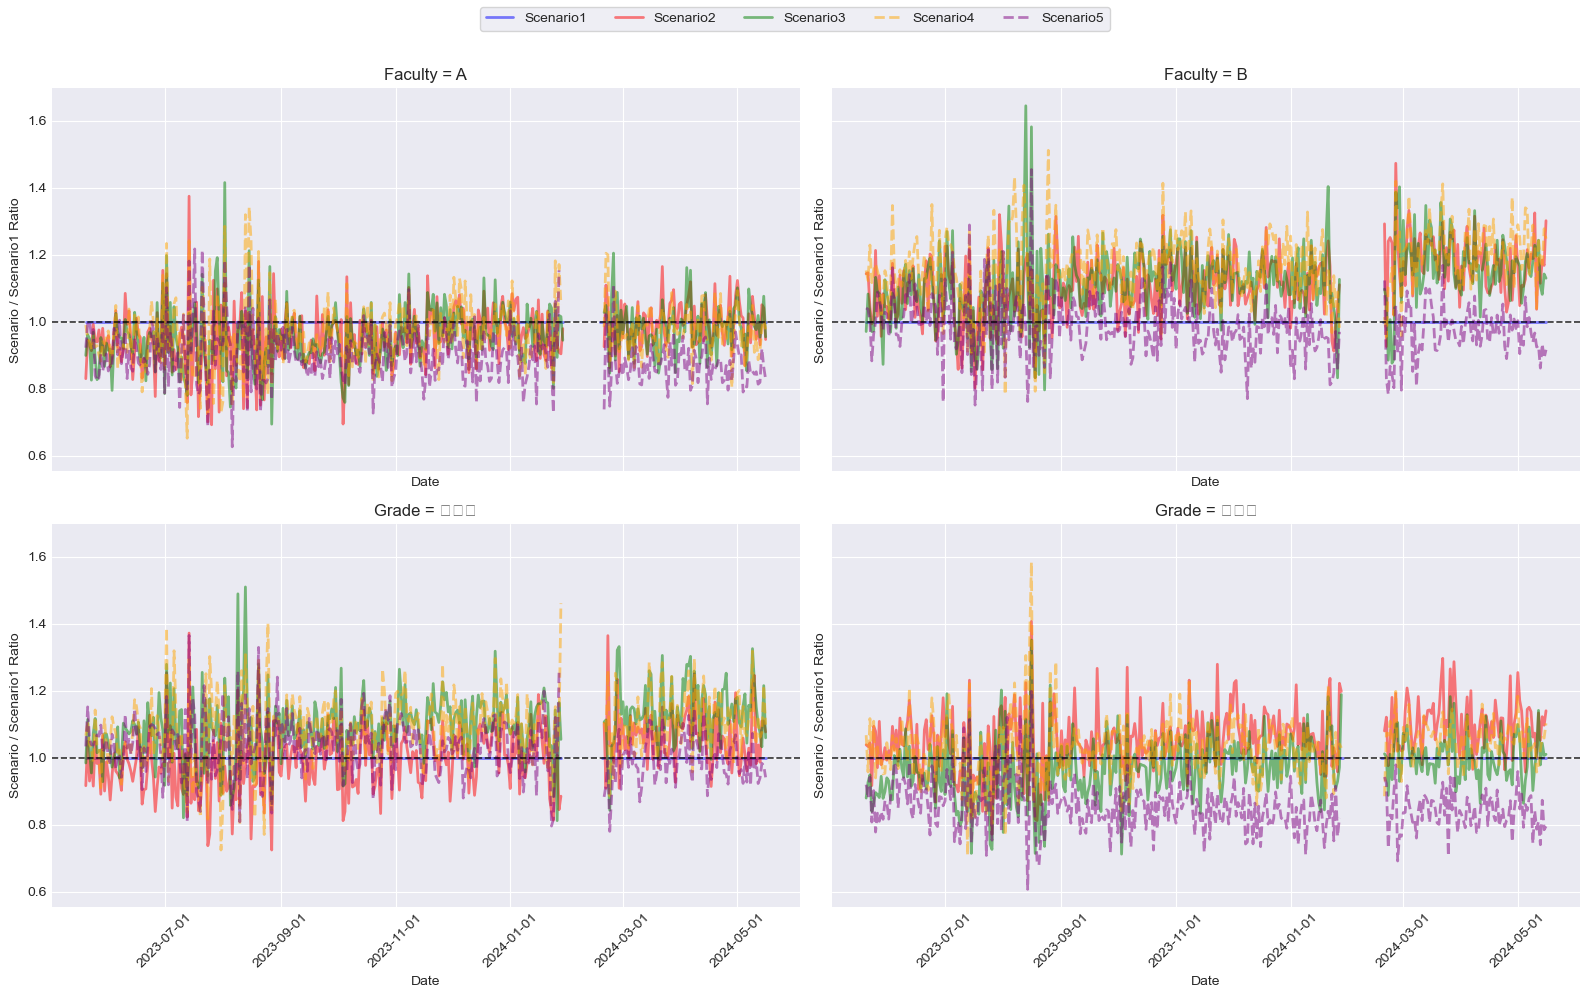

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
from datetime import timedelta, datetime
import pandas as pd

df_all=pd.read_csv("0312_five_scenarios_raw_agent_data.csv")

# 假设 start_date 与模拟时一致
start_date = datetime.strptime("2023-05-19", "%Y-%m-%d")

# Scenario1 作为基线
scenarios = [
    ("Scenario1", "(0.6, 0.4)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario2", "(0.3, 0.7)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario3", "(0.6, 0.4)", "(7, 3)", "{'A': [10, 5], 'B': [10, 5]}"),
    ("Scenario4", "(0.6, 0.4)", "(8, 2)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario5", "(0.6, 0.4)", "(6, 4)", "{'A': [50, 25], 'B': [50, 25]}")
]

# 为每个 Scenario 指定 (color, linestyle)
# 前三条实线，后两条虚线
scenario_styles = {
    "Scenario1": {"color": "blue",   "linestyle": "-"},
    "Scenario2": {"color": "red",    "linestyle": "-"},
    "Scenario3": {"color": "green",  "linestyle": "-"},
    "Scenario4": {"color": "orange", "linestyle": "--"},
    "Scenario5": {"color": "purple", "linestyle": "--"},
}

# 定义4个子图的过滤条件
filters = [
    ("Faculty", "A"),
    ("Faculty", "B"),
    ("Grade", "高年级"),
    ("Grade", "低年级")
]

plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

# 取出 Scenario1 的信息
scenario1_info = scenarios[0]  # ("Scenario1", "(0.6, 0.4)", "(7, 3)", ...)

# 设定阈值
THRESHOLD = 5000

for ax, (filter_key, filter_value) in zip(axes.flatten(), filters):
    # ========== 1) 获取 Scenario1 在该过滤条件下的用水量 ==========
    cond_scenario1 = (
        (df_all["c_d_ratio"] == scenario1_info[1]) &
        (df_all["normal_env_ratio"] == scenario1_info[2]) &
        (df_all["course_attendance_ratio"] == scenario1_info[3]) &
        (df_all[filter_key] == filter_value)
    )
    df_scenario1 = df_all[cond_scenario1]
    scenario1_grouped = df_scenario1.groupby("Step")["WaterUsage"].sum()

    # ========== 2) 遍历所有 Scenario 计算“相对于 Scenario1 的比值” ==========
    for (scenario_name, c_d, ne_ratio, ca_ratio) in scenarios:
        cond_scenario = (
            (df_all["c_d_ratio"] == c_d) &
            (df_all["normal_env_ratio"] == ne_ratio) &
            (df_all["course_attendance_ratio"] == ca_ratio) &
            (df_all[filter_key] == filter_value)
        )
        df_scenario = df_all[cond_scenario]
        scenario_grouped = df_scenario.groupby("Step")["WaterUsage"].sum()

        # 对齐索引
        scenario_grouped = scenario_grouped.reindex(scenario1_grouped.index)
        
        # ========== 3) 将小于阈值的值置为 NaN ==========
        mask = (scenario_grouped < THRESHOLD) | (scenario1_grouped < THRESHOLD)
        scenario_grouped[mask] = np.nan
        scenario1_grouped[mask] = np.nan

        # 计算比值
        ratio_series = scenario_grouped / scenario1_grouped
        
        # ========== 4) 生成日期索引并绘图 ==========
        dates = [start_date + timedelta(days=int(s)) for s in ratio_series.index]

        style = scenario_styles.get(scenario_name, {})
        ax.plot(
            dates,
            ratio_series.values,
            label=scenario_name,
            linewidth=2,
            alpha=0.5,  # 透明度(可调节)
            **style     # 解包我们在 scenario_styles 中设置的参数
        )

    # ========== 5) 画参考线 y=1 表示与 Scenario1 相同 ==========
    ax.axhline(y=1, color='black', linestyle='--', linewidth=1.2, alpha=0.8)

    # X轴日期格式
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.tick_params(axis='x', rotation=45)

    ax.set_xlabel("Date")
    ax.set_ylabel("Scenario / Scenario1 Ratio")
    ax.set_title(f"{filter_key} = {filter_value}")

# 统一图例
handles, labels = axes[0][0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=6, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\1758934592.py:30: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\1758934592.py:74: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  plt.tight_layout()
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\1758934592.py:74: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\1758934592.py:74: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from current font.
  plt.tight_layout()
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\1758934592.py:74: UserWarning: Glyph 20302 (\N{CJK UN

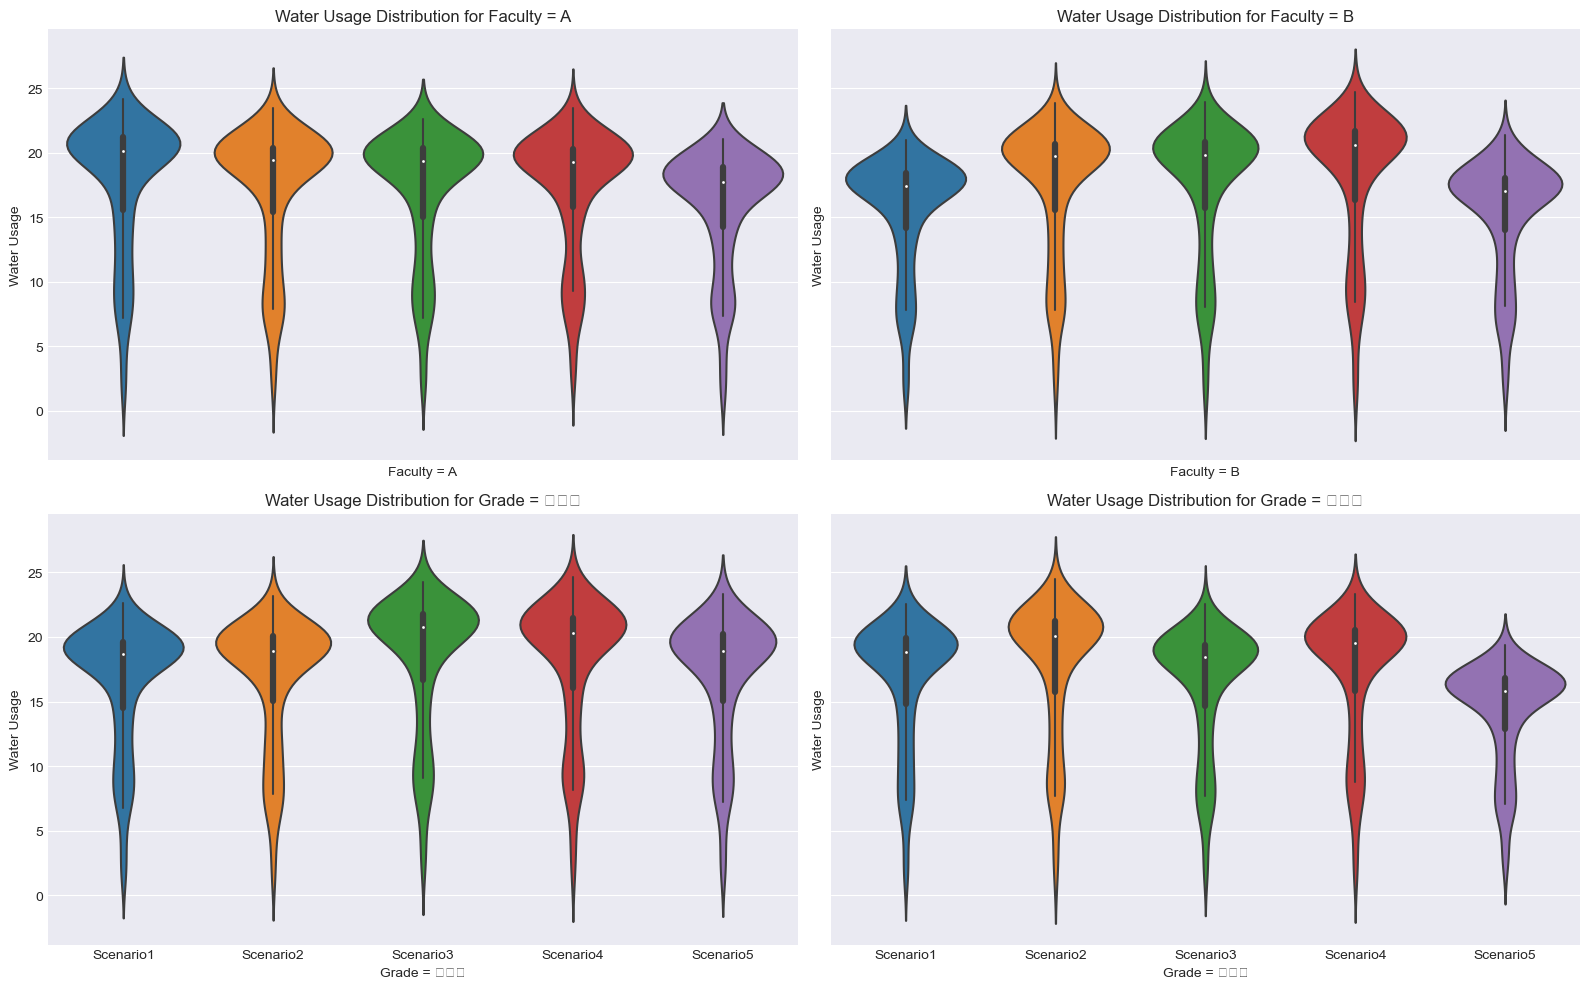

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import timedelta, datetime

df_all = pd.read_csv("0312_five_scenarios_raw_agent_data.csv")

# 假设 start_date 与模拟时一致
start_date = datetime.strptime("2023-05-19", "%Y-%m-%d")

# Scenario1 作为基线
scenarios = [
    ("Scenario1", "(0.6, 0.4)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario2", "(0.3, 0.7)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario3", "(0.6, 0.4)", "(7, 3)", "{'A': [10, 5], 'B': [10, 5]}"),
    ("Scenario4", "(0.6, 0.4)", "(8, 2)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario5", "(0.6, 0.4)", "(6, 4)", "{'A': [50, 25], 'B': [50, 25]}"),
]

# 定义4个子图的过滤条件
filters = [
    ("Faculty", "A"),
    ("Faculty", "B"),
    ("Grade", "高年级"),
    ("Grade", "低年级")
]

# 设置小提琴图
plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

# 设定阈值
THRESHOLD = 1

for ax, (filter_key, filter_value) in zip(axes.flatten(), filters):
    # 为每个情境添加数据
    all_scenario_data = []
    all_scenario_labels = []

    for (scenario_name, c_d, ne_ratio, ca_ratio) in scenarios:
        cond_scenario = (
            (df_all["c_d_ratio"] == c_d) &
            (df_all["normal_env_ratio"] == ne_ratio) &
            (df_all["course_attendance_ratio"] == ca_ratio) &
            (df_all[filter_key] == filter_value)
        )
        df_scenario = df_all[cond_scenario]

        # 筛选出用水量
        water_usage = df_scenario.groupby("Step")["WaterUsage"].sum()/1000

        # 将小于阈值的值置为 NaN
        water_usage[water_usage < THRESHOLD] = np.nan

        # 将数据与情境标签一起保存
        all_scenario_data.append(water_usage.dropna())
        all_scenario_labels.append(scenario_name)

    # 合并数据为 DataFrame 进行绘图
    scenario_df = pd.DataFrame({
        "WaterUsage": np.concatenate(all_scenario_data),
        "Scenario": np.concatenate([[label] * len(data) for label, data in zip(all_scenario_labels, all_scenario_data)])
    })

    # 绘制小提琴图
    sns.violinplot(x="Scenario", y="WaterUsage", data=scenario_df, ax=ax)

    ax.set_xlabel(f"{filter_key} = {filter_value}")
    ax.set_ylabel("Water Usage")
    ax.set_title(f"Water Usage Distribution for {filter_key} = {filter_value}")

# 调整布局
plt.tight_layout()
plt.show()


C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\2851044826.py:34: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


Faculty = A - Scenario2 vs Scenario1: Kruskal-Wallis p-value = 0.00025361237838906456
有显著差异: Scenario2 与 Scenario1 差异显著
Faculty = A - Scenario3 vs Scenario1: Kruskal-Wallis p-value = 6.459429365031609e-06
有显著差异: Scenario3 与 Scenario1 差异显著
Faculty = A - Scenario4 vs Scenario1: Kruskal-Wallis p-value = 2.5361957740141948e-05
有显著差异: Scenario4 与 Scenario1 差异显著
Faculty = A - Scenario5 vs Scenario1: Kruskal-Wallis p-value = 5.103964505375334e-22
有显著差异: Scenario5 与 Scenario1 差异显著
Faculty = B - Scenario2 vs Scenario1: Kruskal-Wallis p-value = 3.098674022118194e-24
有显著差异: Scenario2 与 Scenario1 差异显著
Faculty = B - Scenario3 vs Scenario1: Kruskal-Wallis p-value = 4.459853428425763e-24
有显著差异: Scenario3 与 Scenario1 差异显著
Faculty = B - Scenario4 vs Scenario1: Kruskal-Wallis p-value = 5.071477195371322e-31
有显著差异: Scenario4 与 Scenario1 差异显著
Faculty = B - Scenario5 vs Scenario1: Kruskal-Wallis p-value = 0.07632016471814324
无显著差异: Scenario5 与 Scenario1 差异不显著
Grade = 高年级 - Scenario2 vs Scenario1: Kruskal-W

C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\2851044826.py:114: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  plt.tight_layout()
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\2851044826.py:114: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\2851044826.py:114: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from current font.
  plt.tight_layout()
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\2851044826.py:114: UserWarning: Glyph 20302 (\N{CJK UNIFIED IDEOGRAPH-4F4E}) missing from current font.
  plt.tight_layout()
d:\app\Anaconda\envs\test\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
d:\app\Anaconda\envs\test\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 24180 

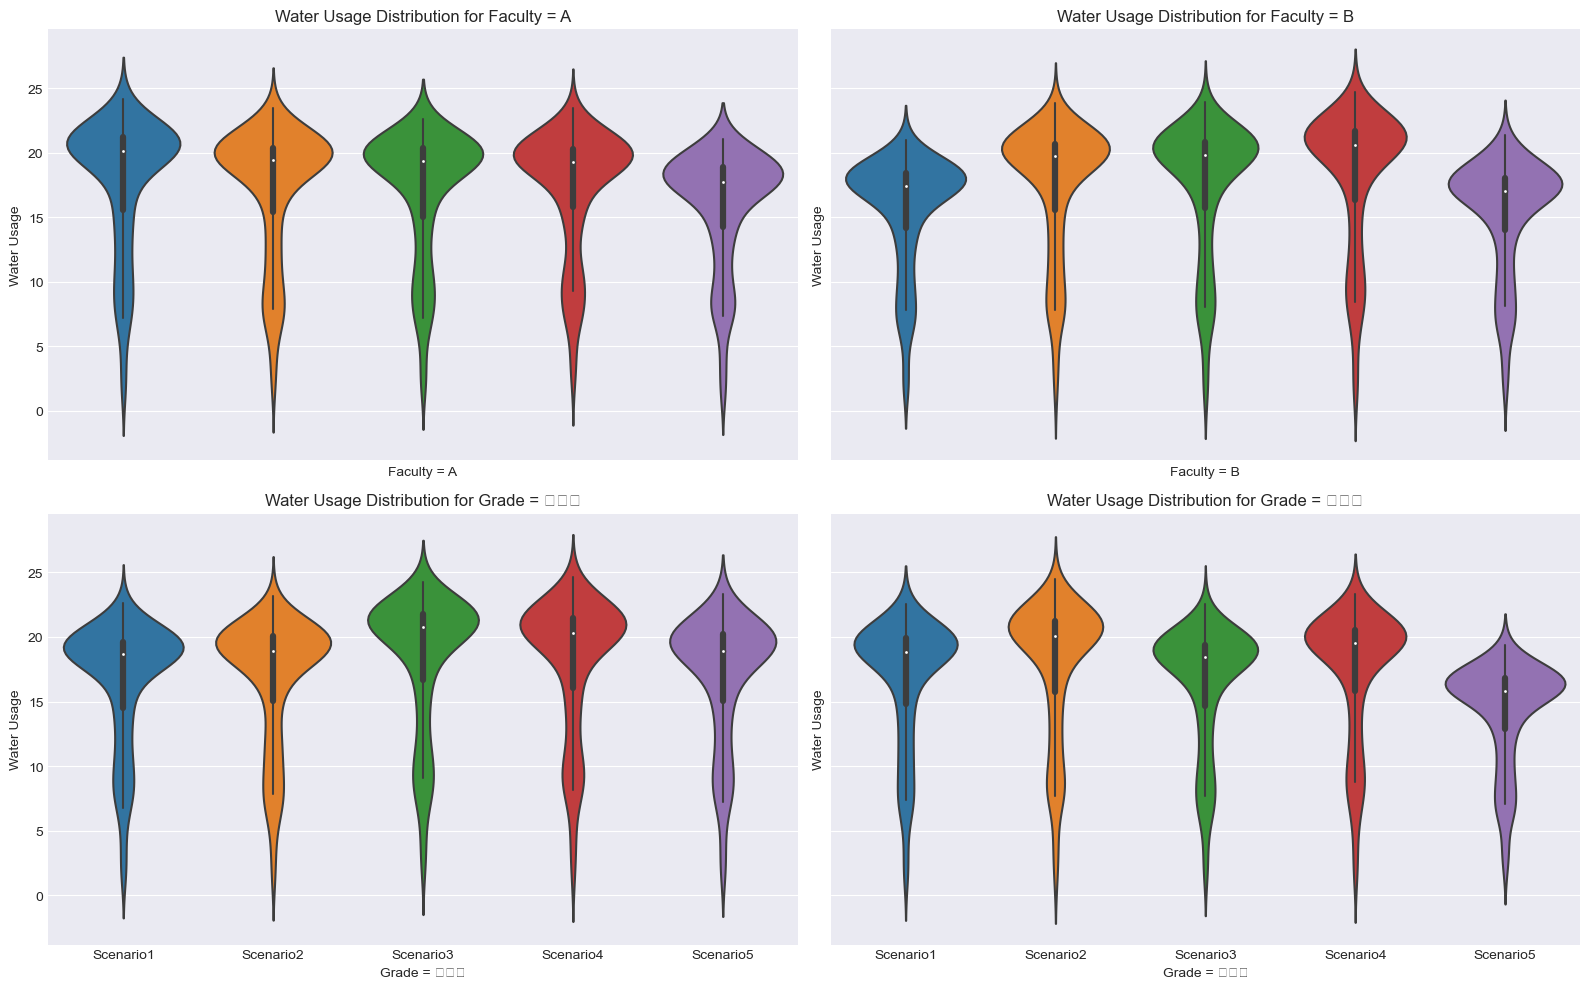

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from scipy import stats

df_all = pd.read_csv("0312_five_scenarios_raw_agent_data.csv")

# 假设 start_date 与模拟时一致
start_date = datetime.strptime("2023-05-19", "%Y-%m-%d")

# Scenario1 作为基线
scenarios = [
    ("Scenario1", "(0.6, 0.4)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario2", "(0.3, 0.7)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario3", "(0.6, 0.4)", "(7, 3)", "{'A': [10, 5], 'B': [10, 5]}"),
    ("Scenario4", "(0.6, 0.4)", "(8, 2)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario5", "(0.6, 0.4)", "(6, 4)", "{'A': [50, 25], 'B': [50, 25]}"),
]

# 定义过滤条件
filters = [
    ("Faculty", "A"),
    ("Faculty", "B"),
    ("Grade", "高年级"),
    ("Grade", "低年级")
]

# 设置阈值
THRESHOLD = 1

# 设置小提琴图
plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

for ax, (filter_key, filter_value) in zip(axes.flatten(), filters):
    # 为每个情境添加数据
    scenario1_data = []  # 用于保存 Scenario1 的数据
    scenario_data = {scenario[0]: [] for scenario in scenarios[1:]}  # 其他情境数据

    for (scenario_name, c_d, ne_ratio, ca_ratio) in scenarios:
        cond_scenario = (
            (df_all["c_d_ratio"] == c_d) &
            (df_all["normal_env_ratio"] == ne_ratio) &
            (df_all["course_attendance_ratio"] == ca_ratio) &
            (df_all[filter_key] == filter_value)
        )
        df_scenario = df_all[cond_scenario]

        # 筛选出用水量
        water_usage = df_scenario.groupby("Step")["WaterUsage"].sum() / 1000

        # 将小于阈值的值置为 NaN
        water_usage[water_usage < THRESHOLD] = np.nan

        # 将 Scenario1 的数据单独保存
        if scenario_name == "Scenario1":
            scenario1_data = water_usage.dropna()
        else:
            # 将其他情境的数据保存起来进行后续对比
            scenario_data[scenario_name] = water_usage.dropna()

    # 进行 Kruskal-Wallis 检验
    for scenario_name, data in scenario_data.items():
        if len(data) > 0 and len(scenario1_data) > 0:
            # 执行 Kruskal-Wallis 检验
            stat, p_value = stats.kruskal(scenario1_data, data)

            print(f"{filter_key} = {filter_value} - {scenario_name} vs Scenario1: Kruskal-Wallis p-value = {p_value}")

            if p_value < 0.005:
                print(f"有显著差异: {scenario_name} 与 Scenario1 差异显著")
            else:
                print(f"无显著差异: {scenario_name} 与 Scenario1 差异不显著")

    # 绘制小提琴图
    all_scenario_data = []
    all_scenario_labels = []

    for (scenario_name, c_d, ne_ratio, ca_ratio) in scenarios:
        cond_scenario = (
            (df_all["c_d_ratio"] == c_d) &
            (df_all["normal_env_ratio"] == ne_ratio) &
            (df_all["course_attendance_ratio"] == ca_ratio) &
            (df_all[filter_key] == filter_value)
        )
        df_scenario = df_all[cond_scenario]

        # 筛选出用水量
        water_usage = df_scenario.groupby("Step")["WaterUsage"].sum() / 1000

        # 将小于阈值的值置为 NaN
        water_usage[water_usage < THRESHOLD] = np.nan

        # 将数据与情境标签一起保存
        all_scenario_data.append(water_usage.dropna())
        all_scenario_labels.append(scenario_name)

    # 合并数据为 DataFrame 进行绘图
    scenario_df = pd.DataFrame({
        "WaterUsage": np.concatenate(all_scenario_data),
        "Scenario": np.concatenate([[label] * len(data) for label, data in zip(all_scenario_labels, all_scenario_data)])
    })

    # 绘制小提琴图
    sns.violinplot(x="Scenario", y="WaterUsage", data=scenario_df, ax=ax)

    ax.set_xlabel(f"{filter_key} = {filter_value}")
    ax.set_ylabel("Water Usage")
    ax.set_title(f"Water Usage Distribution for {filter_key} = {filter_value}")

# 调整布局
plt.tight_layout()
plt.show()


C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\2929828899.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\2929828899.py:93: UserWarning: Glyph 39640 (\N{CJK UNIFIED IDEOGRAPH-9AD8}) missing from current font.
  plt.tight_layout()
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\2929828899.py:93: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from current font.
  plt.tight_layout()
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\2929828899.py:93: UserWarning: Glyph 32423 (\N{CJK UNIFIED IDEOGRAPH-7EA7}) missing from current font.
  plt.tight_layout()
C:\Users\Huyc\AppData\Local\Temp\ipykernel_15960\2929828899.py:93: UserWarning: Glyph 20302 (\N{CJK UN

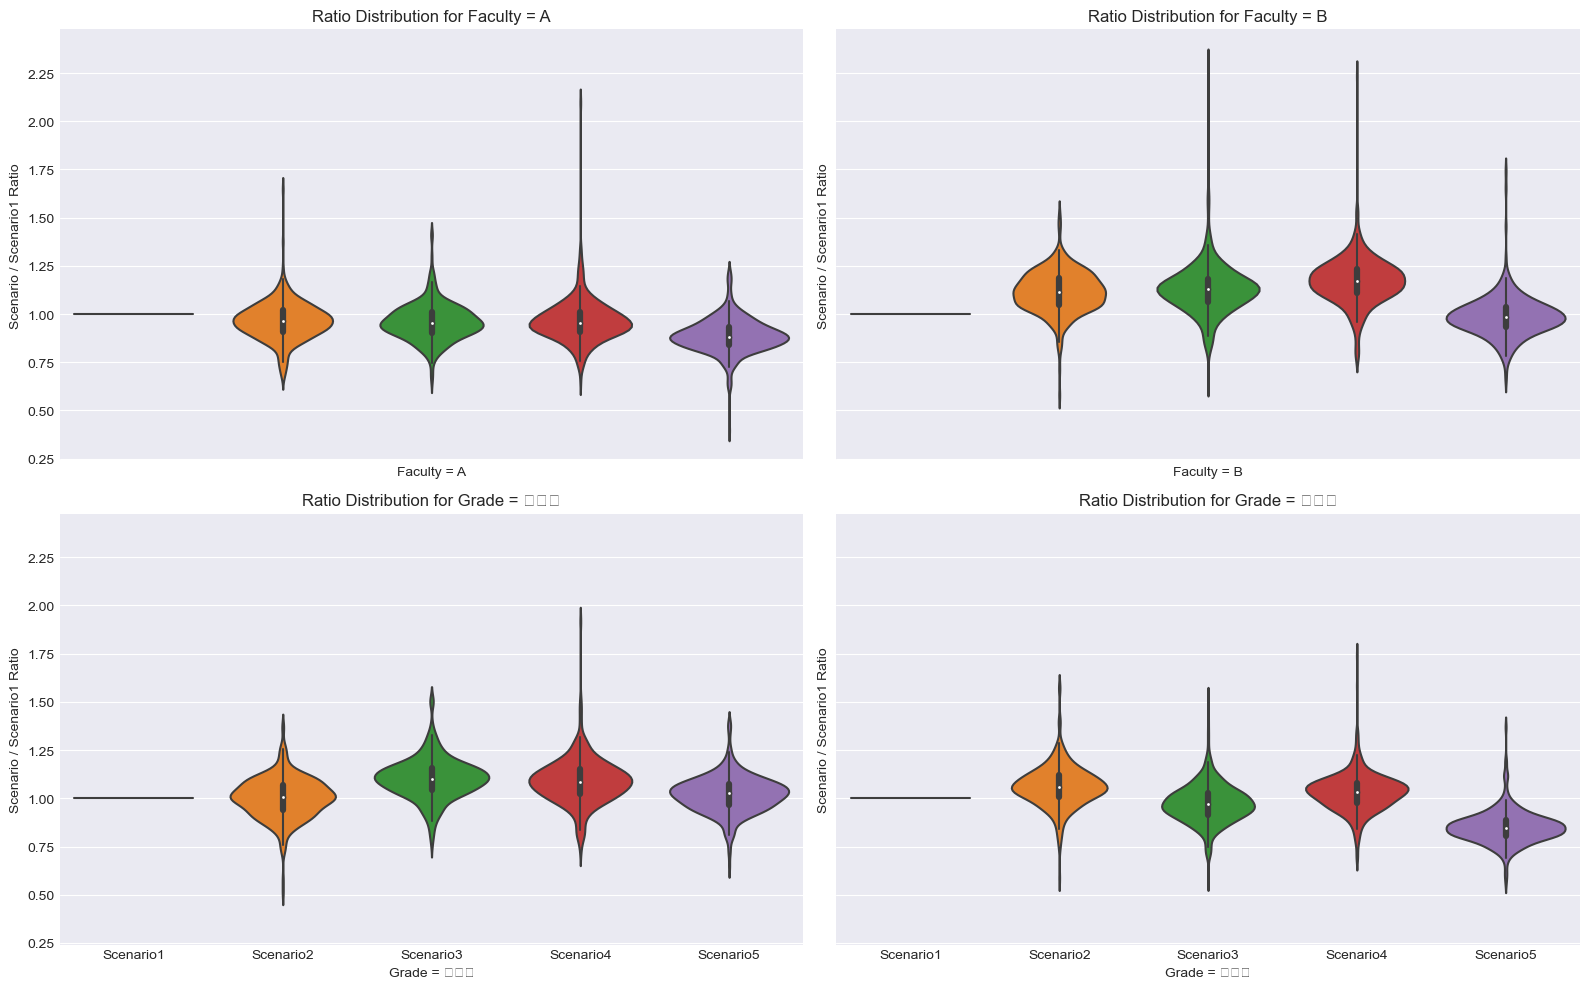

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from datetime import timedelta, datetime

df_all = pd.read_csv("0312_five_scenarios_raw_agent_data.csv")

# 假设 start_date 与模拟时一致
start_date = datetime.strptime("2023-05-19", "%Y-%m-%d")

# Scenario1 作为基线
scenarios = [
    ("Scenario1", "(0.6, 0.4)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario2", "(0.3, 0.7)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario3", "(0.6, 0.4)", "(7, 3)", "{'A': [10, 5], 'B': [10, 5]}"),
    ("Scenario4", "(0.6, 0.4)", "(8, 2)", "{'A': [50, 25], 'B': [50, 25]}"),
    ("Scenario5", "(0.6, 0.4)", "(6, 4)", "{'A': [50, 25], 'B': [50, 25]}"),
]

# 定义4个子图的过滤条件
filters = [
    ("Faculty", "A"),
    ("Faculty", "B"),
    ("Grade", "高年级"),
    ("Grade", "低年级")
]

# 设置阈值
THRESHOLD = 1000

# 设置小提琴图
plt.style.use('seaborn-darkgrid')
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharex=True, sharey=True)

# 取出 Scenario1 的信息
scenario1_info = scenarios[0]  # ("Scenario1", "(0.6, 0.4)", "(7, 3)", ...)

for ax, (filter_key, filter_value) in zip(axes.flatten(), filters):
    # 为每个情境添加数据
    all_scenario_data = []
    all_scenario_labels = []

    # ========== 获取 Scenario1 的基准数据 ========== 
    cond_scenario1 = (
        (df_all["c_d_ratio"] == scenario1_info[1]) &
        (df_all["normal_env_ratio"] == scenario1_info[2]) &
        (df_all["course_attendance_ratio"] == scenario1_info[3]) &
        (df_all[filter_key] == filter_value)
    )
    df_scenario1 = df_all[cond_scenario1]
    scenario1_grouped = df_scenario1.groupby("Step")["WaterUsage"].sum()

    # 遍历所有 Scenario 计算相对 Scenario1 的比例
    for (scenario_name, c_d, ne_ratio, ca_ratio) in scenarios:
        cond_scenario = (
            (df_all["c_d_ratio"] == c_d) &
            (df_all["normal_env_ratio"] == ne_ratio) &
            (df_all["course_attendance_ratio"] == ca_ratio) &
            (df_all[filter_key] == filter_value)
        )
        df_scenario = df_all[cond_scenario]
        scenario_grouped = df_scenario.groupby("Step")["WaterUsage"].sum()

        # 先进行阈值过滤
        scenario_grouped[scenario_grouped < THRESHOLD] = np.nan
        scenario1_grouped[scenario1_grouped < THRESHOLD] = np.nan
        
        # 对齐索引
        scenario_grouped = scenario_grouped.reindex(scenario1_grouped.index)

        # 计算相对比例
        ratio_series = scenario_grouped / scenario1_grouped

        # 将比例数据保存到列表中
        all_scenario_data.append(ratio_series.dropna())
        all_scenario_labels.append(scenario_name)

    # 合并数据为 DataFrame 进行绘图
    ratio_df = pd.DataFrame({
        "Ratio": np.concatenate(all_scenario_data),
        "Scenario": np.concatenate([[label] * len(data) for label, data in zip(all_scenario_labels, all_scenario_data)])
    })

    # 绘制小提琴图
    sns.violinplot(x="Scenario", y="Ratio", data=ratio_df, ax=ax)

    ax.set_xlabel(f"{filter_key} = {filter_value}")
    ax.set_ylabel("Scenario / Scenario1 Ratio")
    ax.set_title(f"Ratio Distribution for {filter_key} = {filter_value}")

# 调整布局
plt.tight_layout()
plt.show()


C:\Users\Huyc\AppData\Local\Temp\ipykernel_37464\1176574182.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['scenario_name'] = (
C:\Users\Huyc\AppData\Local\Temp\ipykernel_37464\1176574182.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['scenario_name'] = (
C:\Users\Huyc\AppData\Local\Temp\ipykernel_37464\1176574182.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

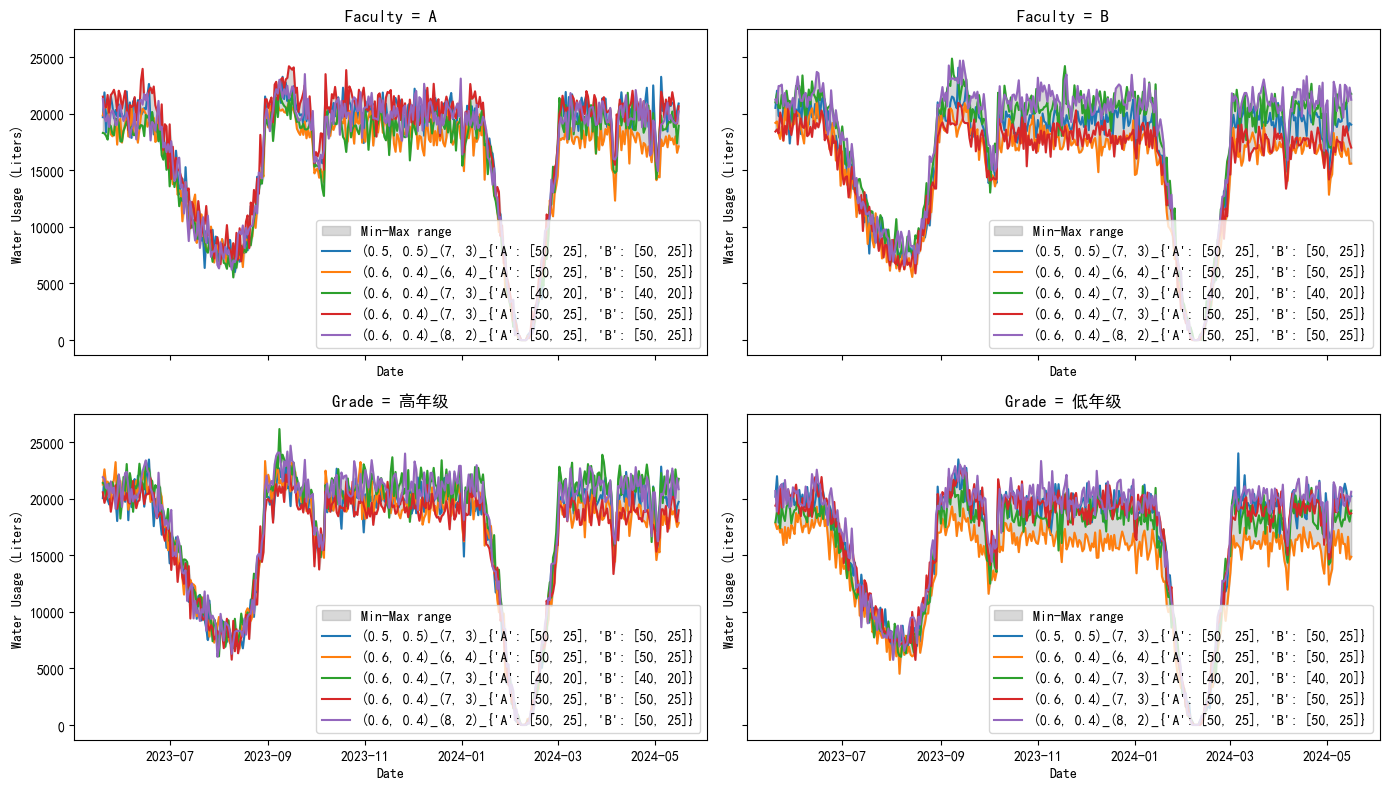

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(14,8), sharex=True, sharey=True)

subsets = [
    ("Faculty = A", df_all[df_all["Faculty"] == "A"]),
    ("Faculty = B", df_all[df_all["Faculty"] == "B"]),
    ("Grade = 高年级", df_all[df_all["Grade"] == "高年级"]),
    ("Grade = 低年级", df_all[df_all["Grade"] == "低年级"])
]

for ax, (title, df_sub) in zip(axes.flat, subsets):
    # 1) pivot
    df_sub['scenario_name'] = (
        df_sub['c_d_ratio'].astype(str) + "_" +
        df_sub['normal_env_ratio'].astype(str) + "_" +
        df_sub['course_attendance_ratio'].astype(str)
    )
    grouped = df_sub.groupby(['scenario_name','Step'])['WaterUsage'].sum().reset_index()
    pivoted = grouped.pivot(index='Step', columns='scenario_name', values='WaterUsage')

    # 2) 计算 min / max
    daily_min = pivoted.min(axis=1)
    daily_max = pivoted.max(axis=1)

    # 3) 将 Step 转成日期
    dates = [start_date + timedelta(days=int(s)) for s in pivoted.index]
    pivoted.index = dates
    daily_min.index = dates
    daily_max.index = dates

    # 4) fill_between
    ax.fill_between(dates, daily_min, daily_max, color='gray', alpha=0.3, label='Min-Max range')

    # 5) 画 5 条线
    for scenario_name in pivoted.columns:
        ax.plot(dates, pivoted[scenario_name], label=scenario_name)

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Water Usage (Liters)")
    ax.legend()

plt.tight_layout()
plt.show()


## 6.2 对于interval和num的更进一步探讨

In [171]:
import pandas as pd
import random, hashlib
import numpy as np
from datetime import datetime, timedelta

def run_simulation_extend(params, holiday_effects):
    """
    针对某个参数组合运行模型，并返回模型中 DataCollector 收集的原始代理数据。
    """
    # 基于参数生成唯一随机种子，保证结果可重复
    seed_str = str(params)
    seed_val = (int(hashlib.md5(seed_str.encode('utf-8')).hexdigest(), 16) + 0) % (2**32)
    random.seed(seed_val)
    np.random.seed(seed_val)

    # 解包参数（示例）
    c_d_ratio, normal_env_ratio, course_attendance_ratio,num_neighbor,interval_time = params

    # 初始化模型
    model = StudentModel(
        num_agents=400,
        start_date="2023-05-19",
        holiday_effects=holiday_effects,
        beta=7,
        normal_env_ratio=normal_env_ratio,
        num_neighbors=num_neighbor,
        c_d_ratio=c_d_ratio,
        interaction_interval=interval_time,
        course_attendance_ratio=course_attendance_ratio
    )

    # 运行模型 363 天
    for _ in range(363):
        model.step()

    # 从 DataCollector 获取所有代理在各时间步的数据
    df_agents = model.get_collected_data()  
    # 这时 df_agents 是一个多重索引的 DataFrame：
    #   索引: (Step, AgentID)
    #   列: [WaterUsage, Profile, Faculty, Grade, GreenEducation]

    # 可以在这里直接返回，后面再聚合或可视化
    return df_agents.reset_index()  # 转成普通 DataFrame，包含 Step、AgentID 等


In [172]:
import itertools
from tqdm import tqdm



# 固定前面的params，只调整 num_neighbor 和 interval_time
time_params_extend = list(itertools.product(
    [10, 20, 50 , 100],  # num_neighbor
    [30, 60, 90, 120]   # interval_time
))
selected_params_extend = [

    (selected_params[0][0], selected_params[0][1], selected_params[0][2], *params)
    for params in time_params_extend
]


all_data = []
for params in tqdm(selected_params_extend):
    df_agents = run_simulation_extend(params, holiday_effects)
    # 给结果加上本次情景的标识（便于后续区分）
    df_agents["num_neighbor"] = str(params[3])
    df_agents["interval_time"] = str(params[4])
    all_data.append(df_agents)

df_all = pd.concat(all_data, ignore_index=True)
# df_all 里就包含了所有代理、所有时间步、所有情景的详细数据
# 你可以保存一下
df_all.to_csv("0313_five_scenarios_raw_agent_data_16extend.csv", index=False)


100%|██████████| 16/16 [13:39<00:00, 51.20s/it]


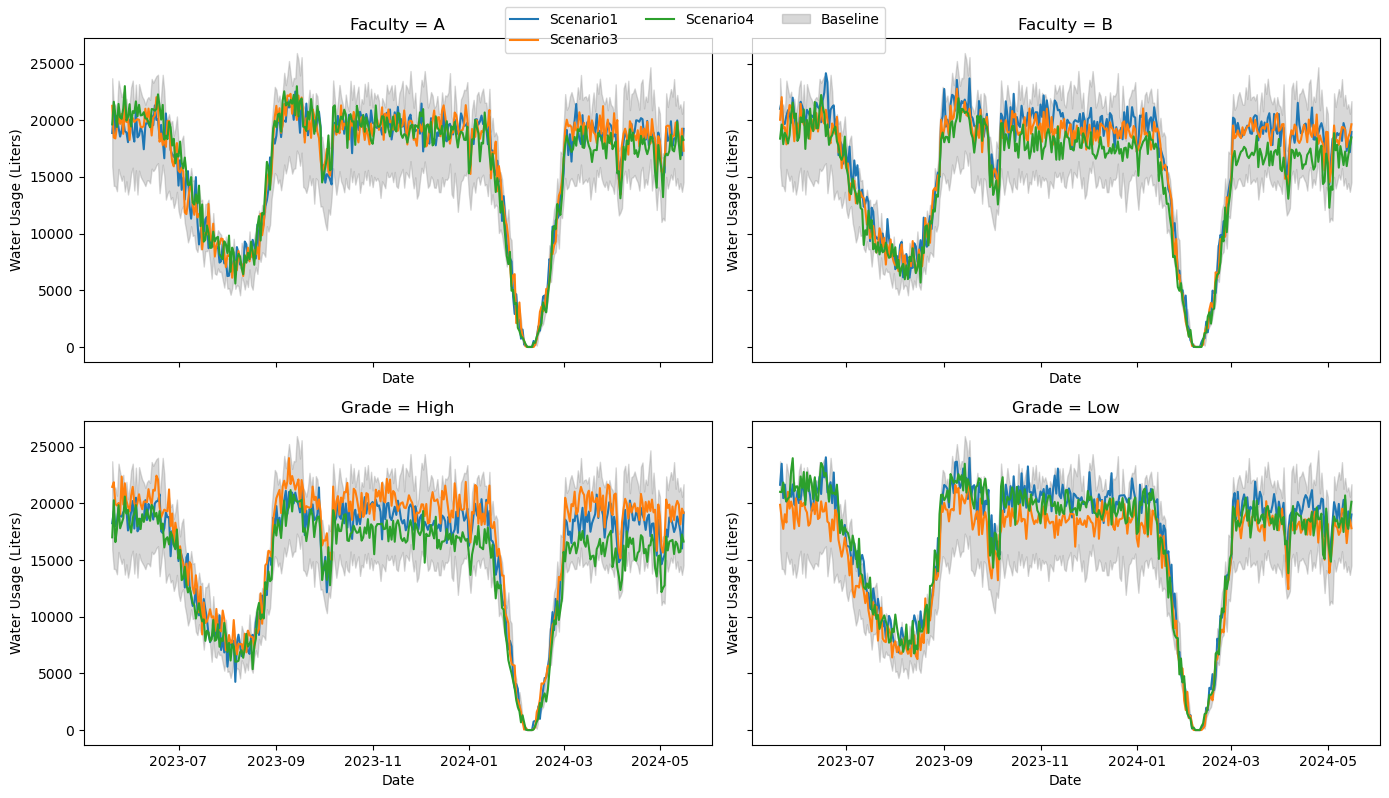

In [160]:
import matplotlib.pyplot as plt
from datetime import timedelta, datetime

# 假设 start_date 与模拟时一致
start_date = datetime.strptime("2023-05-19", "%Y-%m-%d")
scenarios = [
    ("Scenario1", "(0.6, 0.4)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}", 20, 90),
    ("Scenario3", "(0.6, 0.4)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}", 50, 90),
    ("Scenario4", "(0.6, 0.4)", "(7, 3)", "{'A': [50, 25], 'B': [50, 25]}", 20, 30),
]
# 读取基线数据
max_values = pd.read_csv('baseline_daily_usage_df_max.csv', index_col=0)
min_values = pd.read_csv('baseline_daily_usage_df_min.csv', index_col=0)
max_values.index = pd.to_datetime(max_values.index)
min_values.index = pd.to_datetime(min_values.index)

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)

# 第一个子图：Faculty = A
ax = axes[0, 0]
for scenario_name, c_d, ne_ratio, ca_ratio, neighbor, interval in scenarios:
    df_scenario = df_all[
        (df_all["Faculty"] == "A") &
        (df_all["num_neighbor"] == str(neighbor)) &
        (df_all["interval_time"] == str(interval))
    ]
    grouped = df_scenario.groupby("Step")["WaterUsage"].sum()
    grouped.index = [start_date + timedelta(days=int(s)) for s in grouped.index]
    ax.plot(grouped.index, grouped.values, label=scenario_name)

# 绘制基线阴影区域（min～max）
ax.fill_between(min_values.index, 
                min_values.iloc[:,0], 
                max_values.iloc[:,0], 
                color='gray', alpha=0.3, label='Baseline')
ax.set_title("Faculty = A")
ax.set_xlabel("Date")
ax.set_ylabel("Water Usage (Liters)")

# 第二个子图：Faculty = B
ax = axes[0, 1]
for scenario_name, c_d, ne_ratio, ca_ratio, neighbor, interval in scenarios:
    df_scenario = df_all[
        (df_all["Faculty"] == "B") &
        (df_all["num_neighbor"] == str(neighbor)) &
        (df_all["interval_time"] == str(interval))
    ]
    grouped = df_scenario.groupby("Step")["WaterUsage"].sum()
    grouped.index = [start_date + timedelta(days=int(s)) for s in grouped.index]
    ax.plot(grouped.index, grouped.values, label=scenario_name)

ax.fill_between(min_values.index, 
                min_values.iloc[:,0], 
                max_values.iloc[:,0], 
                color='gray', alpha=0.3, label='Baseline')
ax.set_title("Faculty = B")
ax.set_xlabel("Date")
ax.set_ylabel("Water Usage (Liters)")

# 第三个子图：Grade = 高年级
ax = axes[1, 0]
for scenario_name, c_d, ne_ratio, ca_ratio, neighbor, interval in scenarios:  
    df_scenario = df_all[
        (df_all["Grade"] == "高年级") &
        (df_all["num_neighbor"] == str(neighbor)) &
        (df_all["interval_time"] == str(interval))
    ]
    grouped = df_scenario.groupby("Step")["WaterUsage"].sum()
    grouped.index = [start_date + timedelta(days=int(s)) for s in grouped.index]
    ax.plot(grouped.index, grouped.values, label=scenario_name)

ax.fill_between(min_values.index, 
                min_values.iloc[:,0], 
                max_values.iloc[:,0], 
                color='gray', alpha=0.3, label='Baseline')
ax.set_title("Grade = High")
ax.set_xlabel("Date")
ax.set_ylabel("Water Usage (Liters)")

# 第四个子图：Grade = 低年级
ax = axes[1, 1]
for scenario_name, c_d, ne_ratio, ca_ratio, neighbor, interval in scenarios:  
    df_scenario = df_all[
        (df_all["Grade"] == "低年级") &
        (df_all["num_neighbor"] == str(neighbor)) &
        (df_all["interval_time"] == str(interval))
    ]
    grouped = df_scenario.groupby("Step")["WaterUsage"].sum()
    grouped.index = [start_date + timedelta(days=int(s)) for s in grouped.index]
    ax.plot(grouped.index, grouped.values, label=scenario_name)

ax.fill_between(min_values.index, 
                min_values.iloc[:,0], 
                max_values.iloc[:,0], 
                color='gray', alpha=0.3, label='Baseline')
ax.set_title("Grade = Low")
ax.set_xlabel("Date")
ax.set_ylabel("Water Usage (Liters)")

# 如果想把图例放在最外层，可以再单独加 legend
handles, labels = axes[1,1].get_legend_handles_labels()
# 图例与最上方距离远一点
fig.legend(handles, labels, loc='upper center', ncol=3)



plt.tight_layout()
plt.show()


In [173]:
import pandas as pd

# 1. 读取 CSV 文件
df = pd.read_csv("0313_five_scenarios_raw_agent_data_16extend.csv")

# 计算 baseline_data 的平均值
baseline_mean = baseline_df.mean(numeric_only=True).mean()
print(f"Baseline 平均用水量: {baseline_mean:.2f}")


# 2. 定义一个聚合函数，用于：
#   - 计算该组的平均用水量（avg_water_usage）
#   - 计算在 step=363 时 Profile='normal' 的比例（normal_ratio）
def custom_agg(group):
    # 该组每个step先求和，最终对step求平均
    avg_usage = group.groupby('Step')['WaterUsage'].sum()/1000
    avg_usage = avg_usage.mean()


    # 只筛选 step=363 的数据
    step_363_data = group[group['Step'] == 363]
    if len(step_363_data) > 0:
        # normal 的比例:step_363_data['Profile'] == 'normal'人数总和/总人数
        normal_ratio = step_363_data[step_363_data['Profile'] == 'normal'].shape[0] / step_363_data.shape[0]
        normal_ratio = normal_ratio * 100
    else:
        normal_ratio = 0.0

    return pd.Series({
        'avg_water_usage': avg_usage,
        'normal_ratio': normal_ratio
    })

grouped_df = df.groupby(['num_neighbor', 'interval_time']).apply(custom_agg).reset_index()


# 计算与 baseline_data 的百分比
grouped_df['water_usage_percentage'] = ((grouped_df['avg_water_usage'] / baseline_mean)-1) * 100
# 保存结果到 CSV
output_file = "grouped_water_usage_analysis_16extended.csv"
grouped_df.to_csv(output_file, index=False)
print(f"分组分析结果已保存到: {output_file}")

# 显示前几行数据
print(grouped_df.head())


Baseline 平均用水量: 31.36
分组分析结果已保存到: grouped_water_usage_analysis_16extended.csv
   num_neighbor  interval_time  avg_water_usage  normal_ratio  \
0            10             30        32.561872         23.00   
1            10             60        32.181740         43.25   
2            10             90        32.569796         42.75   
3            10            120        32.532598         52.00   
4            20             30        31.053522          0.75   

   water_usage_percentage  
0                3.841895  
1                2.629630  
2                3.867165  
3                3.748540  
4               -0.968330  


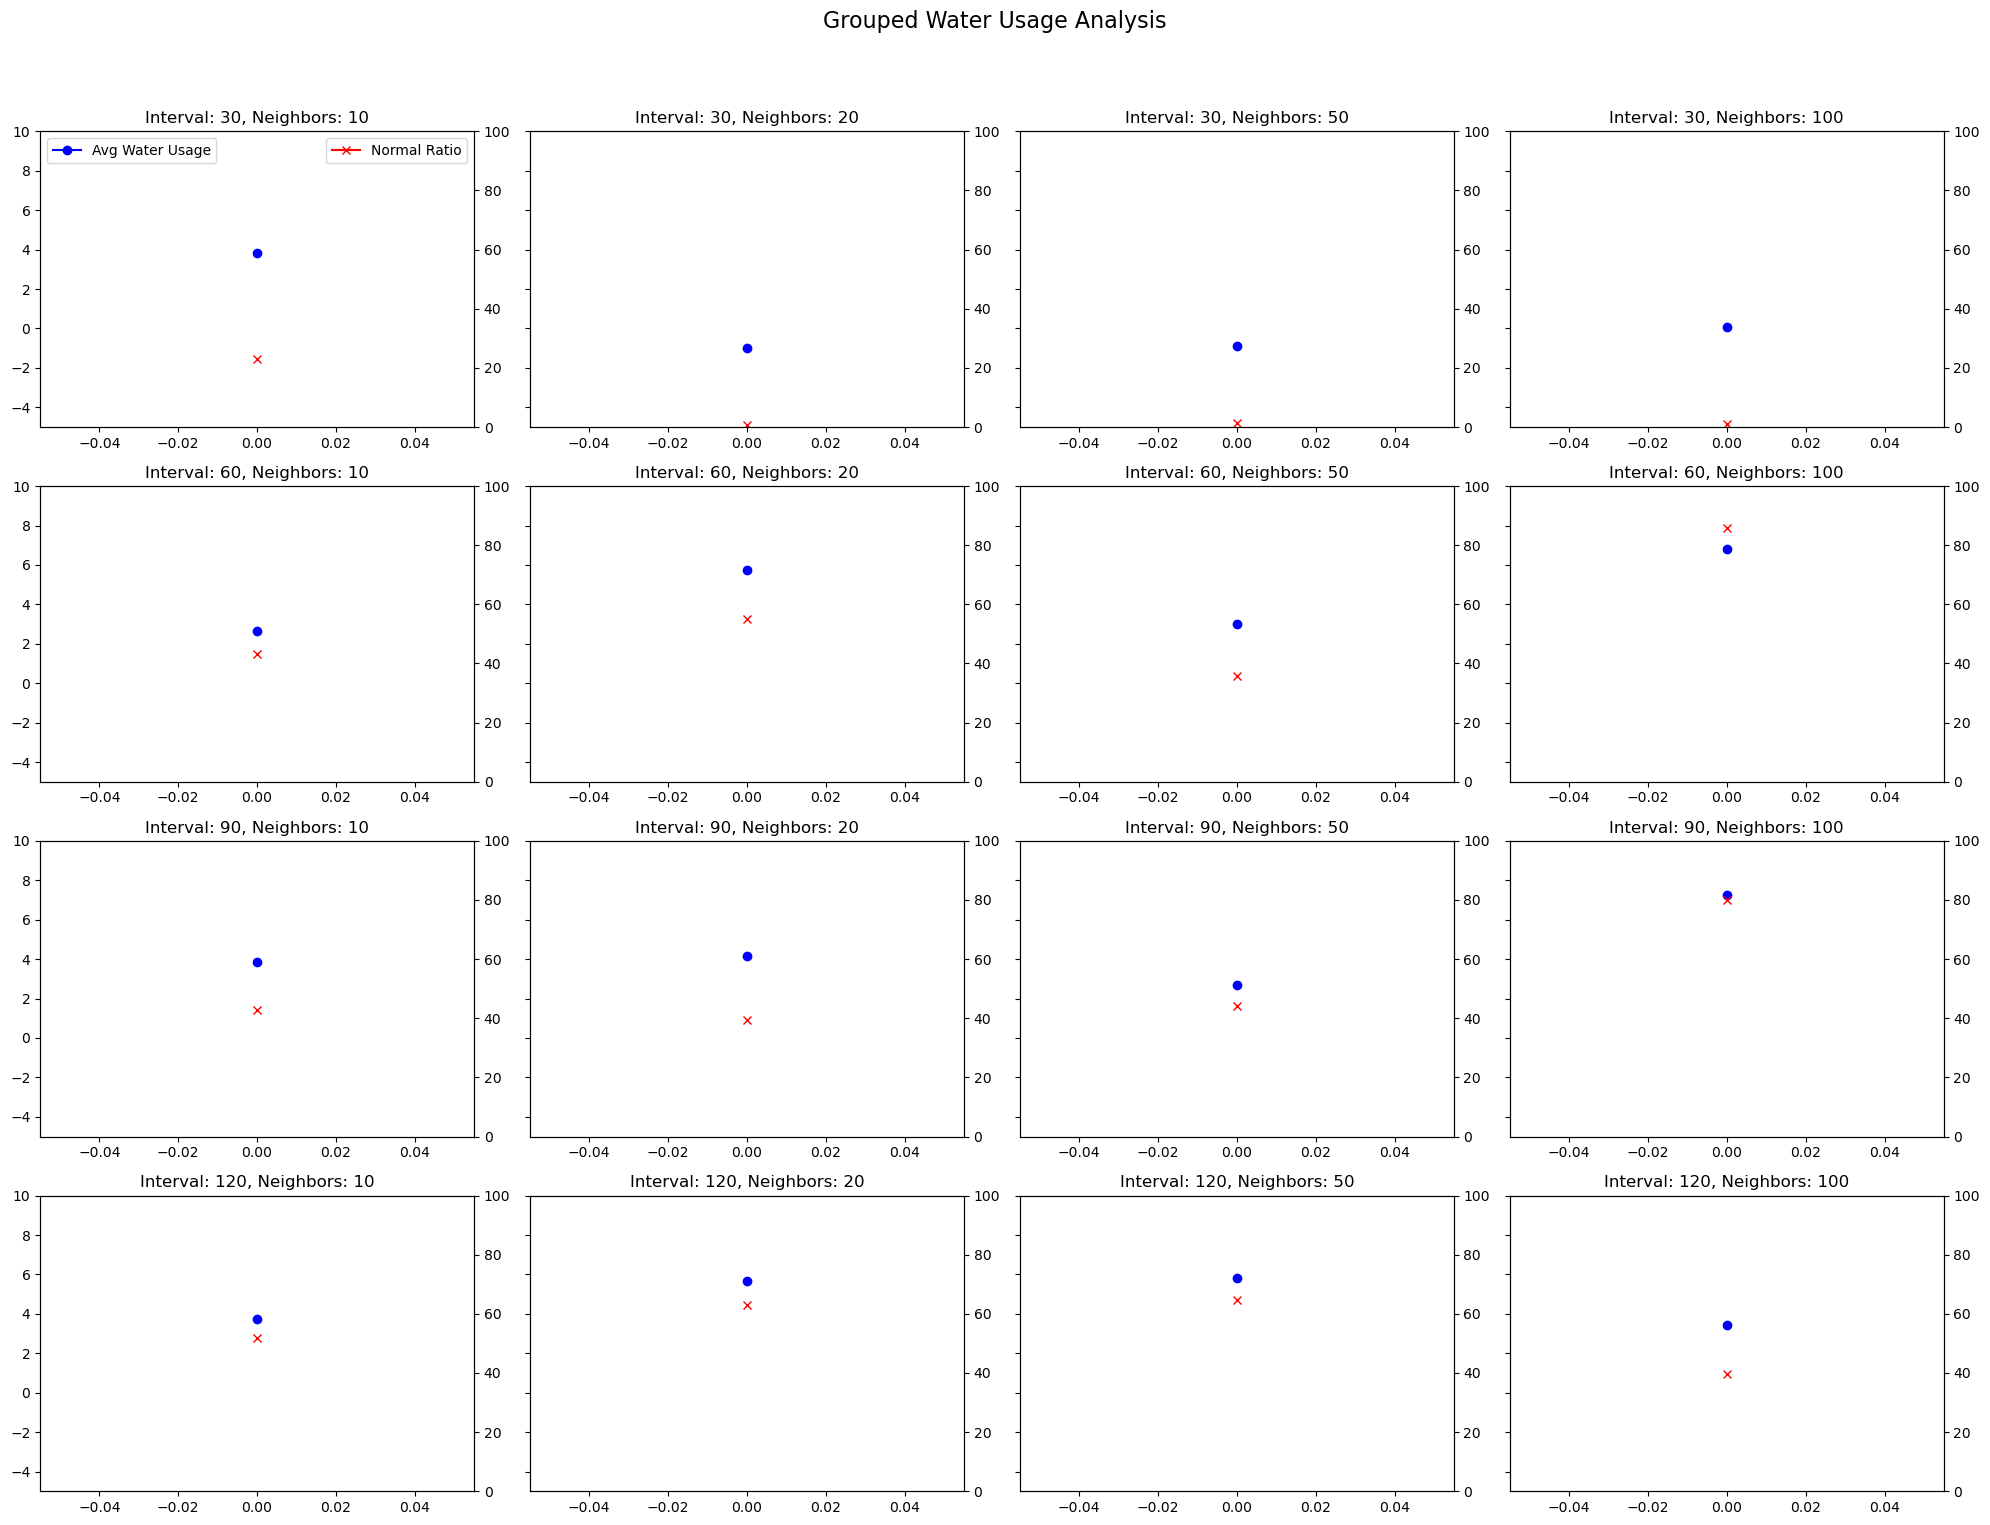

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv("grouped_water_usage_analysis_16extended.csv")

# 提取唯一的 interval_time 和 num_neighbor（分别对应行和列）
intervals = sorted(df['interval_time'].unique())
neighbors = sorted(df['num_neighbor'].unique())

# 创建子图网格，并使用 sharey=True 确保初始主 y 轴共享
fig, axes = plt.subplots(nrows=len(intervals), ncols=len(neighbors), 
                         sharey=True, figsize=(5 * len(neighbors), 4 * len(intervals)))

# 统一处理 axes 为二维数组
if len(intervals) == 1 and len(neighbors) == 1:
    axes = [[axes]]
elif len(intervals) == 1:
    axes = [axes]
elif len(neighbors) == 1:
    axes = [[ax] for ax in axes]

# 存储所有次 y 轴对象
twin_axes = []

for i, interval in enumerate(intervals):
    for j, neighbor in enumerate(neighbors):
        ax = axes[i][j]
        # 筛选对应 interval_time 和 num_neighbor 的数据
        sub_df = df[(df['interval_time'] == interval) & (df['num_neighbor'] == neighbor)]
        
        # 定义 x 轴，这里使用数据点的序号
        x = range(len(sub_df))
        
        # 绘制主 y 轴数据（例如 avg_water_usage）
        ax.plot(x, sub_df['water_usage_percentage'], label='Avg Water Usage', marker='o', color='b')
        ax.set_title(f"Interval: {interval}, Neighbors: {neighbor}")
        
        # 创建次 y 轴，用于展示 normal_ratio
        ax2 = ax.twinx()
        ax2.plot(x, sub_df['normal_ratio'], label='Normal Ratio', marker='x', color='r')
        twin_axes.append(ax2)
        
        # 添加图例（这里仅在第一个子图中添加示例）
        if i == 0 and j == 0:
            ax.legend(loc='upper left')
            ax2.legend(loc='upper right')
        
        # 设置左侧主 y 轴和右侧次 y 轴的刻度范围
        ax.set_ylim(-5, 10)
        ax2.set_ylim(0, 100)

# 设置整个图表的总标题，并调整布局
fig.suptitle("Grouped Water Usage Analysis", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


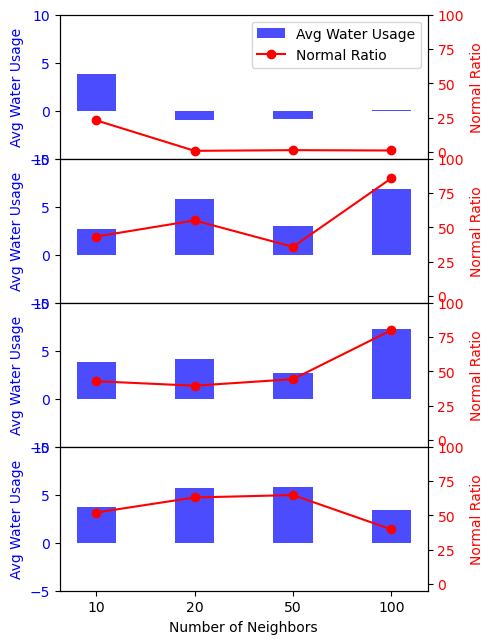

In [175]:
import pandas as pd
import matplotlib.pyplot as plt

# 使用默认样式确保白底
plt.style.use('default')

# 读取数据
df = pd.read_csv("grouped_water_usage_analysis_16extended.csv")

# 获取所有唯一的 interval_time 值，每个 interval_time 合并为一行图
intervals = sorted(df['interval_time'].unique())

# 创建子图2*2，每个 interval_time 一张图，设置整个图为正方形
fig, axes = plt.subplots(nrows=len(intervals), ncols=1, figsize=(4, 6))
fig.patch.set_facecolor('white')  # 设置白色背景

# 如果只有一个 interval_time，确保 axes 是列表
if len(intervals) == 1:
    axes = [axes]

for idx, interval in enumerate(intervals):
    ax = axes[idx]
    # 筛选当前 interval_time 的数据，并按 num_neighbor 排序
    sub_df = df[df['interval_time'] == interval].sort_values('num_neighbor')
    neighbors = list(sub_df['num_neighbor'].unique())
    x = range(len(neighbors))
    
    # 绘制左侧 y 轴：蓝色柱状图表示 water_usage_percentage
    ax.bar(x, sub_df['water_usage_percentage'], color='b', alpha=0.7, label='Avg Water Usage', width=0.4)
    ax.set_ylim(-5, 10)  # 固定左侧 y 轴范围
    ax.set_ylabel("Avg Water Usage", color='b')
    ax.tick_params(axis='y', labelcolor='b')
    
    # 仅最下面一行显示横轴刻度和标签，其余隐藏
    if idx == len(intervals) - 1:
        ax.set_xticks(x)
        ax.set_xticklabels(neighbors)
        ax.set_xlabel("Number of Neighbors")
    else:
        ax.set_xticks(x)
        ax.set_xticklabels([])
    
    # 创建次 y 轴，绘制红色折线图表示 normal_ratio
    ax2 = ax.twinx()
    ax2.plot(x, sub_df['normal_ratio'], color='r', marker='o', label='Normal Ratio')
    ax2.set_ylim(-5, 100)  # 固定右侧 y 轴范围
    ax2.set_ylabel("Normal Ratio", color='r')
    ax2.tick_params(axis='y', labelcolor='r')
    
    # 仅在第一张图中显示图例
    if idx == 0:
        lines, labels = ax.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax2.legend(lines + lines2, labels + labels2, loc='upper right')

# 取消子图之间的间隙，调整边距使图形紧凑
plt.subplots_adjust(hspace=0, left=0.06, right=0.98, top=0.98, bottom=0.02)
plt.show()


# 7. K-S检验与HSY敏感性分析

1-10四分位点为2.332337582；3-8是2.03


In [4]:
import numpy as np
import random
import scipy.stats as stats
import pandas as pd
from tqdm import tqdm  # 导入tqdm以显示进度条

# 参数定义
beta_min, beta_max = 1, 10
c_d_ratios = [(0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)]
normal_env_ratios = [(8, 2), (7, 3), (6, 4), (5, 5)]
course_attendance_ratios = [
    {"A": [15, 5], "B": [15, 5]},  # 原始比例
    {"A": [30, 15], "B": [30, 15]},  # 一倍比例
    {"A": [40, 20], "B": [40, 20]},  # 两倍比例
    {"A": [50, 30], "B": [50, 30]}   # 三倍比例
]
# Monte Carlo采样次数（建议提高采样数以获得更可靠的结果）
num_runs = 100
# 随机数种子
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载实景数据
actual_usage_file_path = 'filled_actual_usage.csv'  # 替换为你的实景数据文件路径
actual_usage_data = pd.read_csv(actual_usage_file_path, index_col=None)
actual_usage_data['ds'] = pd.to_datetime(actual_usage_data['ds'])
actual_usage_data = actual_usage_data.set_index('ds')

# 只取实景数据前365天
actual_usage_data = actual_usage_data.iloc[:363]

# 存储采样结果
results = []

# 目标函数阈值（例如：误差小于5认为“可接受”，该值需根据实际情况调整）
error_threshold = 2.3

# 用tqdm包装循环，显示进度条
for i in tqdm(range(num_runs), desc="Monte Carlo Runs"):
    # 随机采样参数
    beta_sample = np.random.uniform(beta_min, beta_max)
    c_d_ratio_sample = random.choice(c_d_ratios)
    normal_env_ratio_sample = random.choice(normal_env_ratios)
    
    # 对course_attendance_ratio基准比例乘以一个随机数（1~5倍）
    multiplier = np.random.uniform(1, 5)
    course_attendance_ratio_sample = random.choice(course_attendance_ratios)
    
    # 根据采样的参数创建模型（确保holiday_effects和actual_usage_data已提前加载）
    model = StudentModel(
         num_agents=400,
         start_date="2023-05-19",
         holiday_effects=holiday_effects, 
         beta=beta_sample,
         normal_env_ratio=normal_env_ratio_sample,
         num_neighbors=20,
         c_d_ratio=c_d_ratio_sample,
         interaction_interval=90,
         course_attendance_ratio=course_attendance_ratio_sample
    )
    
    # 运行模型一定步数（例如363天）
    num_steps = 363
    for _ in range(num_steps):
         model.step()
    
    # --- 计算全年的平均每日用水量 ---
    # 遍历所有agent的water_usage_history，按日期汇总所有agent的用水量
    daily_usage = {}
    for agent in model.schedule.agents:
        for day, usage in agent.water_usage_history:
            daily_usage[day] = daily_usage.get(day, 0) + usage
    if daily_usage:
        annual_avg_usage = np.mean(list(daily_usage.values()))/1000  # 转换为千升   
    else:
        annual_avg_usage = 0
    # ----------------------------------

    # 定义目标函数：计算模拟输出与实测数据全年平均每日用水量之间的绝对误差
    # 注意：这里假设实景数据中实际用水量字段名为 'actual_usage'
    actual_avg_usage = actual_usage_data['actual_usage'].mean() # 实景数据以升为单位，转换为千升
    error = abs(annual_avg_usage - actual_avg_usage)
    
    # 保存结果及采样参数
    results.append({
         'beta': beta_sample,
         'c_d_ratio': c_d_ratio_sample,
         'normal_env_ratio': normal_env_ratio_sample,
         'course_attendance_ratio': course_attendance_ratio_sample,
         'error': error,
         'result_type': 'accepted' if error <= error_threshold else 'rejected'
    })

# 将采样结果按目标函数误差划分为可接受和不可接受
accepted = [r for r in results if r['error'] <= error_threshold]
rejected = [r for r in results if r['error'] > error_threshold]

# 对每个参数进行KS检验
# 1. 对连续参数β
beta_accepted = [r['beta'] for r in accepted]
beta_rejected = [r['beta'] for r in rejected]
ks_stat_beta, p_value_beta = stats.ks_2samp(beta_accepted, beta_rejected)

# 2. 对c_d_ratio，由于为元组，这里取第一个元素作为比较指标
c_d_accepted = [r['c_d_ratio'][0] for r in accepted]
c_d_rejected = [r['c_d_ratio'][0] for r in rejected]
ks_stat_cd, p_value_cd = stats.ks_2samp(c_d_accepted, c_d_rejected)

# 3. 对normal_env_ratio，同样取第一个元素进行比较
normal_env_accepted = [r['normal_env_ratio'][0] for r in accepted]
normal_env_rejected = [r['normal_env_ratio'][0] for r in rejected]
ks_stat_ne, p_value_ne = stats.ks_2samp(normal_env_accepted, normal_env_rejected)

# 4. 对course_attendance_ratio，这里选择“A”组的第一个数值作为指标
course_attendance_accepted = [r['course_attendance_ratio']['A'][0] for r in accepted]
course_attendance_rejected = [r['course_attendance_ratio']['A'][0] for r in rejected]
ks_stat_ca, p_value_ca = stats.ks_2samp(course_attendance_accepted, course_attendance_rejected)

# 输出各参数的KS检验结果
print("β的KS检验：D值 =", ks_stat_beta, ", p-value =", p_value_beta)
print("c_d_ratio（第一个元素）的KS检验：D值 =", ks_stat_cd, ", p-value =", p_value_cd)
print("normal_env_ratio（第一个元素）的KS检验：D值 =", ks_stat_ne, ", p-value =", p_value_ne)
print("course_attendance_ratio（A组第一个元素）的KS检验：D值 =", ks_stat_ca, ", p-value =", p_value_ca)

# 将结果存储到Excel文件中
# 先将模拟结果转换为DataFrame
df_results = pd.DataFrame(results)
# 为方便阅读，把元组或字典字段转换为字符串表示
df_results['c_d_ratio'] = df_results['c_d_ratio'].apply(lambda x: str(x))
df_results['normal_env_ratio'] = df_results['normal_env_ratio'].apply(lambda x: str(x))
df_results['course_attendance_ratio'] = df_results['course_attendance_ratio'].apply(lambda x: str(x))

# 整理KS检验结果为DataFrame
ks_data = {
    "parameter": ["beta", "c_d_ratio", "normal_env_ratio", "course_attendance_ratio"],
    "ks_stat": [ks_stat_beta, ks_stat_cd, ks_stat_ne, ks_stat_ca],
    "p_value": [p_value_beta, p_value_cd, p_value_ne, p_value_ca]
}
df_ks = pd.DataFrame(ks_data)

# 使用ExcelWriter将两个DataFrame保存到一个Excel文件中
output_file = "HSY_sensitivity_analysis_results_0314.xlsx"
with pd.ExcelWriter(output_file) as writer:
    df_results.to_excel(writer, sheet_name="Simulation_Results", index=False)
    df_ks.to_excel(writer, sheet_name="KS_Test_Results", index=False)

print(f"所有结果已保存至Excel文件：{output_file}")


Monte Carlo Runs: 100%|██████████| 100/100 [41:57<00:00, 25.18s/it]

β的KS检验：D值 = 0.2375 , p-value = 0.30065917823681476
c_d_ratio（第一个元素）的KS检验：D值 = 0.1 , p-value = 0.9950932360818906
normal_env_ratio（第一个元素）的KS检验：D值 = 0.8375 , p-value = 4.190061244452441e-12
course_attendance_ratio（A组第一个元素）的KS检验：D值 = 0.0875 , p-value = 0.9993371090228632
所有结果已保存至Excel文件：HSY_sensitivity_analysis_results_0314.xlsx


In [ ]:
for r in results if r['error'] <= error_threshold:
    accepted.append(r)

SyntaxError: invalid syntax (1255334442.py, line 1)

In [ ]:
import ast
import numpy as np
import random
import scipy.stats as stats
import pandas as pd

error_threshold = 2.03

results = pd.read_excel("HSY_sensitivity_analysis_results_0313.xlsx")

# 将采样结果按目标函数误差划分为可接受和不可接受
accepted = [r for r in results.to_dict('records') if r['error'] <= error_threshold]
rejected = [r for r in results.to_dict('records') if r['error'] > error_threshold]

# 对每个参数进行KS检验
# 1. 对连续参数β
beta_accepted = [r['beta'] for r in accepted]
beta_rejected = [r['beta'] for r in rejected]
ks_stat_beta, p_value_beta = stats.ks_2samp(beta_accepted, beta_rejected)

# 2. 对c_d_ratio，由于为元组，这里取第一个元素作为比较指标
c_d_accepted = [ast.literal_eval(r['c_d_ratio'])[0] for r in accepted]
c_d_rejected = [ast.literal_eval(r['c_d_ratio'])[0] for r in rejected]
ks_stat_cd, p_value_cd = stats.ks_2samp(c_d_accepted, c_d_rejected)

# 3. 对normal_env_ratio，同样取第一个元素进行比较
normal_env_accepted = [ast.literal_eval(r['normal_env_ratio'])[0] for r in accepted]
normal_env_rejected = [ast.literal_eval(r['normal_env_ratio'])[0] for r in rejected]
ks_stat_ne, p_value_ne = stats.ks_2samp(normal_env_accepted, normal_env_rejected)

# 4. 对course_attendance_ratio，这里选择“A”组的第一个数值作为指标
course_attendance_accepted = [ast.literal_eval(r['course_attendance_ratio'])['A'][0] for r in accepted]
course_attendance_rejected = [ast.literal_eval(r['course_attendance_ratio'])['A'][0] for r in rejected]
ks_stat_ca, p_value_ca = stats.ks_2samp(course_attendance_accepted, course_attendance_rejected)

# 输出各参数的KS检验结果
print("β的KS检验：D值 =", ks_stat_beta, ", p-value =", p_value_beta)
print("c_d_ratio（第一个元素）的KS检验：D值 =", ks_stat_cd, ", p-value =", p_value_cd)
print("normal_env_ratio（第一个元素）的KS检验：D值 =", ks_stat_ne, ", p-value =", p_value_ne)
print("course_attendance_ratio（A组第一个元素）的KS检验：D值 =", ks_stat_ca, ", p-value =", p_value_ca)

# 将结果存储到Excel文件中
# 先将模拟结果转换为DataFrame
df_results = pd.DataFrame(results)
# 为方便阅读，把元组或字典字段转换为字符串表示
df_results['c_d_ratio'] = df_results['c_d_ratio'].apply(lambda x: str(x))
df_results['normal_env_ratio'] = df_results['normal_env_ratio'].apply(lambda x: str(x))
df_results['course_attendance_ratio'] = df_results['course_attendance_ratio'].apply(lambda x: str(x))

# 整理KS检验结果为DataFrame
ks_data = {
    "parameter": ["beta", "c_d_ratio", "normal_env_ratio", "course_attendance_ratio"],
    "ks_stat": [ks_stat_beta, ks_stat_cd, ks_stat_ne, ks_stat_ca],
    "p_value": [p_value_beta, p_value_cd, p_value_ne, p_value_ca]
}
df_ks = pd.DataFrame(ks_data)

# 使用ExcelWriter将两个DataFrame保存到一个Excel文件中
output_file = "HSY_sensitivity_analysis_results_0313.xlsx"
with pd.ExcelWriter(output_file) as writer:
    df_results.to_excel(writer, sheet_name="Simulation_Results", index=False)
    df_ks.to_excel(writer, sheet_name="KS_Test_Results", index=False)

print(f"所有结果已保存至Excel文件：{output_file}")

β的KS检验：D值 = 0.46236559139784944 , p-value = 0.08673594180569974
c_d_ratio（第一个元素）的KS检验：D值 = 0.08294930875576037 , p-value = 0.9999999920037785
normal_env_ratio（第一个元素）的KS检验：D值 = 0.8817204301075269 , p-value = 3.976121083981763e-06
course_attendance_ratio（A组第一个元素）的KS检验：D值 = 0.17050691244239632 , p-value = 0.9722695120420846
所有结果已保存至Excel文件：HSY_sensitivity_analysis_results_0314.xlsx


# 8.记录分解用水量的Agent和Model类

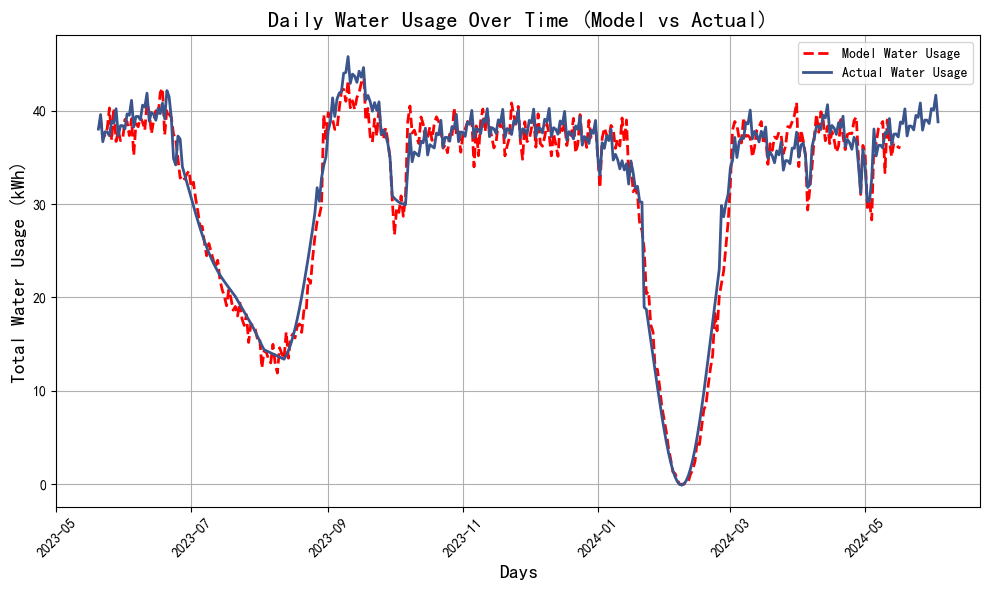

In [40]:
import random
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from numpy.random import normal
from mesa.datacollection import DataCollector  # 导入数据收集器，用于记录模型和主体的数据。
import networkx as nx


# 学生主体类
class StudentAgent(Agent):
    def __init__(self, unique_id, model, summer_start, summer_end, winter_start, winter_end, holiday_effects, profile="normal", grade=None, faculty=None, green_education=False, c_d_ratio=(0.5, 0.5)):
        """
        初始化学生主体。
        Args:
            unique_id (int): 学生唯一编号。
            model (Model): 模型对象。
            summer_start (str): 暑假开始日期（YYYY-MM-DD）。
            summer_end (str): 暑假结束日期（YYYY-MM-DD）。
            winter_start (str): 寒假开始日期（YYYY-MM-DD）。
            winter_end (str): 寒假结束日期（YYYY-MM-DD）。
            holiday_effects (dict): 假期效应字典，键为日期字符串（YYYY-MM-DD），值为假期类型。
            profile (str): 学生行为类型。
            grade (str): 学生年级。
            faculty (str): 学生专业。
            green_education (bool): 是否参与绿色教育课程。
            c_d_ratio (tuple): 行为效用中 c 与 d 的比率。
        """
        super().__init__(unique_id, model)
        self.is_on_campus = True  # 是否在校状态

        # 设置寒暑假信息
        self.summer_start = datetime.strptime(summer_start, "%Y-%m-%d")
        self.summer_end = datetime.strptime(summer_end, "%Y-%m-%d")
        self.winter_start = datetime.strptime(winter_start, "%Y-%m-%d")
        self.winter_end = datetime.strptime(winter_end, "%Y-%m-%d")

        # 假期效应和参数
        self.holiday_effects = holiday_effects

        # 社会学信息
        self.profile = profile
        self.grade = grade
        self.faculty = faculty
        self.green_education = green_education
        self.c, self.d = c_d_ratio

        # 基础用水量
        self.base_consumption = self.calculate_base_consumption()

        # 用于保存每天的用水数据，便于数据收集
        self.last_water_usage = 0
        self.last_base_usage = 0
        self.last_extra_usage = 0

        # 每天淋浴和洗衣服的概率
        self.shower_probs = [0.63, 0.66, 0.66, 0.65, 0.62, 0.62, 0.64]
        self.laundry_probs = [0.40, 0.40, 0.40, 0.40, 0.45, 0.45, 0.45]

        # 内嵌的暑假和寒假多项式系数
        self._summer_coefficients = [8.60987857e-01, 1.36859624e-02, -1.99858329e-03, 5.92193526e-05, -7.76982757e-07, 3.99970679e-09]
        self._winter_coefficients = [0.7645638874513381, -0.0013731766863659181, -0.0057098630785314556, 0.00027673512470457806, -4.405621735518008e-06, 2.3663790433562584e-08]
        self.summer_probability_poly = Polynomial(self._summer_coefficients)
        self.winter_probability_poly = Polynomial(self._winter_coefficients)

        # 用于记录每日用水量历史（元组格式： (日期, 用水数据字典)）
        self.water_usage_history = []


    def calculate_behavior_utilities(self, neighbors_behavior):
        """
        根据邻居行为计算行为效用。
        """
        V_env = neighbors_behavior["environmentalist"]
        V_normal = neighbors_behavior["normal"]

        # 根据是否接受绿色教育，获取行为效用的系数【这个系数设置的太小，会使得转变和不转变受到邻居的影响较小，同样 a/b/c/d 不要求加起来和为1】
        if self.green_education:
            a, b, c, d = 0.7, 0.3, self.c, self.d
        else:
            a, b, c, d = 0.7, 0.3, 0.3, 0.7

        e = 0
        if self.faculty == "B":
            student_avg_usage = self.get_water_usage_last30_days()
            global_avg_usage = self.model.get_global_water_usage_last30_days()
            if global_avg_usage > 0:
                e = 1.5 * max(0, student_avg_usage / global_avg_usage - 1)

        if self.profile == "environmentalist":
            U_env_to_env = a * V_env + e
            U_env_to_normal = b * V_normal
            return U_env_to_env, U_env_to_normal
        else:  # self.profile == "normal"
            U_normal_to_env = c * V_env + e
            U_normal_to_normal = d * V_normal
            return U_normal_to_env, U_normal_to_normal

    def calculate_base_consumption(self):
        """定义基础设备的每日用水量（单位：升）。"""
        if self.profile == "environmentalist":
            base_usage = {"toilet": 10, "sink": 15}
        else:  # profile == "normal"
            base_usage = {"toilet": 17, "sink": 30}
        return sum(base_usage.values())

    def calculate_daily_water_usage(self):
        """
        计算每日用水量，并返回一个字典：
            - total: 加入噪声后的总用水量（基础+额外）
            - base: 基础用水量（不含噪声）
            - extra: 洗澡和洗衣服的额外用水量（不含噪声）
        """
        if not self.is_on_campus:
            return {"total": 0, "base": 0, "extra": 0}
        day_of_week = self.model.current_date.weekday()
        base_usage = self.base_consumption

        # 根据 profile 设置额外用水量参数
        if self.profile == "environmentalist":
            shower_usage = 50
            laundry_usage = 70
        else:  # profile == "normal"
            shower_usage = 70
            laundry_usage = 90

        extra_shower = shower_usage if random.random() < self.shower_probs[day_of_week] else 0
        extra_laundry = laundry_usage if random.random() < self.laundry_probs[day_of_week] else 0
        extra_usage = extra_shower + extra_laundry
        total_usage = base_usage + extra_usage

        # 加入正态分布随机扰动（均值为 total_usage，标准差为 5% 的 total_usage）
        total_usage_with_noise = max(0, normal(total_usage, total_usage * 0.05))
        return {"total": total_usage_with_noise, "base": base_usage, "extra": extra_usage}

    def update_on_campus_status(self):
        current_date = self.model.current_date
        if self.summer_start <= current_date <= self.summer_end:
            day_count = (current_date - self.summer_start).days
            on_campus_probability = self.summer_probability_poly(day_count)
        elif self.winter_start <= current_date <= self.winter_end:
            day_count = (current_date - self.winter_start).days
            on_campus_probability = self.winter_probability_poly(day_count)
        else:
            if current_date in self.holiday_effects:
                daily_effect = sum(self.holiday_effects[current_date].values())
                on_campus_probability = 0.85 + daily_effect
            else:
                on_campus_probability = np.random.normal(0.85, 0.01)
        on_campus_probability = max(0, min(on_campus_probability, 1))
        self.is_on_campus = np.random.rand() < on_campus_probability

    def get_water_usage_last30_days(self):
        """
        计算过去30天的平均用水量（总量）。
        如果记录不足30天，则以实际记录天数计算。
        """
        cutoff_date = self.model.current_date - timedelta(days=30)
        usage_values = [data["total"] for (date, data) in self.water_usage_history if date > cutoff_date and data["total"] > 0]
        if usage_values:
            return sum(usage_values) / len(usage_values)
        else:
            return 0

    def step(self):
        """
        每日执行更新：
         1. 更新在校状态
         2. 计算当天的用水量（基础和额外）并记录
        """
        self.update_on_campus_status()
        usage_data = self.calculate_daily_water_usage()
        self.last_water_usage = usage_data["total"]
        self.last_base_usage = usage_data["base"]
        self.last_extra_usage = usage_data["extra"]
        self.water_usage_history.append((self.model.current_date, usage_data))
        

class StudentModel(Model):
    def __init__(self, num_agents, start_date, holiday_effects, beta=1.0, normal_env_ratio=(7, 3), num_neighbors=4, c_d_ratio=(0.5, 0.5), interaction_interval=30, course_attendance_ratio=None):
        super().__init__()
        self.num_agents = num_agents
        self.holiday_effects = holiday_effects
        self.schedule = RandomActivation(self)
        
        # 初始化模拟开始日期
        self.current_date = datetime.strptime(start_date, "%Y-%m-%d")

        # 社会学比例
        self.faculty_total_ratio = {"A": [100, 100], "B": [100, 100]}
        self.course_attendance_ratio = course_attendance_ratio if course_attendance_ratio else {
            "A": [30, 15],
            "B": [30, 15]
        }
        
        # 创建数据收集器：修改agent_reporters，记录总用水量、基础用水量以及额外用水量
        self.datacollector = DataCollector(
            agent_reporters={
                "TotalWaterUsage": lambda a: a.last_water_usage,
                "BaseConsumption": lambda a: a.last_base_usage,
                "ExtraWaterUsage": lambda a: a.last_extra_usage,
                "Profile": lambda a: a.profile,
                "Faculty": lambda a: a.faculty,
                "Grade": lambda a: a.grade,
                "GreenEducation": lambda a: a.green_education
            }
        )

        self.interaction_groups = []  # 存储分组信息
        self.beta = beta
        self.num_neighbors = num_neighbors
        self.c_d_ratio = c_d_ratio
        self.interaction_interval = interaction_interval
        self.normal_env_ratio = normal_env_ratio
        self.create_agents()

    def create_agents(self):
        """创建学生主体并加入调度器。"""
        for i in range(self.num_agents):
            faculty, grade = self.assign_faculty_and_grade()
            green_education = self.assign_green_education(faculty, grade)
            profile = self.assign_profile()
            summer_start, summer_end = "2023-06-11", "2023-08-29"
            winter_start, winter_end = "2024-01-15", "2024-03-01"
            agent = StudentAgent(
                unique_id=i,
                model=self,
                summer_start=summer_start,
                summer_end=summer_end,
                winter_start=winter_start,
                winter_end=winter_end,
                holiday_effects=self.holiday_effects,
                profile=profile,
                grade=grade,
                faculty=faculty,
                green_education=green_education,
                c_d_ratio=self.c_d_ratio
            )
            self.schedule.add(agent)

    def assign_faculty_and_grade(self):
        """根据比例随机分配专业和年级。"""
        faculty = random.choices(population=list(self.faculty_total_ratio.keys()),
                                 weights=[sum(self.faculty_total_ratio[f]) for f in self.faculty_total_ratio])[0]
        grade = random.choices(population=["低年级", "高年级"], weights=self.faculty_total_ratio[faculty])[0]
        return faculty, grade

    def assign_green_education(self, faculty, grade):
        """根据课程比例决定是否参加绿色教育。"""
        grades = ["低年级", "高年级"]
        grade_index = grades.index(grade)
        course_ratio = self.course_attendance_ratio[faculty][grade_index]
        total_students_in_grade = self.faculty_total_ratio[faculty][grade_index]
        return random.random() < (course_ratio / total_students_in_grade)

    def assign_profile(self):
        """根据外部输入的比例分配 Normal 和 Environmentalist。"""
        normal_weight, env_weight = self.normal_env_ratio
        return random.choices(population=["normal", "environmentalist"], weights=[normal_weight, env_weight])[0]
        
    def create_interaction_groups(self):
        """根据小世界网络生成代理的交互组"""
        G = nx.watts_strogatz_graph(self.num_agents, self.num_neighbors, 0.2)
        for node in G.nodes():
            agent = self.schedule.agents[node]
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if agent.grade == self.schedule.agents[neighbor].grade:
                    G[node][neighbor]['weight'] = 2
                elif agent.faculty == self.schedule.agents[neighbor].faculty:
                    G[node][neighbor]['weight'] = 1.5
                elif agent.green_education == self.schedule.agents[neighbor].green_education:
                    G[node][neighbor]['weight'] = 1.5
                else:
                    G[node][neighbor]['weight'] = 1

        self.interaction_groups = []
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            group = [(self.schedule.agents[node], [self.schedule.agents[neighbor] for neighbor in neighbors])]
            self.interaction_groups.append(group)
        
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if node not in list(G.neighbors(neighbor)):
                    print(f"Warning: Node {node} and Node {neighbor} are not bidirectional.")
        
    def interact_agents(self):
        """处理每组内的交互逻辑。"""
        updates = []
        for group in self.interaction_groups:
            for agent, neighbors in group:
                neighbors_behavior = {
                    "environmentalist": sum(1 for a in neighbors if a.profile == "environmentalist") / len(neighbors),
                    "normal": sum(1 for a in neighbors if a.profile == "normal") / len(neighbors),
                }
                if agent.profile == "environmentalist":
                    U_env_to_env, U_env_to_normal = agent.calculate_behavior_utilities(neighbors_behavior)
                    U_env_to_env *= self.beta
                    U_env_to_normal *= self.beta
                    P_env_to_env = np.exp(U_env_to_env) / (np.exp(U_env_to_env) + np.exp(U_env_to_normal))
                    updates.append((agent, "environmentalist" if random.random() < P_env_to_env else "normal"))
                else:
                    U_normal_to_env, U_normal_to_normal = agent.calculate_behavior_utilities(neighbors_behavior)
                    U_normal_to_env *= self.beta
                    U_normal_to_normal *= self.beta
                    P_normal_to_env = np.exp(U_normal_to_env) / (np.exp(U_normal_to_env) + np.exp(U_normal_to_normal))
                    updates.append((agent, "environmentalist" if random.random() < P_normal_to_env else "normal"))
        for agent, new_profile in updates:
            agent.profile = new_profile
    
    def get_global_water_usage_last30_days(self):
        """计算所有代理过去30天的平均用水量（总量）。"""
        valid_averages = []
        for agent in self.schedule.agents:
            usage = agent.get_water_usage_last30_days()
            if usage > 0:
                valid_averages.append(usage)
        if valid_averages:
            return sum(valid_averages) / len(valid_averages)
        else:
            return 0

    def step(self):
        """运行模型单步。"""
        self.current_date += timedelta(days=1)
        if (self.current_date - datetime.strptime("2023-05-19", "%Y-%m-%d")).days % self.interaction_interval == 0:
            self.create_interaction_groups()
            self.interact_agents()
        self.schedule.step()
        self.datacollector.collect(self)


# 以下部分为数据加载、模型运行与结果绘图
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载实景数据
actual_usage_file_path = 'filled_actual_usage.csv'
actual_usage_data = pd.read_csv(actual_usage_file_path, index_col=None)
actual_usage_data['ds'] = pd.to_datetime(actual_usage_data['ds'])
actual_usage_data = actual_usage_data.set_index('ds')
actual_usage_data = actual_usage_data.iloc[:363]

# 运行模型
model = StudentModel(num_agents=400, 
                     start_date="2023-05-20", 
                     holiday_effects=holiday_effects, 
                     beta=7, 
                     normal_env_ratio=(6, 4), 
                     num_neighbors=20, 
                     c_d_ratio=(0.5, 0.5),
                     interaction_interval=90)

# 运行363天的模拟
for _ in range(363):
    model.step()
    # 注意：由于在step方法中已经收集数据，此处可不再额外调用
    # model.datacollector.collect(model)

# 获取代理变量数据并进行汇总
water_data = model.datacollector.get_agent_vars_dataframe()

# 按步骤汇总每个代理的 TotalWaterUsage
daily_usage = water_data.groupby("Step")["TotalWaterUsage"].sum() / 1000  # 单位转换（例如：升转成kWh或其他单位）

# 将 step 转换为实际日期
daily_usage.index = [model.current_date - timedelta(days=(363 - step)) for step in daily_usage.index]
daily_usage.index.name = 'ds'

model_data = daily_usage.to_frame()

# 对齐实景数据
model_data = model_data.join(actual_usage_data['actual_usage'], how='left')

# 绘制模型与实景数据对比图
plt.figure(figsize=(10, 6))
plt.plot(model_data.index, model_data['TotalWaterUsage'], color='r', lw=2, linestyle='--', label='Model Water Usage')
plt.plot(actual_usage_data.index, actual_usage_data['actual_usage'], color='#3A548C', lw=2, label='Actual Water Usage')
plt.title("Daily Water Usage Over Time (Model vs Actual)", fontsize=16)
plt.xlabel("Days", fontsize=14)
plt.ylabel("Total Water Usage (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()


## 8.1 绘图季节性+基础用水变化

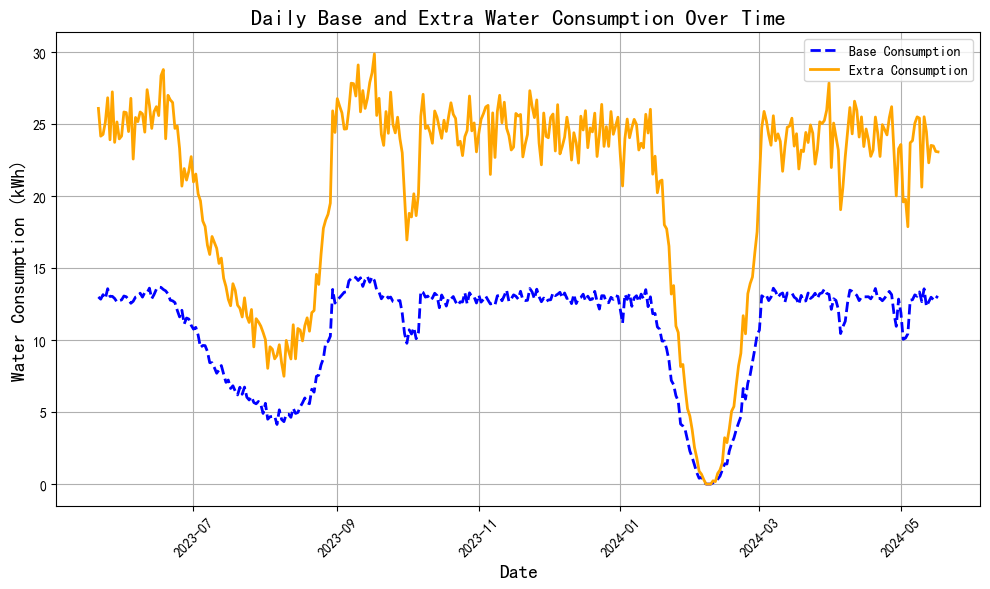

In [41]:
# 获取代理变量数据
water_data = model.datacollector.get_agent_vars_dataframe()

# 汇总每日基础用水量和额外用水量（这里按所有代理求和，可根据需要改为求均值或其他统计量）
daily_base = water_data.groupby("Step")["BaseConsumption"].sum() / 1000   # 单位转换，例如：升转为kWh
daily_extra = water_data.groupby("Step")["ExtraWaterUsage"].sum() / 1000

# 将 Step 转换为实际日期（假设模拟共运行363天）
dates = [model.current_date - timedelta(days=(363 - step)) for step in daily_base.index]
dates = pd.to_datetime(dates)
daily_base.index = dates
daily_extra.index = dates

# 绘制基础用水和额外用水的时间图
plt.figure(figsize=(10, 6))
plt.plot(daily_base.index, daily_base, lw=2, linestyle='--', color='blue', label='Base Consumption')
plt.plot(daily_extra.index, daily_extra, lw=2, linestyle='-', color='orange', label='Extra Consumption')
plt.title("Daily Base and Extra Water Consumption Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Water Consumption (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



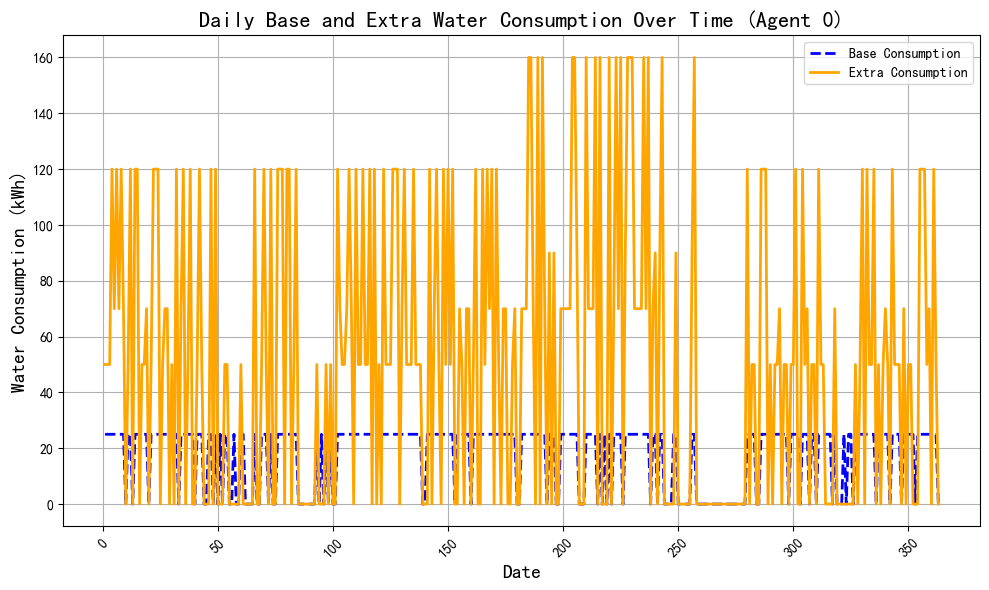

In [46]:
# 一个agent的基础用水量和额外用水量绘图
agent_data = model.datacollector.get_agent_vars_dataframe()
agent_data = agent_data.xs(0, level="AgentID")  # 选择第一个代理人的数据

# 绘制基础用水和额外用水的时间图
plt.figure(figsize=(10, 6))
plt.plot(agent_data.index, agent_data['BaseConsumption'], lw=2, linestyle='--', color='blue', label='Base Consumption')
plt.plot(agent_data.index, agent_data['ExtraWaterUsage'], lw=2, linestyle='-', color='orange', label='Extra Consumption')

plt.title("Daily Base and Extra Water Consumption Over Time (Agent 0)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Water Consumption (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()

plt.tight_layout()
plt.show()


## 8.2 再细分用水量

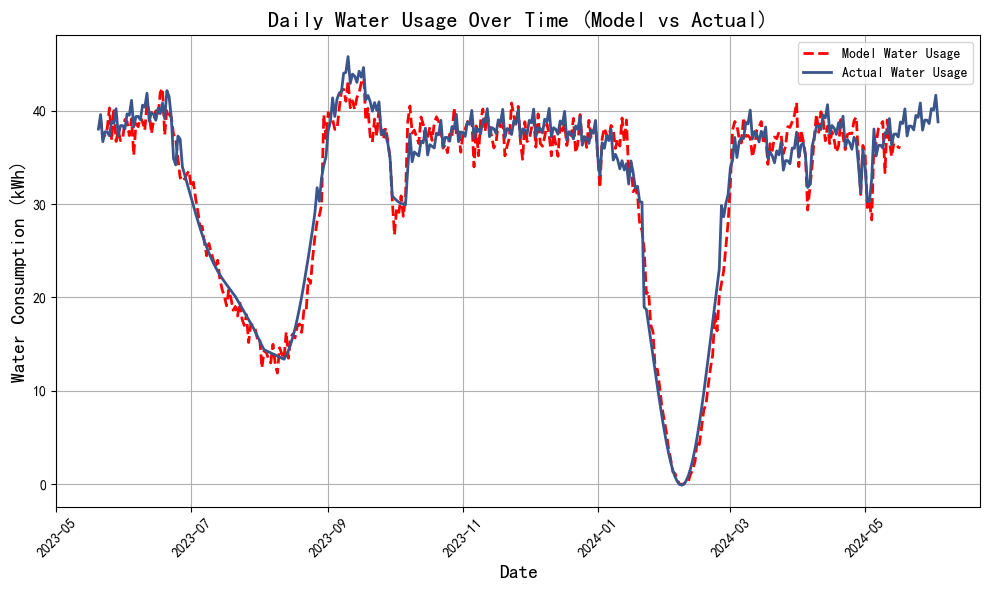

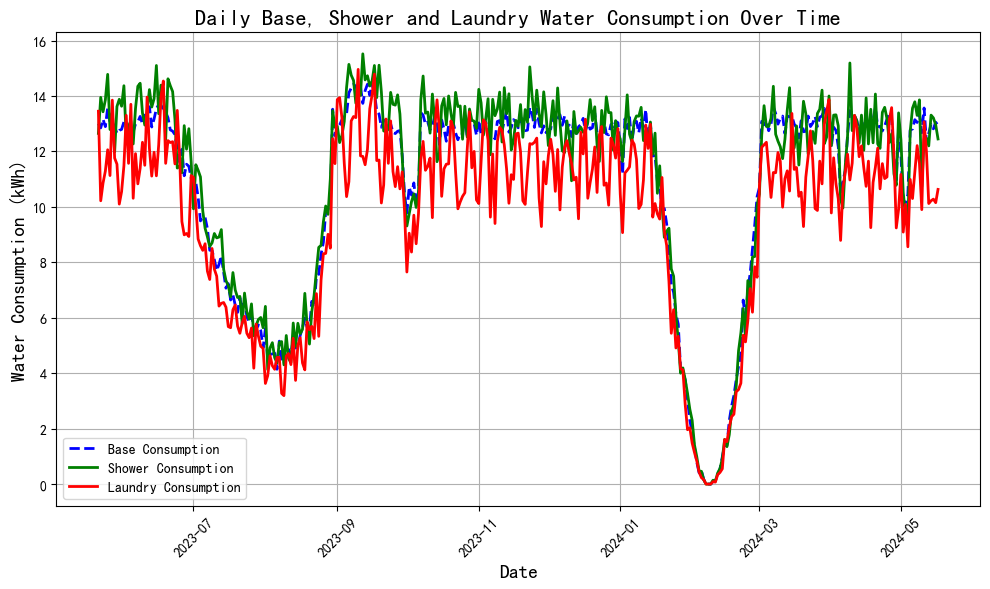

In [47]:
import random
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from mesa import Agent, Model
from numpy.random import normal
from mesa.datacollection import DataCollector  # 用于记录模型数据
import networkx as nx

# ==========================
# 学生主体类
# ==========================
class StudentAgent(Agent):
    def __init__(self, unique_id, model, summer_start, summer_end, winter_start, winter_end, holiday_effects,
                 profile="normal", grade=None, faculty=None, green_education=False, c_d_ratio=(0.5, 0.5)):
        """
        初始化学生主体
        """
        super().__init__(unique_id, model)
        self.is_on_campus = True

        # 设置寒暑假日期
        self.summer_start = datetime.strptime(summer_start, "%Y-%m-%d")
        self.summer_end = datetime.strptime(summer_end, "%Y-%m-%d")
        self.winter_start = datetime.strptime(winter_start, "%Y-%m-%d")
        self.winter_end = datetime.strptime(winter_end, "%Y-%m-%d")

        # 假期效应及社会属性
        self.holiday_effects = holiday_effects
        self.profile = profile
        self.grade = grade
        self.faculty = faculty
        self.green_education = green_education
        self.c, self.d = c_d_ratio

        # 基础设备每日用水量（升）
        self.base_consumption = self.calculate_base_consumption()

        # 初始化记录每日用水数据的属性
        self.last_water_usage = 0       # 总用水量（含噪声）
        self.last_base_usage = 0        # 基础用水量（不含噪声）
        self.last_extra_usage = 0       # 额外用水量（洗澡+洗衣，不含噪声）
        self.last_shower_usage = 0      # 洗澡额外用水量
        self.last_laundry_usage = 0     # 洗衣额外用水量

        # 每天洗澡与洗衣的概率（基于一周7天）
        self.shower_probs = [0.63, 0.66, 0.66, 0.65, 0.62, 0.62, 0.64]
        self.laundry_probs = [0.40, 0.40, 0.40, 0.40, 0.45, 0.45, 0.45]

        # 暑假与寒假在校概率多项式系数
        self._summer_coefficients = [8.60987857e-01, 1.36859624e-02, -1.99858329e-03,
                                      5.92193526e-05, -7.76982757e-07, 3.99970679e-09]
        self._winter_coefficients = [0.7645638874513381, -0.0013731766863659181, -0.0057098630785314556,
                                      0.00027673512470457806, -4.405621735518008e-06, 2.3663790433562584e-08]
        self.summer_probability_poly = Polynomial(self._summer_coefficients)
        self.winter_probability_poly = Polynomial(self._winter_coefficients)

        # 记录每日用水历史数据，格式：(日期, 用水数据字典)
        self.water_usage_history = []

    def calculate_behavior_utilities(self, neighbors_behavior):
        """
        根据邻居行为计算行为效用
        """
        V_env = neighbors_behavior["environmentalist"]
        V_normal = neighbors_behavior["normal"]

        if self.green_education:
            a, b, c, d = 0.7, 0.3, self.c, self.d
        else:
            a, b, c, d = 0.7, 0.3, 0.3, 0.7

        e = 0
        if self.faculty == "B":
            student_avg_usage = self.get_water_usage_last30_days()
            global_avg_usage = self.model.get_global_water_usage_last30_days()
            if global_avg_usage > 0:
                e = 1.5 * max(0, student_avg_usage / global_avg_usage - 1)

        if self.profile == "environmentalist":
            U_env_to_env = a * V_env + e
            U_env_to_normal = b * V_normal
            return U_env_to_env, U_env_to_normal
        else:
            U_normal_to_env = c * V_env + e
            U_normal_to_normal = d * V_normal
            return U_normal_to_env, U_normal_to_normal

    def calculate_base_consumption(self):
        """
        定义基础设备的每日用水量（单位：升）
        """
        if self.profile == "environmentalist":
            base_usage = {"toilet": 10, "sink": 15}
        else:
            base_usage = {"toilet": 17, "sink": 30}
        return sum(base_usage.values())

    def calculate_daily_water_usage(self):
        """
        计算每日用水量，返回字典：
          - total: 总用水量（基础+额外，并加入噪声）
          - base: 基础用水量（不含噪声）
          - extra: 额外用水量（洗澡+洗衣，不含噪声）
          - shower: 洗澡用水量
          - laundry: 洗衣用水量
        """
        if not self.is_on_campus:
            return {"total": 0, "base": 0, "extra": 0, "shower": 0, "laundry": 0}
        day_of_week = self.model.current_date.weekday()
        base_usage = self.base_consumption

        # 根据学生类型设置洗澡与洗衣的用水量参数
        if self.profile == "environmentalist":
            shower_usage = 50
            laundry_usage = 70
        else:
            shower_usage = 70
            laundry_usage = 90

        extra_shower = shower_usage if random.random() < self.shower_probs[day_of_week] else 0
        extra_laundry = laundry_usage if random.random() < self.laundry_probs[day_of_week] else 0
        extra_usage = extra_shower + extra_laundry
        total_usage = base_usage + extra_usage

        # 加入正态分布扰动
        total_usage_with_noise = max(0, normal(total_usage, total_usage * 0.05))
        return {"total": total_usage_with_noise,
                "base": base_usage,
                "extra": extra_usage,
                "shower": extra_shower,
                "laundry": extra_laundry}

    def update_on_campus_status(self):
        """
        根据日期与假期效应更新在校状态
        """
        current_date = self.model.current_date
        if self.summer_start <= current_date <= self.summer_end:
            day_count = (current_date - self.summer_start).days
            on_campus_probability = self.summer_probability_poly(day_count)
        elif self.winter_start <= current_date <= self.winter_end:
            day_count = (current_date - self.winter_start).days
            on_campus_probability = self.winter_probability_poly(day_count)
        else:
            if current_date in self.holiday_effects:
                daily_effect = sum(self.holiday_effects[current_date].values())
                on_campus_probability = 0.85 + daily_effect
            else:
                on_campus_probability = np.random.normal(0.85, 0.01)
        on_campus_probability = max(0, min(on_campus_probability, 1))
        self.is_on_campus = np.random.rand() < on_campus_probability

    def get_water_usage_last30_days(self):
        """
        计算过去30天平均总用水量
        """
        cutoff_date = self.model.current_date - timedelta(days=30)
        usage_values = [data["total"] for (date, data) in self.water_usage_history
                        if date > cutoff_date and data["total"] > 0]
        if usage_values:
            return sum(usage_values) / len(usage_values)
        else:
            return 0

    def step(self):
        """
        每日更新：更新在校状态、计算当天用水量，并记录
        """
        self.update_on_campus_status()
        usage_data = self.calculate_daily_water_usage()
        self.last_water_usage = usage_data["total"]
        self.last_base_usage = usage_data["base"]
        self.last_extra_usage = usage_data["extra"]
        self.last_shower_usage = usage_data["shower"]
        self.last_laundry_usage = usage_data["laundry"]
        self.water_usage_history.append((self.model.current_date, usage_data))


# ==========================
# 学生模型类
# ==========================
class StudentModel(Model):
    def __init__(self, num_agents, start_date, holiday_effects, beta=1.0, normal_env_ratio=(7, 3),
                 num_neighbors=4, c_d_ratio=(0.5, 0.5), interaction_interval=30, course_attendance_ratio=None):
        super().__init__()
        self.num_agents = num_agents
        self.holiday_effects = holiday_effects
        self.schedule = RandomActivation(self)
        self.current_date = datetime.strptime(start_date, "%Y-%m-%d")

        # 专业和年级比例
        self.faculty_total_ratio = {"A": [100, 100], "B": [100, 100]}
        self.course_attendance_ratio = course_attendance_ratio if course_attendance_ratio else {
            "A": [30, 15],
            "B": [30, 15]
        }

        # 数据收集器：记录总用水、基础、额外、洗澡和洗衣用水数据
        self.datacollector = DataCollector(
            agent_reporters={
                "TotalWaterUsage": lambda a: a.last_water_usage,
                "BaseConsumption": lambda a: a.last_base_usage,
                "ExtraWaterUsage": lambda a: a.last_extra_usage,
                "ShowerUsage": lambda a: a.last_shower_usage,
                "LaundryUsage": lambda a: a.last_laundry_usage,
                "Profile": lambda a: a.profile,
                "Faculty": lambda a: a.faculty,
                "Grade": lambda a: a.grade,
                "GreenEducation": lambda a: a.green_education
            }
        )

        self.interaction_groups = []
        self.beta = beta
        self.num_neighbors = num_neighbors
        self.c_d_ratio = c_d_ratio
        self.interaction_interval = interaction_interval
        self.normal_env_ratio = normal_env_ratio
        self.create_agents()

    def create_agents(self):
        """创建学生主体并加入调度器"""
        for i in range(self.num_agents):
            faculty, grade = self.assign_faculty_and_grade()
            green_education = self.assign_green_education(faculty, grade)
            profile = self.assign_profile()
            summer_start, summer_end = "2023-06-11", "2023-08-29"
            winter_start, winter_end = "2024-01-15", "2024-03-01"
            agent = StudentAgent(unique_id=i, model=self, summer_start=summer_start, summer_end=summer_end,
                                 winter_start=winter_start, winter_end=winter_end, holiday_effects=self.holiday_effects,
                                 profile=profile, grade=grade, faculty=faculty, green_education=green_education,
                                 c_d_ratio=self.c_d_ratio)
            self.schedule.add(agent)

    def assign_faculty_and_grade(self):
        """随机分配专业和年级"""
        faculty = random.choices(population=list(self.faculty_total_ratio.keys()),
                                 weights=[sum(self.faculty_total_ratio[f]) for f in self.faculty_total_ratio])[0]
        grade = random.choices(population=["低年级", "高年级"],
                               weights=self.faculty_total_ratio[faculty])[0]
        return faculty, grade

    def assign_green_education(self, faculty, grade):
        """根据课程比例决定是否参加绿色教育"""
        grades = ["低年级", "高年级"]
        grade_index = grades.index(grade)
        course_ratio = self.course_attendance_ratio[faculty][grade_index]
        total_students_in_grade = self.faculty_total_ratio[faculty][grade_index]
        return random.random() < (course_ratio / total_students_in_grade)

    def assign_profile(self):
        """根据给定比例分配行为类型"""
        normal_weight, env_weight = self.normal_env_ratio
        return random.choices(population=["normal", "environmentalist"], weights=[normal_weight, env_weight])[0]

    def create_interaction_groups(self):
        """
        根据小世界网络生成交互组
        """
        G = nx.watts_strogatz_graph(self.num_agents, self.num_neighbors, 0.2)
        for node in G.nodes():
            agent = self.schedule.agents[node]
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if agent.grade == self.schedule.agents[neighbor].grade:
                    G[node][neighbor]['weight'] = 2
                elif agent.faculty == self.schedule.agents[neighbor].faculty:
                    G[node][neighbor]['weight'] = 1.5
                elif agent.green_education == self.schedule.agents[neighbor].green_education:
                    G[node][neighbor]['weight'] = 1.5
                else:
                    G[node][neighbor]['weight'] = 1

        self.interaction_groups = []
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            group = [(self.schedule.agents[node], [self.schedule.agents[neighbor] for neighbor in neighbors])]
            self.interaction_groups.append(group)

        # 检查是否双向连接
        for node in G.nodes():
            neighbors = list(G.neighbors(node))
            for neighbor in neighbors:
                if node not in list(G.neighbors(neighbor)):
                    print(f"Warning: Node {node} and Node {neighbor} are not bidirectional.")

    def interact_agents(self):
        """处理交互逻辑，更新学生行为类型"""
        updates = []
        for group in self.interaction_groups:
            for agent, neighbors in group:
                neighbors_behavior = {
                    "environmentalist": sum(1 for a in neighbors if a.profile == "environmentalist") / len(neighbors),
                    "normal": sum(1 for a in neighbors if a.profile == "normal") / len(neighbors)
                }
                if agent.profile == "environmentalist":
                    U_env_to_env, U_env_to_normal = agent.calculate_behavior_utilities(neighbors_behavior)
                    U_env_to_env *= self.beta
                    U_env_to_normal *= self.beta
                    P_env_to_env = np.exp(U_env_to_env) / (np.exp(U_env_to_env) + np.exp(U_env_to_normal))
                    updates.append((agent, "environmentalist" if random.random() < P_env_to_env else "normal"))
                else:
                    U_normal_to_env, U_normal_to_normal = agent.calculate_behavior_utilities(neighbors_behavior)
                    U_normal_to_env *= self.beta
                    U_normal_to_normal *= self.beta
                    P_normal_to_env = np.exp(U_normal_to_env) / (np.exp(U_normal_to_env) + np.exp(U_normal_to_normal))
                    updates.append((agent, "environmentalist" if random.random() < P_normal_to_env else "normal"))
        for agent, new_profile in updates:
            agent.profile = new_profile

    def get_global_water_usage_last30_days(self):
        """计算所有代理过去30天平均总用水量"""
        valid_averages = []
        for agent in self.schedule.agents:
            usage = agent.get_water_usage_last30_days()
            if usage > 0:
                valid_averages.append(usage)
        if valid_averages:
            return sum(valid_averages) / len(valid_averages)
        else:
            return 0

    def step(self):
        """模型单步运行：更新日期、处理交互、执行代理更新、收集数据"""
        self.current_date += timedelta(days=1)
        if (self.current_date - datetime.strptime("2023-05-19", "%Y-%m-%d")).days % self.interaction_interval == 0:
            self.create_interaction_groups()
            self.interact_agents()
        self.schedule.step()
        self.datacollector.collect(self)


# ==========================
# 模型运行与结果绘图
# ==========================

# 设置随机种子
random.seed(42)
np.random.seed(42)

# 加载假期效应数据（Excel 文件需存在，并包含 'ds' 列）
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 加载实景数据（CSV 文件需存在，包含 'ds' 和 'actual_usage' 列）
actual_usage_file_path = 'filled_actual_usage.csv'
actual_usage_data = pd.read_csv(actual_usage_file_path, index_col=None)
actual_usage_data['ds'] = pd.to_datetime(actual_usage_data['ds'])
actual_usage_data = actual_usage_data.set_index('ds')
# 仅取前363天数据
actual_usage_data = actual_usage_data.iloc[:363]

# 创建并运行模型
model = StudentModel(num_agents=400, 
                     start_date="2023-05-20", 
                     holiday_effects=holiday_effects, 
                     beta=7, 
                     normal_env_ratio=(6, 4), 
                     num_neighbors=20, 
                     c_d_ratio=(0.5, 0.5),
                     interaction_interval=90)

# 模拟 363 天
for _ in range(363):
    model.step()

# --------------------------
# 绘制模型总用水量与实景数据对比图
# --------------------------
water_data = model.datacollector.get_agent_vars_dataframe()
daily_total = water_data.groupby("Step")["TotalWaterUsage"].sum() / 1000  # 单位转换，例如：升转换为 kWh（根据实际情况调整）

# 将 Step 转换为日期（假设模拟运行 363 天）
dates = [model.current_date - timedelta(days=(363 - step)) for step in daily_total.index]
dates = pd.to_datetime(dates)
daily_total.index = dates

model_data = daily_total.to_frame()
model_data.index.name = 'ds'
# 对齐实景数据
model_data = model_data.join(actual_usage_data['actual_usage'], how='left')

plt.figure(figsize=(10, 6))
plt.plot(model_data.index, model_data['TotalWaterUsage'], color='r', lw=2, linestyle='--', label='Model Water Usage')
plt.plot(actual_usage_data.index, actual_usage_data['actual_usage'], color='#3A548C', lw=2, label='Actual Water Usage')
plt.title("Daily Water Usage Over Time (Model vs Actual)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Water Consumption (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# --------------------------
# 绘制基础用水、洗澡用水与洗衣用水的时间图
# --------------------------
daily_base = water_data.groupby("Step")["BaseConsumption"].sum() / 1000
daily_shower = water_data.groupby("Step")["ShowerUsage"].sum() / 1000
daily_laundry = water_data.groupby("Step")["LaundryUsage"].sum() / 1000

# 将 Step 转换为日期
dates_base = [model.current_date - timedelta(days=(363 - step)) for step in daily_base.index]
dates_base = pd.to_datetime(dates_base)
daily_base.index = dates_base
daily_shower.index = dates_base
daily_laundry.index = dates_base

plt.figure(figsize=(10, 6))
plt.plot(daily_base.index, daily_base, lw=2, linestyle='--', color='blue', label='Base Consumption')
plt.plot(daily_shower.index, daily_shower, lw=2, linestyle='-', color='green', label='Shower Consumption')
plt.plot(daily_laundry.index, daily_laundry, lw=2, linestyle='-', color='red', label='Laundry Consumption')
plt.title("Daily Base, Shower and Laundry Water Consumption Over Time", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Water Consumption (kWh)", fontsize=14)
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import matplotlib.dates as mdates
from multiprocessing import Pool
import itertools
from tqdm import tqdm  # 导入 tqdm 用于显示进度条
import hashlib  # 用于生成稳定的哈希值

# 固定全局随机种子以保证整体可重复性（针对全局操作）
random.seed(42)
np.random.seed(42)

# 加载假期效应数据
file_path = 'All_holiday_effects.xlsx'
holiday_effects_sheet = pd.ExcelFile(file_path).parse('Sheet1')
holiday_effects_sheet['ds'] = pd.to_datetime(holiday_effects_sheet['ds'])
holiday_effects = holiday_effects_sheet.set_index('ds').to_dict(orient='index')

# 如果需要加载最大值和最小值数据进行后续对比，可在这里加载
max_file_path = 'baseline_daily_usage_df_max.csv'
min_file_path = 'baseline_daily_usage_df_min.csv'
max_values = pd.read_csv(max_file_path, index_col=0)
min_values = pd.read_csv(min_file_path, index_col=0)

# 参数遍历设置
c_d_ratios = [(0.4, 0.6), (0.5, 0.5), (0.6, 0.4), (0.7, 0.3)]
normal_env_ratios = [(8, 2), (7, 3), (6, 4), (5, 5)]
course_attendance_ratios = [
    {"A": [20, 10], "B": [20, 10]},  # 原始比例
    {"A": [30, 15], "B": [30, 15]},  # 一倍比例
    {"A": [40, 20], "B": [40, 20]},  # 两倍比例
    {"A": [50, 25], "B": [50, 25]}   # 三倍比例
]

def run_simulation(params):
    """
    根据参数组合运行模拟，并返回每日总用水量数据（单位：千升）以及对应的参数信息，
    同时记录最终的代理数量及比例。
    """
    c_d_ratio, normal_env_ratio, course_attendance_ratio = params

    # 根据参数生成唯一子种子（使用 MD5 哈希保证不同组合得到不同且稳定的种子）
    seed_str = str(params)
    seed_val = int(hashlib.md5(seed_str.encode('utf-8')).hexdigest(), 16) % (2**32)
    # 设置当前进程的随机种子
    random.seed(seed_val)
    np.random.seed(seed_val)

    # 初始化模型（请保证 StudentModel 已经在当前作用域中定义）
    model = StudentModel(
        num_agents=400,
        start_date="2023-05-19",
        holiday_effects=holiday_effects,
        beta=5,
        normal_env_ratio=normal_env_ratio,
        num_neighbors=20,
        c_d_ratio=c_d_ratio,
        interaction_interval=90,
        course_attendance_ratio=course_attendance_ratio
    )

    # 运行模拟 363 天（每一步内部会更新日期并收集数据）
    for _ in range(363):
        model.step()
        # 如果 step() 内部没有自动收集数据，可在此处调用:
        # model.datacollector.collect(model)

    # 获取模型收集的代理数据，并计算每日总用水量（单位转换为千升）
    water_data = model.datacollector.get_agent_vars_dataframe()
    daily_usage = water_data.groupby("Step")["WaterUsage"].sum() / 1000

    # 将 Step 映射为实际日期（这里假设模拟结束时 model.current_date 为最后一天的日期）
    daily_usage.index = [model.current_date - timedelta(days=(363 - step))
                           for step in daily_usage.index]
    daily_usage.index.name = 'ds'
    model_data = daily_usage.to_frame().reset_index()

    # 记录当前参数信息
    model_data['c_d_ratio'] = str(c_d_ratio)
    model_data['normal_env_ratio'] = str(normal_env_ratio)
    model_data['course_attendance_ratio'] = str(course_attendance_ratio)

    # 计算最终状态下代理人数量与比例
    total_agents = len(model.schedule.agents)
    env_total = sum(1 for agent in model.schedule.agents if agent.profile == 'environmentalist')
    normal_total = total_agents - env_total
    env_ratio = env_total / total_agents
    normal_ratio = normal_total / total_agents

    # 将代理信息加入 DataFrame（所有行均为该模拟的最终状态）
    model_data['env_ratio'] = env_ratio
    model_data['normal_ratio'] = normal_ratio

    return model_data

if __name__ == '__main__':
    # 记录开始时间
    start_time = datetime.now()

    # 构建所有参数组合
    params_list = list(itertools.product(c_d_ratios, normal_env_ratios, course_attendance_ratios))
    print("总参数组合数：", len(params_list))

    # 使用12进程池并行模拟，并使用 tqdm 显示进度条
    with Pool(processes=12) as pool:
        results = list(tqdm(pool.imap(run_simulation, params_list), total=len(params_list)))

    # 合并所有结果为一个 DataFrame
    combined_df = pd.concat(results, ignore_index=True)

    # 保存结果到 CSV 文件
    combined_df.to_csv("simulation_results_with_agent_counts_beta5.csv", index=False)
    print("所有参数组合的模拟结果已保存至 simulation_results_with_agent_counts.csv")

    # 记录结束时间，并计算总耗时
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print(f"总耗时：{elapsed_time}")


总参数组合数： 64


  0%|          | 0/64 [00:00<?, ?it/s]

## 8.3 END